# Finetuning FakeNewsAAAI Zero Shot Yejin
FakeNewsAAAI is a Fake News dataset with 2 possible labels: `real` and `fake`

In [1]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from tqdm import tqdm
import pickle
from copy import deepcopy
from multiprocessing import Pool                                                

from transformers import BertForSequenceClassification, RobertaForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer
from utils.forward_fn import forward_sequence_classification, forward_hessian_sequence_classification
from utils.metrics import classification_metrics_fn
from utils.data_utils import FakeNewsDataset, FakeNewsDataLoader
from utils.utils import generate_random_mask

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.4f}'.format(key, value))
    return ' '.join(string_list)

In [4]:
# Set random seed
set_seed(26092020)

# Load Model

In [5]:
# Load Tokenizer and Config
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
config = AutoConfig.from_pretrained('roberta-base')
config.num_labels = FakeNewsDataset.NUM_LABELS

# Instantiate model
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', config=config)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [6]:
count_param(model)

124647170

# Prepare Dataset

In [7]:
train_dataset_path = './data/train.tsv'
valid_dataset_path = './data/valid.tsv'
test_dataset_path = './data/test.tsv'
valid_zero_dataset_path = './data/covid19_infodemic_english_data/processed_valid_data.tsv'
test_zero_dataset_path = './data/covid19_infodemic_english_data/processed_test_data.tsv'

In [8]:
train_dataset = FakeNewsDataset(dataset_path=train_dataset_path, tokenizer=tokenizer, lowercase=False)
valid_dataset = FakeNewsDataset(dataset_path=valid_dataset_path, tokenizer=tokenizer, lowercase=False)
test_dataset = FakeNewsDataset(dataset_path=test_dataset_path, tokenizer=tokenizer, lowercase=False)
valid_zero_dataset = FakeNewsDataset(dataset_path=valid_zero_dataset_path, tokenizer=tokenizer, lowercase=False)
test_zero_dataset = FakeNewsDataset(dataset_path=test_zero_dataset_path, tokenizer=tokenizer, lowercase=False)

train_loader = FakeNewsDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=8, num_workers=8, shuffle=True)  
valid_loader = FakeNewsDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=8, num_workers=8, shuffle=False)  
test_loader = FakeNewsDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=8, num_workers=8, shuffle=False)  
valid_zero_loader = FakeNewsDataLoader(dataset=valid_zero_dataset, max_seq_len=512, batch_size=8, num_workers=8, shuffle=False)
test_zero_loader = FakeNewsDataLoader(dataset=test_zero_dataset, max_seq_len=512, batch_size=8, num_workers=8, shuffle=False)

In [9]:
w2i, i2w = FakeNewsDataset.LABEL2INDEX, FakeNewsDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'fake': 0, 'real': 1}
{0: 'fake', 1: 'real'}


In [10]:
len(train_dataset), len(valid_dataset), len(test_dataset), len(valid_zero_dataset)

(6420, 2140, 2140, 60)

# Fine Tuning & Evaluation
- First, fine-tune to indian dataset
- Eval to both Indian and Yejin
- Run Additional Fine Tuning with hessian loss
- Run Additional Fine Tuning without hessian loss (for comparison)

In [11]:
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [13]:
# Train without mask
n_epochs = 25
best_val_metric, best_metrics, best_state_dict = 0, None, None
early_stop, count_stop = 5, 0
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        outputs = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = classification_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        outputs = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = classification_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = classification_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    # Early stopping
    val_metric = metrics['F1']
    if best_val_metric <= val_metric:
        torch.save(model.state_dict(), './tmp_hessian/initial_model_weight.pt')
        best_val_metric = val_metric
        best_metrics = metrics
        count_stop = 0
    else:
        count_stop += 1
        if count_stop == early_stop:
            break
            
print('== BEST METRICS ==')
print(metrics_to_string(best_metrics))

(Epoch 1) TRAIN LOSS:0.2903 LR:0.00000300: 100%|██████████| 803/803 [01:22<00:00,  9.68it/s]
/home/samuel/anaconda2/envs/env_py3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'fake') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 1) TRAIN LOSS:0.2903 ACC:0.8665 F1:0.8653 REC:0.8640 PRE:0.8705 LR:0.00000300


VALID LOSS:0.1017 ACC:0.9637 F1:0.9636 REC:0.9638 PRE:0.9635:  75%|███████▍  | 200/268 [00:07<00:02, 24.75it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1040 ACC:0.9617 F1:0.9616 REC:0.9616 PRE:0.9616: 100%|██████████| 268/268 [00:10<00:00, 26.20it/s]


(Epoch 1) VALID LOSS:0.1040 ACC:0.9617 F1:0.9616 REC:0.9616 PRE:0.9616


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.0872 ACC:0.9699 F1:0.9699 REC:0.9697 PRE:0.9700 LR:0.00000300


VALID LOSS:0.0888 ACC:0.9712 F1:0.9711 REC:0.9702 PRE:0.9724:  75%|███████▍  | 200/268 [00:07<00:02, 23.86it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.0927 ACC:0.9692 F1:0.9690 REC:0.9682 PRE:0.9705: 100%|██████████| 268/268 [00:10<00:00, 26.35it/s]


(Epoch 2) VALID LOSS:0.0927 ACC:0.9692 F1:0.9690 REC:0.9682 PRE:0.9705


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.0536 ACC:0.9832 F1:0.9831 REC:0.9830 PRE:0.9833 LR:0.00000300


VALID LOSS:0.0708 ACC:0.9750 F1:0.9749 REC:0.9753 PRE:0.9746:  74%|███████▍  | 198/268 [00:07<00:02, 24.76it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.0691 ACC:0.9743 F1:0.9743 REC:0.9745 PRE:0.9741: 100%|██████████| 268/268 [00:10<00:00, 26.37it/s]


(Epoch 3) VALID LOSS:0.0691 ACC:0.9743 F1:0.9743 REC:0.9745 PRE:0.9741


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.0360 ACC:0.9885 F1:0.9884 REC:0.9884 PRE:0.9885 LR:0.00000300


VALID LOSS:0.0789 ACC:0.9744 F1:0.9743 REC:0.9738 PRE:0.9748:  75%|███████▍  | 200/268 [00:07<00:02, 25.19it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.0798 ACC:0.9734 F1:0.9733 REC:0.9729 PRE:0.9738: 100%|██████████| 268/268 [00:10<00:00, 26.05it/s]
  0%|          | 0/803 [00:00<?, ?it/s]

(Epoch 4) VALID LOSS:0.0798 ACC:0.9734 F1:0.9733 REC:0.9729 PRE:0.9738


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0239 ACC:0.9928 F1:0.9928 REC:0.9928 PRE:0.9928 LR:0.00000300


VALID LOSS:0.0987 ACC:0.9725 F1:0.9723 REC:0.9711 PRE:0.9743:  74%|███████▍  | 198/268 [00:07<00:02, 23.41it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1087 ACC:0.9701 F1:0.9699 REC:0.9690 PRE:0.9719: 100%|██████████| 268/268 [00:10<00:00, 25.92it/s]
  0%|          | 0/803 [00:00<?, ?it/s]

(Epoch 5) VALID LOSS:0.1087 ACC:0.9701 F1:0.9699 REC:0.9690 PRE:0.9719


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 6) TRAIN LOSS:0.0154 ACC:0.9960 F1:0.9959 REC:0.9959 PRE:0.9959 LR:0.00000300


VALID LOSS:0.1042 ACC:0.9738 F1:0.9736 REC:0.9731 PRE:0.9743:  74%|███████▍  | 199/268 [00:07<00:02, 23.97it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1024 ACC:0.9729 F1:0.9728 REC:0.9723 PRE:0.9735: 100%|██████████| 268/268 [00:10<00:00, 25.87it/s]
  0%|          | 0/803 [00:00<?, ?it/s]

(Epoch 6) VALID LOSS:0.1024 ACC:0.9729 F1:0.9728 REC:0.9723 PRE:0.9735


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 7) TRAIN LOSS:0.0113 ACC:0.9961 F1:0.9961 REC:0.9961 PRE:0.9961 LR:0.00000300


VALID LOSS:0.1009 ACC:0.9762 F1:0.9761 REC:0.9756 PRE:0.9768:  74%|███████▍  | 199/268 [00:07<00:02, 24.83it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1040 ACC:0.9757 F1:0.9756 REC:0.9752 PRE:0.9762: 100%|██████████| 268/268 [00:10<00:00, 26.08it/s]


(Epoch 7) VALID LOSS:0.1040 ACC:0.9757 F1:0.9756 REC:0.9752 PRE:0.9762


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 8) TRAIN LOSS:0.0138 ACC:0.9960 F1:0.9959 REC:0.9959 PRE:0.9960 LR:0.00000300


VALID LOSS:0.0829 ACC:0.9825 F1:0.9824 REC:0.9821 PRE:0.9828:  74%|███████▍  | 199/268 [00:07<00:02, 24.92it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.0896 ACC:0.9799 F1:0.9799 REC:0.9796 PRE:0.9802: 100%|██████████| 268/268 [00:10<00:00, 25.86it/s]


(Epoch 8) VALID LOSS:0.0896 ACC:0.9799 F1:0.9799 REC:0.9796 PRE:0.9802


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 9) TRAIN LOSS:0.0107 ACC:0.9964 F1:0.9964 REC:0.9964 PRE:0.9964 LR:0.00000300


VALID LOSS:0.1070 ACC:0.9744 F1:0.9743 REC:0.9747 PRE:0.9740:  75%|███████▍  | 200/268 [00:07<00:02, 24.32it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1047 ACC:0.9752 F1:0.9752 REC:0.9755 PRE:0.9750: 100%|██████████| 268/268 [00:10<00:00, 26.04it/s]
  0%|          | 0/803 [00:00<?, ?it/s]

(Epoch 9) VALID LOSS:0.1047 ACC:0.9752 F1:0.9752 REC:0.9755 PRE:0.9750


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 10) TRAIN LOSS:0.0050 ACC:0.9984 F1:0.9984 REC:0.9984 PRE:0.9985 LR:0.00000300


VALID LOSS:0.0974 ACC:0.9788 F1:0.9787 REC:0.9791 PRE:0.9784:  75%|███████▍  | 200/268 [00:07<00:02, 25.00it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.0906 ACC:0.9804 F1:0.9803 REC:0.9805 PRE:0.9802: 100%|██████████| 268/268 [00:10<00:00, 26.28it/s]


(Epoch 10) VALID LOSS:0.0906 ACC:0.9804 F1:0.9803 REC:0.9805 PRE:0.9802


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 11) TRAIN LOSS:0.0057 ACC:0.9978 F1:0.9978 REC:0.9978 PRE:0.9978 LR:0.00000300


VALID LOSS:0.1071 ACC:0.9806 F1:0.9805 REC:0.9796 PRE:0.9818:  75%|███████▍  | 200/268 [00:07<00:02, 24.98it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1132 ACC:0.9780 F1:0.9779 REC:0.9772 PRE:0.9792: 100%|██████████| 268/268 [00:10<00:00, 26.02it/s]
  0%|          | 0/803 [00:00<?, ?it/s]

(Epoch 11) VALID LOSS:0.1132 ACC:0.9780 F1:0.9779 REC:0.9772 PRE:0.9792


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 12) TRAIN LOSS:0.0063 ACC:0.9978 F1:0.9978 REC:0.9978 PRE:0.9978 LR:0.00000300


VALID LOSS:0.1219 ACC:0.9788 F1:0.9786 REC:0.9777 PRE:0.9800:  74%|███████▍  | 198/268 [00:07<00:02, 25.01it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1295 ACC:0.9752 F1:0.9751 REC:0.9743 PRE:0.9766: 100%|██████████| 268/268 [00:10<00:00, 26.13it/s]
  0%|          | 0/803 [00:00<?, ?it/s]

(Epoch 12) VALID LOSS:0.1295 ACC:0.9752 F1:0.9751 REC:0.9743 PRE:0.9766


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 13) TRAIN LOSS:0.0052 ACC:0.9988 F1:0.9988 REC:0.9987 PRE:0.9988 LR:0.00000300


VALID LOSS:0.1126 ACC:0.9800 F1:0.9799 REC:0.9792 PRE:0.9808:  74%|███████▍  | 199/268 [00:07<00:02, 23.73it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1205 ACC:0.9762 F1:0.9761 REC:0.9755 PRE:0.9770: 100%|██████████| 268/268 [00:10<00:00, 25.86it/s]
  0%|          | 0/803 [00:00<?, ?it/s]

(Epoch 13) VALID LOSS:0.1205 ACC:0.9762 F1:0.9761 REC:0.9755 PRE:0.9770


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 14) TRAIN LOSS:0.0004 ACC:1.0000 F1:1.0000 REC:1.0000 PRE:1.0000 LR:0.00000300


VALID LOSS:0.1196 ACC:0.9800 F1:0.9799 REC:0.9791 PRE:0.9809:  74%|███████▍  | 198/268 [00:06<00:02, 26.05it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1277 ACC:0.9771 F1:0.9770 REC:0.9764 PRE:0.9781: 100%|██████████| 268/268 [00:09<00:00, 27.15it/s]
  0%|          | 0/803 [00:00<?, ?it/s]

(Epoch 14) VALID LOSS:0.1277 ACC:0.9771 F1:0.9770 REC:0.9764 PRE:0.9781


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 15) TRAIN LOSS:0.0060 ACC:0.9978 F1:0.9978 REC:0.9978 PRE:0.9978 LR:0.00000300


VALID LOSS:0.1076 ACC:0.9762 F1:0.9762 REC:0.9765 PRE:0.9759:  74%|███████▍  | 198/268 [00:07<00:02, 25.08it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1085 ACC:0.9757 F1:0.9757 REC:0.9759 PRE:0.9755: 100%|██████████| 268/268 [00:10<00:00, 25.73it/s]

(Epoch 15) VALID LOSS:0.1085 ACC:0.9757 F1:0.9757 REC:0.9759 PRE:0.9755
== BEST METRICS ==
ACC:0.9804 F1:0.9803 REC:0.9805 PRE:0.9802


In [14]:
# Load best model
model.load_state_dict(torch.load('./tmp_hessian/initial_model_weight.pt'))

<All keys matched successfully>

In [15]:
# Test on Indian test set
model.eval()
torch.set_grad_enabled(False)

total_loss = 0
list_hyp, list_label = [], []
pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    batch_seq = batch_data[-1]        
    outputs = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    loss, batch_hyp, batch_label, logits, label_batch = outputs

    # Calculate total loss
    total_loss += loss.item()

    # Calculate evaluation metrics
    list_hyp += batch_hyp
    list_label += batch_label

    pbar.set_description("TEST LOSS:{:.4f}".format(total_loss/(i+1)))

eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
for key in fake_metrics.keys():
    eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
for key in real_metrics.keys():
    eval_metrics[f'REAL_{key}'] = real_metrics[key]

print(f'TEST RESULT: {metrics_to_string(eval_metrics)}')

TEST LOSS:0.0940: 100%|██████████| 268/268 [00:07<00:00, 35.02it/s]
/home/samuel/anaconda2/envs/env_py3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'fake') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


TEST RESULT: ACC:0.9776 F1:0.9775 REC:0.9780 PRE:0.9773 FAKE_ACC:0.9776 FAKE_F1:0.9767 FAKE_REC:0.9863 FAKE_PRE:0.9673 REAL_ACC:0.9776 REAL_F1:0.9784 REAL_REC:0.9696 REAL_PRE:0.9873


In [16]:
# Test on Yejin test set
model.eval()
torch.set_grad_enabled(False)

total_loss = 0
list_hyp, list_label = [], []
pbar = tqdm(test_zero_loader, leave=True, total=len(test_zero_loader))
for i, batch_data in enumerate(pbar):
    batch_seq = batch_data[-1]        
    outputs = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    loss, batch_hyp, batch_label, logits, label_batch = outputs

    # Calculate total loss
    total_loss += loss.item()

    # Calculate evaluation metrics
    list_hyp += batch_hyp
    list_label += batch_label

    pbar.set_description("TEST LOSS:{:.4f}".format(total_loss/(i+1)))

eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
for key in fake_metrics.keys():
    eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
for key in real_metrics.keys():
    eval_metrics[f'REAL_{key}'] = real_metrics[key]

print(f'TEST RESULT: {metrics_to_string(eval_metrics)}')

TEST LOSS:5.3574: 100%|██████████| 30/30 [00:01<00:00, 22.19it/s]

TEST RESULT: ACC:0.3544 F1:0.3409 REC:0.5702 PRE:0.6392 FAKE_ACC:0.3544 FAKE_F1:0.4354 FAKE_REC:1.0000 FAKE_PRE:0.2783 REAL_ACC:0.3544 REAL_F1:0.2463 REAL_REC:0.1404 REAL_PRE:1.0000


# Fine Tuning with Hessian Loss
- Freeze RoBERTa model
- Reinit optimizer
- Apply Hessian calculation on the classifier
- Apply λ warmup with initial λ = 0.025 and T = 1e5

In [14]:
# Load best model
model.load_state_dict(torch.load('./tmp_hessian/initial_model_weight.pt'))

<All keys matched successfully>

In [17]:
# Init Hyperparameters
λ, T = 1e5, 1e4

In [18]:
# Freeze roberta layer
for param in model.roberta.parameters():
    param.requires_grad = False

In [19]:
# Reinit Optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [20]:
# Train with Hessian Loss
n_epochs = 15
best_val_metric, best_metrics, best_state_dict = 0, None, None
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        t = epoch * len(train_loader) + i
        λt = λ * min(1, float(t) / T)

        # Forward model
        outputs = forward_hessian_sequence_classification(model, batch_data[:-1], i2w=i2w, hess_weight=λt, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = classification_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        outputs = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = classification_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = classification_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    # Don't apply Early stopping
    val_metric = metrics['F1']
    torch.save(model.state_dict(), './tmp_hessian/hessian_model_weight.pt')
    best_val_metric = val_metric
    best_metrics = metrics
            
print('== BEST METRICS ==')
print(metrics_to_string(best_metrics))

  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 1) TRAIN LOSS:0.0067 ACC:0.9978 F1:0.9978 REC:0.9979 PRE:0.9977 LR:0.00000300


VALID LOSS:0.0968 ACC:0.9800 F1:0.9799 REC:0.9800 PRE:0.9799:  74%|███████▍  | 199/268 [00:07<00:02, 24.74it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.0911 ACC:0.9813 F1:0.9813 REC:0.9813 PRE:0.9812: 100%|██████████| 268/268 [00:10<00:00, 26.26it/s]


(Epoch 1) VALID LOSS:0.0911 ACC:0.9813 F1:0.9813 REC:0.9813 PRE:0.9812


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.0051 ACC:0.9981 F1:0.9981 REC:0.9982 PRE:0.9981 LR:0.00000300


VALID LOSS:0.0962 ACC:0.9781 F1:0.9780 REC:0.9778 PRE:0.9783:  74%|███████▍  | 199/268 [00:07<00:02, 25.26it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.0915 ACC:0.9790 F1:0.9789 REC:0.9787 PRE:0.9791: 100%|██████████| 268/268 [00:10<00:00, 26.21it/s]


(Epoch 2) VALID LOSS:0.0915 ACC:0.9790 F1:0.9789 REC:0.9787 PRE:0.9791


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.0041 ACC:0.9986 F1:0.9986 REC:0.9986 PRE:0.9986 LR:0.00000300


VALID LOSS:0.0968 ACC:0.9781 F1:0.9780 REC:0.9777 PRE:0.9784:  74%|███████▍  | 199/268 [00:07<00:02, 24.15it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.0929 ACC:0.9785 F1:0.9784 REC:0.9782 PRE:0.9788: 100%|██████████| 268/268 [00:10<00:00, 26.13it/s]


(Epoch 3) VALID LOSS:0.0929 ACC:0.9785 F1:0.9784 REC:0.9782 PRE:0.9788


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.0027 ACC:0.9989 F1:0.9989 REC:0.9989 PRE:0.9989 LR:0.00000300


VALID LOSS:0.0997 ACC:0.9794 F1:0.9793 REC:0.9789 PRE:0.9798:  75%|███████▍  | 200/268 [00:07<00:02, 24.54it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.0961 ACC:0.9785 F1:0.9784 REC:0.9781 PRE:0.9789: 100%|██████████| 268/268 [00:10<00:00, 25.97it/s]


(Epoch 4) VALID LOSS:0.0961 ACC:0.9785 F1:0.9784 REC:0.9781 PRE:0.9789


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0035 ACC:0.9988 F1:0.9988 REC:0.9988 PRE:0.9987 LR:0.00000300


VALID LOSS:0.1019 ACC:0.9781 F1:0.9780 REC:0.9775 PRE:0.9786:  74%|███████▍  | 198/268 [00:07<00:02, 24.62it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.0991 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9776: 100%|██████████| 268/268 [00:10<00:00, 26.03it/s]


(Epoch 5) VALID LOSS:0.0991 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9776


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 6) TRAIN LOSS:0.0027 ACC:0.9994 F1:0.9994 REC:0.9994 PRE:0.9994 LR:0.00000300


VALID LOSS:0.1040 ACC:0.9781 F1:0.9780 REC:0.9775 PRE:0.9786:  74%|███████▍  | 199/268 [00:07<00:02, 25.00it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1014 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9776: 100%|██████████| 268/268 [00:10<00:00, 26.28it/s]


(Epoch 6) VALID LOSS:0.1014 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9776


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 7) TRAIN LOSS:0.0022 ACC:0.9992 F1:0.9992 REC:0.9992 PRE:0.9992 LR:0.00000300


VALID LOSS:0.1066 ACC:0.9781 F1:0.9780 REC:0.9775 PRE:0.9786:  74%|███████▍  | 199/268 [00:07<00:02, 24.99it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1038 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9776: 100%|██████████| 268/268 [00:10<00:00, 26.06it/s]


(Epoch 7) VALID LOSS:0.1038 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9776


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 8) TRAIN LOSS:0.0032 ACC:0.9992 F1:0.9992 REC:0.9992 PRE:0.9992 LR:0.00000300


VALID LOSS:0.1082 ACC:0.9788 F1:0.9786 REC:0.9781 PRE:0.9793:  75%|███████▍  | 200/268 [00:07<00:02, 24.59it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1059 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9777: 100%|██████████| 268/268 [00:10<00:00, 26.12it/s]


(Epoch 8) VALID LOSS:0.1059 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9777


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 9) TRAIN LOSS:0.0016 ACC:0.9997 F1:0.9997 REC:0.9997 PRE:0.9997 LR:0.00000300


VALID LOSS:0.1103 ACC:0.9788 F1:0.9786 REC:0.9781 PRE:0.9793:  74%|███████▍  | 199/268 [00:07<00:02, 24.69it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1076 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9777: 100%|██████████| 268/268 [00:10<00:00, 26.28it/s]


(Epoch 9) VALID LOSS:0.1076 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9777


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 10) TRAIN LOSS:0.0026 ACC:0.9992 F1:0.9992 REC:0.9992 PRE:0.9992 LR:0.00000300


VALID LOSS:0.1121 ACC:0.9788 F1:0.9786 REC:0.9781 PRE:0.9793:  75%|███████▍  | 200/268 [00:07<00:02, 24.44it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1098 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9777: 100%|██████████| 268/268 [00:10<00:00, 26.09it/s]


(Epoch 10) VALID LOSS:0.1098 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9777


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 11) TRAIN LOSS:0.0018 ACC:0.9995 F1:0.9995 REC:0.9995 PRE:0.9995 LR:0.00000300


VALID LOSS:0.1143 ACC:0.9788 F1:0.9786 REC:0.9781 PRE:0.9793:  74%|███████▍  | 199/268 [00:07<00:02, 24.47it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1123 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9777: 100%|██████████| 268/268 [00:10<00:00, 26.24it/s]


(Epoch 11) VALID LOSS:0.1123 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9777


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 12) TRAIN LOSS:0.0020 ACC:0.9997 F1:0.9997 REC:0.9997 PRE:0.9997 LR:0.00000300


VALID LOSS:0.1154 ACC:0.9788 F1:0.9786 REC:0.9781 PRE:0.9793:  74%|███████▍  | 198/268 [00:07<00:02, 25.08it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1130 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9777: 100%|██████████| 268/268 [00:10<00:00, 26.29it/s]


(Epoch 12) VALID LOSS:0.1130 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9777


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 13) TRAIN LOSS:0.0018 ACC:0.9995 F1:0.9995 REC:0.9995 PRE:0.9995 LR:0.00000300


VALID LOSS:0.1168 ACC:0.9788 F1:0.9786 REC:0.9781 PRE:0.9793:  75%|███████▍  | 200/268 [00:07<00:02, 24.91it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1143 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9777: 100%|██████████| 268/268 [00:10<00:00, 26.37it/s]


(Epoch 13) VALID LOSS:0.1143 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9777


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 14) TRAIN LOSS:0.0017 ACC:0.9994 F1:0.9994 REC:0.9994 PRE:0.9994 LR:0.00000300


VALID LOSS:0.1177 ACC:0.9788 F1:0.9786 REC:0.9781 PRE:0.9793:  75%|███████▍  | 200/268 [00:07<00:02, 25.16it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1151 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9777: 100%|██████████| 268/268 [00:10<00:00, 26.73it/s]


(Epoch 14) VALID LOSS:0.1151 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9777


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 15) TRAIN LOSS:0.0020 ACC:0.9992 F1:0.9992 REC:0.9992 PRE:0.9992 LR:0.00000300


VALID LOSS:0.1183 ACC:0.9788 F1:0.9786 REC:0.9781 PRE:0.9793:  75%|███████▍  | 200/268 [00:07<00:02, 24.71it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1160 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9777: 100%|██████████| 268/268 [00:10<00:00, 26.03it/s]


(Epoch 15) VALID LOSS:0.1160 ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9777
== BEST METRICS ==
ACC:0.9771 F1:0.9770 REC:0.9766 PRE:0.9777


In [21]:
# Load best model
model.load_state_dict(torch.load('./tmp_hessian/hessian_model_weight.pt'))

<All keys matched successfully>

In [22]:
# Test on Indian test set
model.eval()
torch.set_grad_enabled(False)

total_loss = 0
list_hyp, list_label = [], []
pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    batch_seq = batch_data[-1]        
    outputs = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    loss, batch_hyp, batch_label, logits, label_batch = outputs

    # Calculate total loss
    total_loss += loss.item()

    # Calculate evaluation metrics
    list_hyp += batch_hyp
    list_label += batch_label

    pbar.set_description("TEST LOSS:{:.4f}".format(total_loss/(i+1)))

eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
for key in fake_metrics.keys():
    eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
for key in real_metrics.keys():
    eval_metrics[f'REAL_{key}'] = real_metrics[key]

print(f'TEST RESULT: {metrics_to_string(eval_metrics)}')

TEST LOSS:0.0951: 100%|██████████| 268/268 [00:07<00:00, 34.82it/s]
/home/samuel/anaconda2/envs/env_py3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'fake') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


TEST RESULT: ACC:0.9827 F1:0.9827 REC:0.9824 PRE:0.9830 FAKE_ACC:0.9827 FAKE_F1:0.9817 FAKE_REC:0.9755 FAKE_PRE:0.9881 REAL_ACC:0.9827 REAL_F1:0.9836 REAL_REC:0.9893 REAL_PRE:0.9779


In [23]:
# Test on Yejin test set
model.eval()
torch.set_grad_enabled(False)

total_loss = 0
list_hyp, list_label = [], []
pbar = tqdm(test_zero_loader, leave=True, total=len(test_zero_loader))
for i, batch_data in enumerate(pbar):
    batch_seq = batch_data[-1]        
    outputs = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    loss, batch_hyp, batch_label, logits, label_batch = outputs

    # Calculate total loss
    total_loss += loss.item()

    # Calculate evaluation metrics
    list_hyp += batch_hyp
    list_label += batch_label

    pbar.set_description("TEST LOSS:{:.4f}".format(total_loss/(i+1)))

eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
for key in fake_metrics.keys():
    eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
for key in real_metrics.keys():
    eval_metrics[f'REAL_{key}'] = real_metrics[key]

print(f'TEST RESULT: {metrics_to_string(eval_metrics)}')

TEST LOSS:4.7578: 100%|██████████| 30/30 [00:01<00:00, 22.85it/s]

TEST RESULT: ACC:0.4135 F1:0.4101 REC:0.6039 PRE:0.6358 FAKE_ACC:0.4135 FAKE_F1:0.4549 FAKE_REC:0.9831 FAKE_PRE:0.2959 REAL_ACC:0.4135 REAL_F1:0.3653 REAL_REC:0.2247 REAL_PRE:0.9756


# Additional Fine Tuning baseline (For comparison purpose)

In [12]:
# Load best model
model.load_state_dict(torch.load('./tmp_hessian/initial_model_weight.pt'))

<All keys matched successfully>

In [13]:
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [14]:
# Train without mask
n_epochs = 15
best_val_metric, best_metrics, best_state_dict = 0, None, None
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        outputs = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = classification_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        outputs = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = classification_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = classification_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    # Early stopping
    val_metric = metrics['F1']
    torch.save(model.state_dict(), './tmp_hessian/baseline_model_weight.pt')
    best_val_metric = val_metric
    best_metrics = metrics
            
print('== BEST METRICS ==')
print(metrics_to_string(best_metrics))

(Epoch 1) TRAIN LOSS:0.0049 LR:0.00000300: 100%|██████████| 803/803 [01:23<00:00,  9.60it/s]
/home/samuel/anaconda2/envs/env_py3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'fake') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 1) TRAIN LOSS:0.0049 ACC:0.9986 F1:0.9986 REC:0.9986 PRE:0.9986 LR:0.00000300


VALID LOSS:0.1031 ACC:0.9794 F1:0.9793 REC:0.9787 PRE:0.9800:  74%|███████▍  | 198/268 [00:07<00:02, 24.44it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1041 ACC:0.9790 F1:0.9789 REC:0.9784 PRE:0.9796: 100%|██████████| 268/268 [00:10<00:00, 25.31it/s]


(Epoch 1) VALID LOSS:0.1041 ACC:0.9790 F1:0.9789 REC:0.9784 PRE:0.9796


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.0013 ACC:0.9995 F1:0.9995 REC:0.9995 PRE:0.9996 LR:0.00000300


VALID LOSS:0.1182 ACC:0.9781 F1:0.9780 REC:0.9773 PRE:0.9790:  74%|███████▍  | 199/268 [00:07<00:03, 22.79it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1198 ACC:0.9771 F1:0.9770 REC:0.9764 PRE:0.9780: 100%|██████████| 268/268 [00:10<00:00, 25.40it/s]


(Epoch 2) VALID LOSS:0.1198 ACC:0.9771 F1:0.9770 REC:0.9764 PRE:0.9780


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.0081 ACC:0.9967 F1:0.9967 REC:0.9967 PRE:0.9967 LR:0.00000300


VALID LOSS:0.1523 ACC:0.9725 F1:0.9723 REC:0.9707 PRE:0.9752:  74%|███████▍  | 198/268 [00:07<00:02, 23.95it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1631 ACC:0.9682 F1:0.9680 REC:0.9668 PRE:0.9711: 100%|██████████| 268/268 [00:10<00:00, 25.12it/s]


(Epoch 3) VALID LOSS:0.1631 ACC:0.9682 F1:0.9680 REC:0.9668 PRE:0.9711


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.0022 ACC:0.9995 F1:0.9995 REC:0.9995 PRE:0.9995 LR:0.00000300


VALID LOSS:0.1196 ACC:0.9800 F1:0.9799 REC:0.9791 PRE:0.9809:  74%|███████▍  | 198/268 [00:07<00:03, 22.30it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1238 ACC:0.9780 F1:0.9780 REC:0.9773 PRE:0.9791: 100%|██████████| 268/268 [00:10<00:00, 24.99it/s]


(Epoch 4) VALID LOSS:0.1238 ACC:0.9780 F1:0.9780 REC:0.9773 PRE:0.9791


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0008 ACC:0.9998 F1:0.9998 REC:0.9998 PRE:0.9999 LR:0.00000300


VALID LOSS:0.1110 ACC:0.9812 F1:0.9812 REC:0.9806 PRE:0.9818:  74%|███████▍  | 198/268 [00:07<00:02, 23.41it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1148 ACC:0.9794 F1:0.9794 REC:0.9789 PRE:0.9800: 100%|██████████| 268/268 [00:10<00:00, 25.26it/s]


(Epoch 5) VALID LOSS:0.1148 ACC:0.9794 F1:0.9794 REC:0.9789 PRE:0.9800


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 6) TRAIN LOSS:0.0050 ACC:0.9984 F1:0.9984 REC:0.9984 PRE:0.9984 LR:0.00000300


VALID LOSS:0.1163 ACC:0.9800 F1:0.9799 REC:0.9791 PRE:0.9809:  74%|███████▍  | 198/268 [00:07<00:03, 22.01it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1239 ACC:0.9785 F1:0.9784 REC:0.9778 PRE:0.9794: 100%|██████████| 268/268 [00:10<00:00, 25.34it/s]


(Epoch 6) VALID LOSS:0.1239 ACC:0.9785 F1:0.9784 REC:0.9778 PRE:0.9794


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 7) TRAIN LOSS:0.0040 ACC:0.9983 F1:0.9983 REC:0.9983 PRE:0.9983 LR:0.00000300


VALID LOSS:0.1112 ACC:0.9806 F1:0.9805 REC:0.9800 PRE:0.9813:  74%|███████▍  | 199/268 [00:07<00:02, 24.71it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1160 ACC:0.9804 F1:0.9803 REC:0.9799 PRE:0.9809: 100%|██████████| 268/268 [00:10<00:00, 25.37it/s]


(Epoch 7) VALID LOSS:0.1160 ACC:0.9804 F1:0.9803 REC:0.9799 PRE:0.9809


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 8) TRAIN LOSS:0.0011 ACC:0.9995 F1:0.9995 REC:0.9995 PRE:0.9995 LR:0.00000300


VALID LOSS:0.1291 ACC:0.9725 F1:0.9724 REC:0.9731 PRE:0.9720:  75%|███████▍  | 200/268 [00:07<00:02, 24.97it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1292 ACC:0.9738 F1:0.9738 REC:0.9742 PRE:0.9735: 100%|██████████| 268/268 [00:10<00:00, 26.00it/s]


(Epoch 8) VALID LOSS:0.1292 ACC:0.9738 F1:0.9738 REC:0.9742 PRE:0.9735


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 9) TRAIN LOSS:0.0022 ACC:0.9991 F1:0.9991 REC:0.9991 PRE:0.9991 LR:0.00000300


VALID LOSS:0.1140 ACC:0.9819 F1:0.9818 REC:0.9815 PRE:0.9822:  74%|███████▍  | 199/268 [00:07<00:02, 24.64it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1156 ACC:0.9813 F1:0.9813 REC:0.9810 PRE:0.9816: 100%|██████████| 268/268 [00:10<00:00, 26.04it/s]


(Epoch 9) VALID LOSS:0.1156 ACC:0.9813 F1:0.9813 REC:0.9810 PRE:0.9816


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 10) TRAIN LOSS:0.0043 ACC:0.9984 F1:0.9984 REC:0.9984 PRE:0.9984 LR:0.00000300


VALID LOSS:0.0996 ACC:0.9844 F1:0.9843 REC:0.9837 PRE:0.9850:  74%|███████▍  | 199/268 [00:07<00:02, 24.62it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1064 ACC:0.9832 F1:0.9831 REC:0.9827 PRE:0.9836: 100%|██████████| 268/268 [00:10<00:00, 25.95it/s]


(Epoch 10) VALID LOSS:0.1064 ACC:0.9832 F1:0.9831 REC:0.9827 PRE:0.9836


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 11) TRAIN LOSS:0.0075 ACC:0.9975 F1:0.9975 REC:0.9975 PRE:0.9975 LR:0.00000300


VALID LOSS:0.1139 ACC:0.9806 F1:0.9805 REC:0.9799 PRE:0.9814:  74%|███████▍  | 199/268 [00:07<00:02, 24.73it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1210 ACC:0.9771 F1:0.9770 REC:0.9765 PRE:0.9778: 100%|██████████| 268/268 [00:10<00:00, 25.97it/s]


(Epoch 11) VALID LOSS:0.1210 ACC:0.9771 F1:0.9770 REC:0.9765 PRE:0.9778


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 12) TRAIN LOSS:0.0022 ACC:0.9992 F1:0.9992 REC:0.9992 PRE:0.9992 LR:0.00000300


VALID LOSS:0.1207 ACC:0.9806 F1:0.9805 REC:0.9802 PRE:0.9809:  75%|███████▍  | 200/268 [00:07<00:02, 24.09it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1264 ACC:0.9785 F1:0.9784 REC:0.9782 PRE:0.9787: 100%|██████████| 268/268 [00:10<00:00, 25.66it/s]


(Epoch 12) VALID LOSS:0.1264 ACC:0.9785 F1:0.9784 REC:0.9782 PRE:0.9787


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 13) TRAIN LOSS:0.0008 ACC:0.9998 F1:0.9998 REC:0.9999 PRE:0.9998 LR:0.00000300


VALID LOSS:0.1245 ACC:0.9812 F1:0.9812 REC:0.9806 PRE:0.9818:  74%|███████▍  | 199/268 [00:07<00:03, 22.94it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1350 ACC:0.9780 F1:0.9780 REC:0.9775 PRE:0.9787: 100%|██████████| 268/268 [00:10<00:00, 26.01it/s]


(Epoch 13) VALID LOSS:0.1350 ACC:0.9780 F1:0.9780 REC:0.9775 PRE:0.9787


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 14) TRAIN LOSS:0.0009 ACC:0.9998 F1:0.9998 REC:0.9999 PRE:0.9998 LR:0.00000300


VALID LOSS:0.1252 ACC:0.9806 F1:0.9805 REC:0.9803 PRE:0.9808:  74%|███████▍  | 198/268 [00:07<00:02, 24.32it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1352 ACC:0.9780 F1:0.9780 REC:0.9777 PRE:0.9783: 100%|██████████| 268/268 [00:10<00:00, 25.71it/s]


(Epoch 14) VALID LOSS:0.1352 ACC:0.9780 F1:0.9780 REC:0.9777 PRE:0.9783


  0%|          | 0/268 [00:00<?, ?it/s]

(Epoch 15) TRAIN LOSS:0.0079 ACC:0.9974 F1:0.9973 REC:0.9973 PRE:0.9974 LR:0.00000300


VALID LOSS:0.1037 ACC:0.9812 F1:0.9811 REC:0.9805 PRE:0.9821:  75%|███████▍  | 200/268 [00:07<00:02, 24.64it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1084 ACC:0.9780 F1:0.9780 REC:0.9773 PRE:0.9790: 100%|██████████| 268/268 [00:10<00:00, 26.29it/s]


(Epoch 15) VALID LOSS:0.1084 ACC:0.9780 F1:0.9780 REC:0.9773 PRE:0.9790
== BEST METRICS ==
ACC:0.9780 F1:0.9780 REC:0.9773 PRE:0.9790


In [15]:
# Load best model
model.load_state_dict(torch.load('./tmp_hessian/baseline_model_weight.pt'))

<All keys matched successfully>

In [16]:
# Test on Indian test set
model.eval()
torch.set_grad_enabled(False)

total_loss = 0
list_hyp, list_label = [], []
pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    batch_seq = batch_data[-1]        
    outputs = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    loss, batch_hyp, batch_label, logits, label_batch = outputs

    # Calculate total loss
    total_loss += loss.item()

    # Calculate evaluation metrics
    list_hyp += batch_hyp
    list_label += batch_label

    pbar.set_description("TEST LOSS:{:.4f}".format(total_loss/(i+1)))

eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
for key in fake_metrics.keys():
    eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
for key in real_metrics.keys():
    eval_metrics[f'REAL_{key}'] = real_metrics[key]

print(f'TEST RESULT: {metrics_to_string(eval_metrics)}')

TEST LOSS:0.1188: 100%|██████████| 268/268 [00:07<00:00, 34.51it/s]


TEST RESULT: ACC:0.9729 F1:0.9728 REC:0.9722 PRE:0.9737 FAKE_ACC:0.9729 FAKE_F1:0.9712 FAKE_REC:0.9578 FAKE_PRE:0.9849 REAL_ACC:0.9729 REAL_F1:0.9744 REAL_REC:0.9866 REAL_PRE:0.9625


In [17]:
# Test on Yejin test set
model.eval()
torch.set_grad_enabled(False)

total_loss = 0
list_hyp, list_label = [], []
pbar = tqdm(test_zero_loader, leave=True, total=len(test_zero_loader))
for i, batch_data in enumerate(pbar):
    batch_seq = batch_data[-1]        
    outputs = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    loss, batch_hyp, batch_label, logits, label_batch = outputs

    # Calculate total loss
    total_loss += loss.item()

    # Calculate evaluation metrics
    list_hyp += batch_hyp
    list_label += batch_label

    pbar.set_description("TEST LOSS:{:.4f}".format(total_loss/(i+1)))

eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
for key in fake_metrics.keys():
    eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
for key in real_metrics.keys():
    eval_metrics[f'REAL_{key}'] = real_metrics[key]

print(f'TEST RESULT: {metrics_to_string(eval_metrics)}')

TEST LOSS:4.7650: 100%|██████████| 30/30 [00:01<00:00, 22.40it/s]


TEST RESULT: ACC:0.4346 F1:0.4329 REC:0.6179 PRE:0.6410 FAKE_ACC:0.4346 FAKE_F1:0.4640 FAKE_REC:0.9831 FAKE_PRE:0.3037 REAL_ACC:0.4346 REAL_F1:0.4018 REAL_REC:0.2528 REAL_PRE:0.9783


## Conclusion
- First step fine tuning get the worst result
- Baseline works better than Hessian after additional fine tuning for Yejin dataset
- Hessian works better than Baseline after additional fine tuning for Indian dataset

# Calculate Influence

In [19]:
def influence_score(model, feat_idx, subword, mask, label, device='cpu'):
    loss_fct = CrossEntropyLoss(reduction='none')
    model.eval()
    with torch.no_grad():
        # Prepare input & label
        subword = torch.LongTensor(subword)
        mask = torch.FloatTensor(mask)
        label = torch.LongTensor(label)

        if device == "cuda":
            subword = subword.cuda()
            mask = mask.cuda()
            label = label.cuda()

        if isinstance(model, RobertaForSequenceClassification):
            # Apply mask
            weight, bias = model.classifier.dense.weight, model.classifier.dense.bias

            # Calculate latents
            latents = model.roberta(subword, attention_mask=mask)[0][:,0,:]
            latents = model.classifier.dense(latents)            
        else:
            raise NotImplementedError(f'Model class `{type(model)}` is not implemented yet')

        # Compute loss with feat_idx
        mask = torch.zeros_like(latents, device=device)
        mask[:,feat_idx] = 1
        
        filt_latents = torch.tanh(latents) * mask
        logits = model.classifier.out_proj(filt_latents)
        mask_loss = loss_fct(logits.view(-1, model.num_labels), label.view(-1))
            
#         # Compute loss with all feats
#         logits = model.classifier.out_proj(latents)
#         loss = loss_fct(logits.view(-1, model.num_labels), label.view(-1))

#         # Compute loss without feat_idx
#         mask = torch.ones_like(latents, device=device)
#         mask[:,feat_idx] = 0
        
#         filt_latents = torch.tanh(latents) * mask
#         logits = model.classifier.out_proj(filt_latents)
#         flipped_mask_loss = loss_fct(logits.view(-1, model.num_labels), label.view(-1))
                              
        return 1 / (mask_loss + 1e-8)
                              
def build_influence_matrix(model, data_loader, feat_size, device='cpu'):
    test_size, batch_size = len(data_loader.dataset), data_loader.batch_size
    influence_mat = torch.zeros(test_size, feat_size, device=device)
    for i, batch_data in enumerate(data_loader):
        print(f'Processing batch {i+1}/{len(data_loader)}')
        (ids, subword_batch, mask_batch, label_batch, seq_list) = batch_data

        for feat_idx in tqdm(range(feat_size)):
            scores = influence_score(model, feat_idx, subword_batch, mask_batch, label_batch, device=device)
            for j, id in enumerate(ids):
                influence_mat[(i * batch_size) + j, feat_idx] = scores[j]
    return influence_mat

def get_inference_result(model, data_loader, device='cpu'):
    results = {}
    with torch.no_grad():
        pbar = tqdm(data_loader, leave=True, total=len(data_loader))
        for i, batch_data in enumerate(pbar):
            batch_id = batch_data[0]
            batch_seq = batch_data[-1]
            outputs = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
            loss, batch_hyp, batch_label, logits, label_batch = outputs

            for i, id in enumerate(batch_id):
                results[id] = batch_hyp[i] == batch_label[i]
    return results

# Influence score with Hessian model

In [25]:
%%time
model = model.cuda().eval()
model.load_state_dict(torch.load('./tmp_hessian/hessian_model_weight.pt'))

CPU times: user 106 ms, sys: 216 ms, total: 322 ms
Wall time: 319 ms


<All keys matched successfully>

In [26]:
%%time
influence_matrix = build_influence_matrix(model, valid_zero_loader, model.classifier.dense.weight.shape[0], device='cuda')

  1%|          | 5/768 [00:00<00:19, 39.90it/s]

Processing batch 1/8


  1%|          | 5/768 [00:00<00:17, 43.24it/s]

Processing batch 2/8


  1%|          | 5/768 [00:00<00:15, 48.38it/s]

Processing batch 3/8


  1%|          | 5/768 [00:00<00:17, 42.59it/s]

Processing batch 4/8


  1%|          | 5/768 [00:00<00:17, 43.41it/s]

Processing batch 5/8


  1%|          | 5/768 [00:00<00:17, 43.89it/s]

Processing batch 6/8


  1%|          | 5/768 [00:00<00:16, 44.99it/s]

Processing batch 7/8


  1%|          | 7/768 [00:00<00:11, 65.66it/s]

Processing batch 8/8


100%|██████████| 768/768 [00:11<00:00, 69.20it/s]


CPU times: user 2min 6s, sys: 12.8 s, total: 2min 19s
Wall time: 2min 18s


In [27]:
influence_matrix = influence_matrix.cpu().numpy()
np.save('./tmp_hessian/influence_matrix.npy', influence_matrix)

# Analyse influence

In [28]:
%%time
model = model.cuda()
results = get_inference_result(model, valid_zero_loader, device='cuda') # Return map of ID -> status
correct_list = list(map(lambda kv: kv[0], filter(lambda kv: kv[1], results.items())))
incorrect_list = list(map(lambda kv: kv[0], filter(lambda kv: not kv[1], results.items())))

100%|██████████| 8/8 [00:00<00:00,  9.57it/s]

CPU times: user 200 ms, sys: 529 ms, total: 729 ms
Wall time: 843 ms


# Quantitative analysis influence

In [29]:
influence_matrix = np.load('./tmp_hessian/influence_matrix.npy', allow_pickle=True)
influence_matrix = ((influence_matrix - influence_matrix.mean()) / influence_matrix.std())

In [30]:
idx2id = valid_zero_loader.dataset.data['id'].to_dict()
id2idx = {v:k for k,v in idx2id.items()}

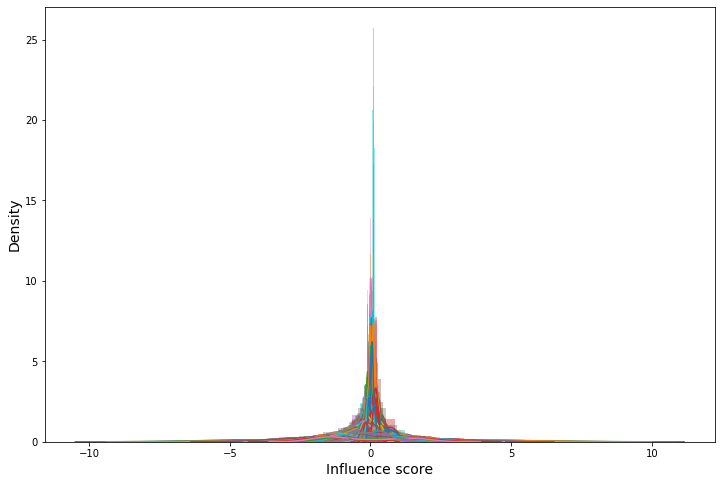

CPU times: user 25.1 s, sys: 360 ms, total: 25.4 s
Wall time: 25.4 s


In [31]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in range(influence_matrix.shape[1]):
    sns.distplot(influence_matrix[:,i], ax=ax)
# plt.title('Distributuion of influence per feature dim')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/feat_influence_dist_all.png', bbox_inches='tight')
plt.show()

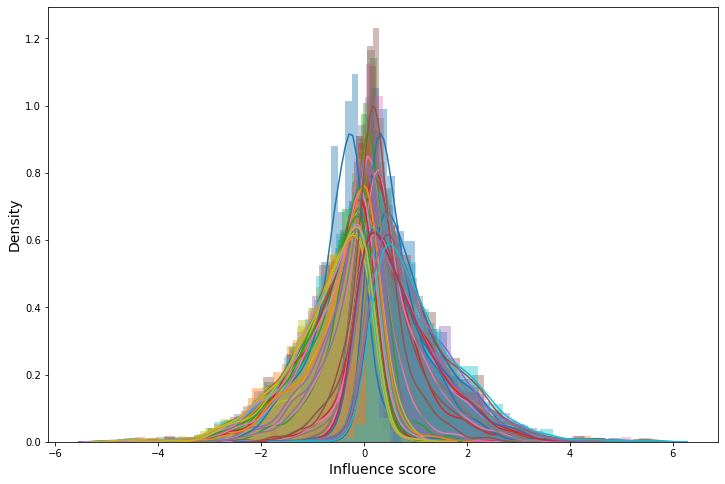

CPU times: user 7.71 s, sys: 43.7 ms, total: 7.75 s
Wall time: 7.73 s


In [32]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in range(influence_matrix.shape[0]):
    sns.distplot(influence_matrix[i,:], ax=ax)
# plt.title('Distributuion of influence per validation sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/valid_influence_dist_all.png', bbox_inches='tight')
plt.show()

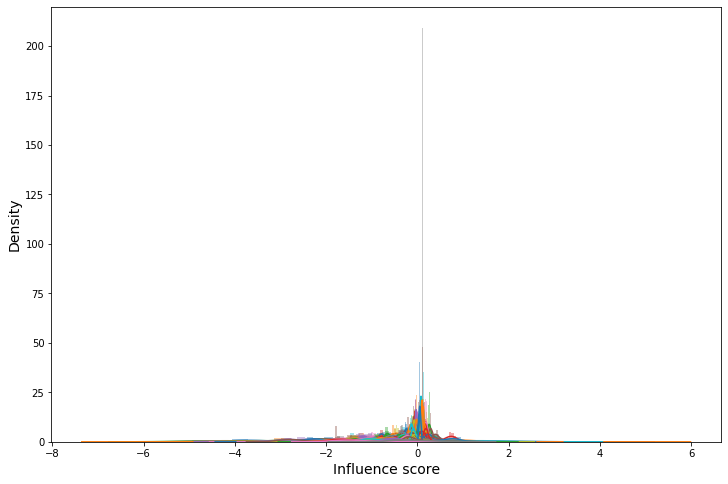

CPU times: user 38.1 s, sys: 210 ms, total: 38.3 s
Wall time: 38.3 s


In [33]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in range(influence_matrix.shape[1]):
    sns.distplot(influence_matrix[list(map(lambda x: id2idx[x], incorrect_list)),i], ax=ax)
# plt.title('Distributuion of influence per training sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/incorrect_feat_influence_dist_all.png', bbox_inches='tight')
plt.show()

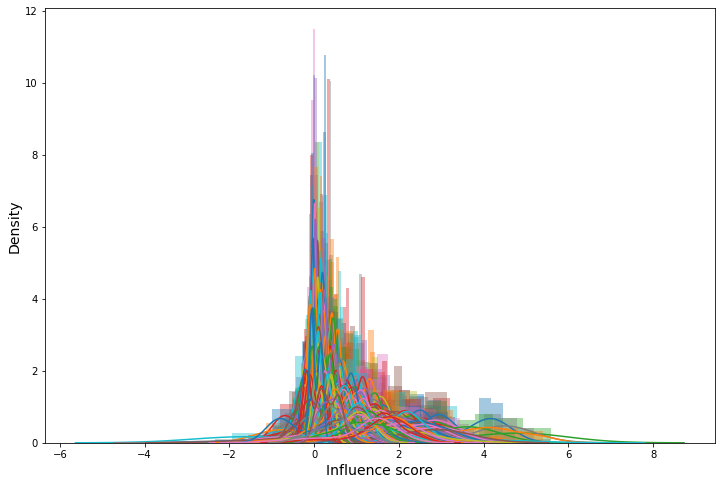

CPU times: user 29.5 s, sys: 100 ms, total: 29.6 s
Wall time: 29.5 s


In [34]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in range(influence_matrix.shape[1]):
    sns.distplot(influence_matrix[list(map(lambda x: id2idx[x], correct_list)),i], ax=ax)
# plt.title('Distributuion of influence per training sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/correct_feat_influence_dist_all.png', bbox_inches='tight')
plt.show()

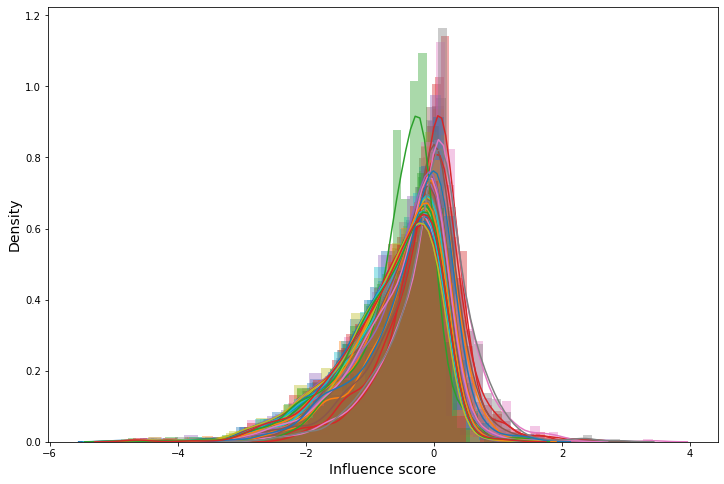

CPU times: user 4.97 s, sys: 23.8 ms, total: 5 s
Wall time: 4.99 s


In [35]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in list(map(lambda x: id2idx[x], incorrect_list)):
    sns.distplot(influence_matrix[i,:], ax=ax)
# plt.title('Distributuion of influence per validation sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/incorrect_valid_influence_dist_all.png', bbox_inches='tight')
plt.show()

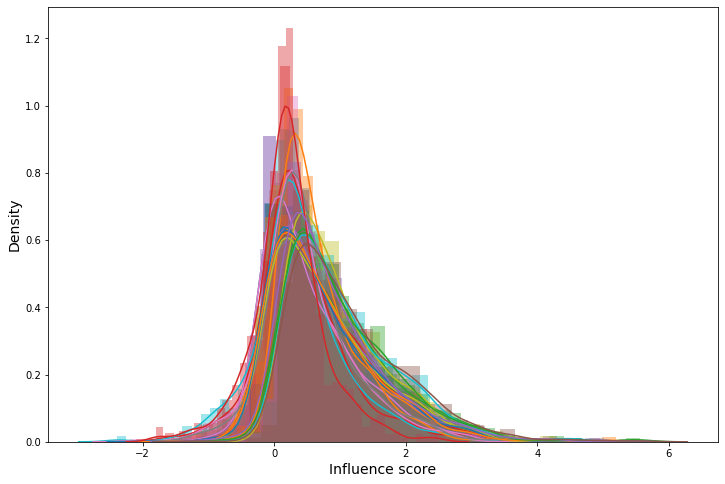

CPU times: user 3.55 s, sys: 7.77 ms, total: 3.56 s
Wall time: 3.54 s


In [36]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in list(map(lambda x: id2idx[x], correct_list)):
    sns.distplot(influence_matrix[i,:], ax=ax)
# plt.title('Distributuion of influence per validation sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/correct_valid_influence_dist_all.png', bbox_inches='tight')
plt.show()

## Test Reevaluate Hessian

In [40]:
pd.DataFrame(influence_matrix.mean(axis=0)).describe(np.arange(0.0, 1.0, 0.05))

,0
count,7.680000e+02
mean,1.420267e-07
std,1.600740e-01
min,-6.545171e-01
0%,-6.545171e-01
5%,-2.786303e-01
10%,-2.014682e-01
15%,-1.384395e-01
20%,-1.179187e-01
25%,-8.237682e-02


In [42]:
df = pd.DataFrame(influence_matrix.mean(axis=0)).sort_values(0)

In [43]:
def forward_with_feat_mask(model, feat_mask, batch_data, i2w, device='cpu'):
    # Unpack batch data
    if len(batch_data) == 4:
        (ids, subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 5:
        (ids, subword_batch, mask_batch, token_type_batch, label_batch) = batch_data
    
    # Prepare input & label
    subword = torch.LongTensor(subword_batch)
    attn_mask = torch.FloatTensor(mask_batch)
    label = torch.LongTensor(label_batch)

    if device == "cuda":
        subword = subword.cuda()
        attn_mask = attn_mask.cuda()
        label = label.cuda()

    if isinstance(model, RobertaForSequenceClassification):
        # Calculate latents
        latents = model.roberta(subword, attention_mask=attn_mask)[0][:,0,:]
        latents = model.classifier.dense(latents)
        
        # Compute prediction with feat_mask
        mask = torch.ones_like(latents, device=device)
        mask[:,feat_mask] = 0

        filt_latents = torch.tanh(latents) * mask
        logits = model.classifier.out_proj(filt_latents)
        loss = CrossEntropyLoss()(logits.view(-1, model.num_labels), label.view(-1))            
    else:
        raise NotImplementedError(f'Model class `{type(model)}` is not implemented yet')

    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])
        
    return loss, list_hyp, list_label, logits, label_batch

In [48]:
# Selective masking
model.eval()
torch.set_grad_enabled(False)
for k in range(0, 764, 50):
    print(f'== top-k : {k} ==')
    feat_mask = list(df.head(k).index)
    
    # Test on Indian
    total_loss = 0
    list_hyp, list_label = [], []
    for i, batch_data in enumerate(test_loader):
        batch_seq = batch_data[-1]
        outputs = forward_with_feat_mask(model, feat_mask, batch_data[:-1], i2w=i2w, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Calculate total loss
        total_loss += loss.item()

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label

    eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
    fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
    for key in fake_metrics.keys():
        eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
    real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
    for key in real_metrics.keys():
        eval_metrics[f'REAL_{key}'] = real_metrics[key]

    print(f'INDIAN TEST RESULT: {metrics_to_string(eval_metrics)}')
    
    # Test on YEJIN
    total_loss = 0
    list_hyp, list_label = [], []
    for i, batch_data in enumerate(test_zero_loader):
        batch_seq = batch_data[-1]
        outputs = forward_with_feat_mask(model, feat_mask, batch_data[:-1], i2w=i2w, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Calculate total loss
        total_loss += loss.item()

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label

    eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
    fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
    for key in fake_metrics.keys():
        eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
    real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
    for key in real_metrics.keys():
        eval_metrics[f'REAL_{key}'] = real_metrics[key]

    print(f'YEJIN TEST RESULT: {metrics_to_string(eval_metrics)}')

== top-k : 0 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9827 F1:0.9827 REC:0.9824 PRE:0.9830 FAKE_ACC:0.9827 FAKE_F1:0.9817 FAKE_REC:0.9755 FAKE_PRE:0.9881 REAL_ACC:0.9827 REAL_F1:0.9836 REAL_REC:0.9893 REAL_PRE:0.9779
YEJIN TEST RESULT: ACC:0.4135 F1:0.4101 REC:0.6039 PRE:0.6358 FAKE_ACC:0.4135 FAKE_F1:0.4549 FAKE_REC:0.9831 FAKE_PRE:0.2959 REAL_ACC:0.4135 REAL_F1:0.3653 REAL_REC:0.2247 REAL_PRE:0.9756
== top-k : 50 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9808 F1:0.9808 REC:0.9804 PRE:0.9813 FAKE_ACC:0.9808 FAKE_F1:0.9797 FAKE_REC:0.9706 FAKE_PRE:0.9890 REAL_ACC:0.9808 REAL_F1:0.9819 REAL_REC:0.9902 REAL_PRE:0.9737
YEJIN TEST RESULT: ACC:0.4177 F1:0.4147 REC:0.6067 PRE:0.6368 FAKE_ACC:0.4177 FAKE_F1:0.4567 FAKE_REC:0.9831 FAKE_PRE:0.2974 REAL_ACC:0.4177 REAL_F1:0.3727 REAL_REC:0.2303 REAL_PRE:0.9762
== top-k : 100 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9808 F1:0.9808 REC:0.9803 PRE:0.9814 FAKE_ACC:0.9808 FAKE_F1:0.9797 FAKE_REC:0.9696 FAKE_PRE:0.9900 REAL_ACC:0.9808 REAL_F1:0.9819 REAL_REC:0.9911 REAL_PRE:0.9728
YEJIN TEST RESULT: ACC:0.4262 F1:0.4239 REC:0.6123 PRE:0.6389 FAKE_ACC:0.4262 FAKE_F1:0.4603 FAKE_REC:0.9831 FAKE_PRE:0.3005 REAL_ACC:0.4262 REAL_F1:0.3874 REAL_REC:0.2416 REAL_PRE:0.9773
== top-k : 150 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9808 F1:0.9808 REC:0.9803 PRE:0.9816 FAKE_ACC:0.9808 FAKE_F1:0.9797 FAKE_REC:0.9676 FAKE_PRE:0.9920 REAL_ACC:0.9808 REAL_F1:0.9819 REAL_REC:0.9929 REAL_PRE:0.9712
YEJIN TEST RESULT: ACC:0.4388 F1:0.4374 REC:0.6207 PRE:0.6420 FAKE_ACC:0.4388 FAKE_F1:0.4659 FAKE_REC:0.9831 FAKE_PRE:0.3053 REAL_ACC:0.4388 REAL_F1:0.4089 REAL_REC:0.2584 REAL_PRE:0.9787
== top-k : 200 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9799 F1:0.9798 REC:0.9792 PRE:0.9808 FAKE_ACC:0.9799 FAKE_F1:0.9786 FAKE_REC:0.9647 FAKE_PRE:0.9929 REAL_ACC:0.9799 REAL_F1:0.9810 REAL_REC:0.9938 REAL_PRE:0.9687
YEJIN TEST RESULT: ACC:0.4515 F1:0.4507 REC:0.6292 PRE:0.6451 FAKE_ACC:0.4515 FAKE_F1:0.4715 FAKE_REC:0.9831 FAKE_PRE:0.3102 REAL_ACC:0.4515 REAL_F1:0.4298 REAL_REC:0.2753 REAL_PRE:0.9800
== top-k : 250 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9780 F1:0.9780 REC:0.9773 PRE:0.9791 FAKE_ACC:0.9780 FAKE_F1:0.9766 FAKE_REC:0.9608 FAKE_PRE:0.9929 REAL_ACC:0.9780 REAL_F1:0.9793 REAL_REC:0.9938 REAL_PRE:0.9653
YEJIN TEST RESULT: ACC:0.4599 F1:0.4594 REC:0.6348 PRE:0.6471 FAKE_ACC:0.4599 FAKE_F1:0.4754 FAKE_REC:0.9831 FAKE_PRE:0.3135 REAL_ACC:0.4599 REAL_F1:0.4435 REAL_REC:0.2865 REAL_PRE:0.9808
== top-k : 300 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9757 F1:0.9756 REC:0.9748 PRE:0.9770 FAKE_ACC:0.9757 FAKE_F1:0.9740 FAKE_REC:0.9559 FAKE_PRE:0.9929 REAL_ACC:0.9757 REAL_F1:0.9772 REAL_REC:0.9938 REAL_PRE:0.9611
YEJIN TEST RESULT: ACC:0.4684 F1:0.4681 REC:0.6404 PRE:0.6492 FAKE_ACC:0.4684 FAKE_F1:0.4793 FAKE_REC:0.9831 FAKE_PRE:0.3169 REAL_ACC:0.4684 REAL_F1:0.4569 REAL_REC:0.2978 REAL_PRE:0.9815
== top-k : 350 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9743 F1:0.9742 REC:0.9733 PRE:0.9759 FAKE_ACC:0.9743 FAKE_F1:0.9725 FAKE_REC:0.9520 FAKE_PRE:0.9939 REAL_ACC:0.9743 REAL_F1:0.9759 REAL_REC:0.9946 REAL_PRE:0.9579
YEJIN TEST RESULT: ACC:0.4768 F1:0.4767 REC:0.6460 PRE:0.6513 FAKE_ACC:0.4768 FAKE_F1:0.4833 FAKE_REC:0.9831 FAKE_PRE:0.3204 REAL_ACC:0.4768 REAL_F1:0.4701 REAL_REC:0.3090 REAL_PRE:0.9821
== top-k : 400 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9724 F1:0.9723 REC:0.9713 PRE:0.9743 FAKE_ACC:0.9724 FAKE_F1:0.9704 FAKE_REC:0.9471 FAKE_PRE:0.9949 REAL_ACC:0.9724 REAL_F1:0.9742 REAL_REC:0.9955 REAL_PRE:0.9538
YEJIN TEST RESULT: ACC:0.4937 F1:0.4937 REC:0.6573 PRE:0.6555 FAKE_ACC:0.4937 FAKE_F1:0.4915 FAKE_REC:0.9831 FAKE_PRE:0.3277 REAL_ACC:0.4937 REAL_F1:0.4958 REAL_REC:0.3315 REAL_PRE:0.9833
== top-k : 450 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9720 F1:0.9718 REC:0.9708 PRE:0.9739 FAKE_ACC:0.9720 FAKE_F1:0.9698 FAKE_REC:0.9461 FAKE_PRE:0.9948 REAL_ACC:0.9720 REAL_F1:0.9738 REAL_REC:0.9955 REAL_PRE:0.9530
YEJIN TEST RESULT: ACC:0.4937 F1:0.4937 REC:0.6573 PRE:0.6555 FAKE_ACC:0.4937 FAKE_F1:0.4915 FAKE_REC:0.9831 FAKE_PRE:0.3277 REAL_ACC:0.4937 REAL_F1:0.4958 REAL_REC:0.3315 REAL_PRE:0.9833
== top-k : 500 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9710 F1:0.9709 REC:0.9698 PRE:0.9732 FAKE_ACC:0.9710 FAKE_F1:0.9688 FAKE_REC:0.9431 FAKE_PRE:0.9959 REAL_ACC:0.9710 REAL_F1:0.9730 REAL_REC:0.9964 REAL_PRE:0.9506
YEJIN TEST RESULT: ACC:0.5021 F1:0.5020 REC:0.6629 PRE:0.6576 FAKE_ACC:0.5021 FAKE_F1:0.4957 FAKE_REC:0.9831 FAKE_PRE:0.3314 REAL_ACC:0.5021 REAL_F1:0.5083 REAL_REC:0.3427 REAL_PRE:0.9839
== top-k : 550 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9678 F1:0.9676 REC:0.9664 PRE:0.9704 FAKE_ACC:0.9678 FAKE_F1:0.9651 FAKE_REC:0.9363 FAKE_PRE:0.9958 REAL_ACC:0.9678 REAL_F1:0.9700 REAL_REC:0.9964 REAL_PRE:0.9450
YEJIN TEST RESULT: ACC:0.5021 F1:0.5020 REC:0.6629 PRE:0.6576 FAKE_ACC:0.5021 FAKE_F1:0.4957 FAKE_REC:0.9831 FAKE_PRE:0.3314 REAL_ACC:0.5021 REAL_F1:0.5083 REAL_REC:0.3427 REAL_PRE:0.9839
== top-k : 600 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9654 F1:0.9652 REC:0.9639 PRE:0.9684 FAKE_ACC:0.9654 FAKE_F1:0.9625 FAKE_REC:0.9314 FAKE_PRE:0.9958 REAL_ACC:0.9654 REAL_F1:0.9679 REAL_REC:0.9964 REAL_PRE:0.9410
YEJIN TEST RESULT: ACC:0.5105 F1:0.5103 REC:0.6685 PRE:0.6598 FAKE_ACC:0.5105 FAKE_F1:0.5000 FAKE_REC:0.9831 FAKE_PRE:0.3353 REAL_ACC:0.5105 REAL_F1:0.5207 REAL_REC:0.3539 REAL_PRE:0.9844
== top-k : 650 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9636 F1:0.9633 REC:0.9619 PRE:0.9670 FAKE_ACC:0.9636 FAKE_F1:0.9604 FAKE_REC:0.9265 FAKE_PRE:0.9968 REAL_ACC:0.9636 REAL_F1:0.9663 REAL_REC:0.9973 REAL_PRE:0.9371
YEJIN TEST RESULT: ACC:0.5232 F1:0.5220 REC:0.6656 PRE:0.6475 FAKE_ACC:0.5232 FAKE_F1:0.4978 FAKE_REC:0.9492 FAKE_PRE:0.3373 REAL_ACC:0.5232 REAL_F1:0.5462 REAL_REC:0.3820 REAL_PRE:0.9577
== top-k : 700 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9621 F1:0.9619 REC:0.9604 PRE:0.9658 FAKE_ACC:0.9621 FAKE_F1:0.9588 FAKE_REC:0.9235 FAKE_PRE:0.9968 REAL_ACC:0.9621 REAL_F1:0.9650 REAL_REC:0.9973 REAL_PRE:0.9347
YEJIN TEST RESULT: ACC:0.5316 F1:0.5300 REC:0.6712 PRE:0.6502 FAKE_ACC:0.5316 FAKE_F1:0.5022 FAKE_REC:0.9492 FAKE_PRE:0.3415 REAL_ACC:0.5316 REAL_F1:0.5578 REAL_REC:0.3933 REAL_PRE:0.9589
== top-k : 750 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9467 F1:0.9462 REC:0.9442 PRE:0.9532 FAKE_ACC:0.9467 FAKE_F1:0.9410 FAKE_REC:0.8912 FAKE_PRE:0.9967 REAL_ACC:0.9467 REAL_F1:0.9514 REAL_REC:0.9973 REAL_PRE:0.9096
YEJIN TEST RESULT: ACC:0.5992 F1:0.5926 REC:0.7161 PRE:0.6723 FAKE_ACC:0.5992 FAKE_F1:0.5411 FAKE_REC:0.9492 FAKE_PRE:0.3784 REAL_ACC:0.5992 REAL_F1:0.6442 REAL_REC:0.4831 REAL_PRE:0.9663


In [54]:
# Random masking
model.eval()
torch.set_grad_enabled(False)
for k in range(0, 764, 50):
    print(f'== top-k : {k} ==')
    feat_mask = np.random.choice(np.arange(0,764), k, replace=False)
    
    # Test on Indian
    total_loss = 0
    list_hyp, list_label = [], []
    for i, batch_data in enumerate(test_loader):
        batch_seq = batch_data[-1]
        outputs = forward_with_feat_mask(model, feat_mask, batch_data[:-1], i2w=i2w, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Calculate total loss
        total_loss += loss.item()

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label

    eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
    fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
    for key in fake_metrics.keys():
        eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
    real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
    for key in real_metrics.keys():
        eval_metrics[f'REAL_{key}'] = real_metrics[key]

    print(f'INDIAN TEST RESULT: {metrics_to_string(eval_metrics)}')
    
    # Test on YEJIN
    total_loss = 0
    list_hyp, list_label = [], []
    for i, batch_data in enumerate(test_zero_loader):
        batch_seq = batch_data[-1]
        outputs = forward_with_feat_mask(model, feat_mask, batch_data[:-1], i2w=i2w, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Calculate total loss
        total_loss += loss.item()

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label

    eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
    fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
    for key in fake_metrics.keys():
        eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
    real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
    for key in real_metrics.keys():
        eval_metrics[f'REAL_{key}'] = real_metrics[key]

    print(f'YEJIN TEST RESULT: {metrics_to_string(eval_metrics)}')

== top-k : 0 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9827 F1:0.9827 REC:0.9824 PRE:0.9830 FAKE_ACC:0.9827 FAKE_F1:0.9817 FAKE_REC:0.9755 FAKE_PRE:0.9881 REAL_ACC:0.9827 REAL_F1:0.9836 REAL_REC:0.9893 REAL_PRE:0.9779
YEJIN TEST RESULT: ACC:0.4135 F1:0.4101 REC:0.6039 PRE:0.6358 FAKE_ACC:0.4135 FAKE_F1:0.4549 FAKE_REC:0.9831 FAKE_PRE:0.2959 REAL_ACC:0.4135 REAL_F1:0.3653 REAL_REC:0.2247 REAL_PRE:0.9756
== top-k : 50 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9827 F1:0.9827 REC:0.9824 PRE:0.9830 FAKE_ACC:0.9827 FAKE_F1:0.9817 FAKE_REC:0.9755 FAKE_PRE:0.9881 REAL_ACC:0.9827 REAL_F1:0.9836 REAL_REC:0.9893 REAL_PRE:0.9779
YEJIN TEST RESULT: ACC:0.4135 F1:0.4101 REC:0.6039 PRE:0.6358 FAKE_ACC:0.4135 FAKE_F1:0.4549 FAKE_REC:0.9831 FAKE_PRE:0.2959 REAL_ACC:0.4135 REAL_F1:0.3653 REAL_REC:0.2247 REAL_PRE:0.9756
== top-k : 100 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9827 F1:0.9827 REC:0.9824 PRE:0.9830 FAKE_ACC:0.9827 FAKE_F1:0.9817 FAKE_REC:0.9755 FAKE_PRE:0.9881 REAL_ACC:0.9827 REAL_F1:0.9836 REAL_REC:0.9893 REAL_PRE:0.9779
YEJIN TEST RESULT: ACC:0.4135 F1:0.4101 REC:0.6039 PRE:0.6358 FAKE_ACC:0.4135 FAKE_F1:0.4549 FAKE_REC:0.9831 FAKE_PRE:0.2959 REAL_ACC:0.4135 REAL_F1:0.3653 REAL_REC:0.2247 REAL_PRE:0.9756
== top-k : 150 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9822 F1:0.9822 REC:0.9819 PRE:0.9825 FAKE_ACC:0.9822 FAKE_F1:0.9813 FAKE_REC:0.9755 FAKE_PRE:0.9871 REAL_ACC:0.9822 REAL_F1:0.9831 REAL_REC:0.9884 REAL_PRE:0.9779
YEJIN TEST RESULT: ACC:0.4135 F1:0.4101 REC:0.6039 PRE:0.6358 FAKE_ACC:0.4135 FAKE_F1:0.4549 FAKE_REC:0.9831 FAKE_PRE:0.2959 REAL_ACC:0.4135 REAL_F1:0.3653 REAL_REC:0.2247 REAL_PRE:0.9756
== top-k : 200 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9822 F1:0.9822 REC:0.9819 PRE:0.9825 FAKE_ACC:0.9822 FAKE_F1:0.9813 FAKE_REC:0.9755 FAKE_PRE:0.9871 REAL_ACC:0.9822 REAL_F1:0.9831 REAL_REC:0.9884 REAL_PRE:0.9779
YEJIN TEST RESULT: ACC:0.4135 F1:0.4101 REC:0.6039 PRE:0.6358 FAKE_ACC:0.4135 FAKE_F1:0.4549 FAKE_REC:0.9831 FAKE_PRE:0.2959 REAL_ACC:0.4135 REAL_F1:0.3653 REAL_REC:0.2247 REAL_PRE:0.9756
== top-k : 250 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9818 F1:0.9817 REC:0.9815 PRE:0.9821 FAKE_ACC:0.9818 FAKE_F1:0.9808 FAKE_REC:0.9745 FAKE_PRE:0.9871 REAL_ACC:0.9818 REAL_F1:0.9827 REAL_REC:0.9884 REAL_PRE:0.9771
YEJIN TEST RESULT: ACC:0.4135 F1:0.4101 REC:0.6039 PRE:0.6358 FAKE_ACC:0.4135 FAKE_F1:0.4549 FAKE_REC:0.9831 FAKE_PRE:0.2959 REAL_ACC:0.4135 REAL_F1:0.3653 REAL_REC:0.2247 REAL_PRE:0.9756
== top-k : 300 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9827 F1:0.9827 REC:0.9824 PRE:0.9830 FAKE_ACC:0.9827 FAKE_F1:0.9817 FAKE_REC:0.9755 FAKE_PRE:0.9881 REAL_ACC:0.9827 REAL_F1:0.9836 REAL_REC:0.9893 REAL_PRE:0.9779
YEJIN TEST RESULT: ACC:0.4093 F1:0.4055 REC:0.6011 PRE:0.6347 FAKE_ACC:0.4093 FAKE_F1:0.4531 FAKE_REC:0.9831 FAKE_PRE:0.2944 REAL_ACC:0.4093 REAL_F1:0.3578 REAL_REC:0.2191 REAL_PRE:0.9750
== top-k : 350 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9822 F1:0.9822 REC:0.9819 PRE:0.9825 FAKE_ACC:0.9822 FAKE_F1:0.9813 FAKE_REC:0.9755 FAKE_PRE:0.9871 REAL_ACC:0.9822 REAL_F1:0.9831 REAL_REC:0.9884 REAL_PRE:0.9779
YEJIN TEST RESULT: ACC:0.4051 F1:0.4008 REC:0.5983 PRE:0.6336 FAKE_ACC:0.4051 FAKE_F1:0.4514 FAKE_REC:0.9831 FAKE_PRE:0.2929 REAL_ACC:0.4051 REAL_F1:0.3502 REAL_REC:0.2135 REAL_PRE:0.9744
== top-k : 400 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9822 F1:0.9822 REC:0.9819 PRE:0.9825 FAKE_ACC:0.9822 FAKE_F1:0.9813 FAKE_REC:0.9755 FAKE_PRE:0.9871 REAL_ACC:0.9822 REAL_F1:0.9831 REAL_REC:0.9884 REAL_PRE:0.9779
YEJIN TEST RESULT: ACC:0.4093 F1:0.4055 REC:0.6011 PRE:0.6347 FAKE_ACC:0.4093 FAKE_F1:0.4531 FAKE_REC:0.9831 FAKE_PRE:0.2944 REAL_ACC:0.4093 REAL_F1:0.3578 REAL_REC:0.2191 REAL_PRE:0.9750
== top-k : 450 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9813 F1:0.9813 REC:0.9810 PRE:0.9816 FAKE_ACC:0.9813 FAKE_F1:0.9803 FAKE_REC:0.9735 FAKE_PRE:0.9871 REAL_ACC:0.9813 REAL_F1:0.9823 REAL_REC:0.9884 REAL_PRE:0.9762
YEJIN TEST RESULT: ACC:0.4135 F1:0.4101 REC:0.6039 PRE:0.6358 FAKE_ACC:0.4135 FAKE_F1:0.4549 FAKE_REC:0.9831 FAKE_PRE:0.2959 REAL_ACC:0.4135 REAL_F1:0.3653 REAL_REC:0.2247 REAL_PRE:0.9756
== top-k : 500 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9832 F1:0.9831 REC:0.9828 PRE:0.9835 FAKE_ACC:0.9832 FAKE_F1:0.9822 FAKE_REC:0.9755 FAKE_PRE:0.9891 REAL_ACC:0.9832 REAL_F1:0.9840 REAL_REC:0.9902 REAL_PRE:0.9780
YEJIN TEST RESULT: ACC:0.4093 F1:0.4055 REC:0.6011 PRE:0.6347 FAKE_ACC:0.4093 FAKE_F1:0.4531 FAKE_REC:0.9831 FAKE_PRE:0.2944 REAL_ACC:0.4093 REAL_F1:0.3578 REAL_REC:0.2191 REAL_PRE:0.9750
== top-k : 550 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9822 F1:0.9822 REC:0.9819 PRE:0.9825 FAKE_ACC:0.9822 FAKE_F1:0.9813 FAKE_REC:0.9755 FAKE_PRE:0.9871 REAL_ACC:0.9822 REAL_F1:0.9831 REAL_REC:0.9884 REAL_PRE:0.9779
YEJIN TEST RESULT: ACC:0.4135 F1:0.4101 REC:0.6039 PRE:0.6358 FAKE_ACC:0.4135 FAKE_F1:0.4549 FAKE_REC:0.9831 FAKE_PRE:0.2959 REAL_ACC:0.4135 REAL_F1:0.3653 REAL_REC:0.2247 REAL_PRE:0.9756
== top-k : 600 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9827 F1:0.9827 REC:0.9825 PRE:0.9829 FAKE_ACC:0.9827 FAKE_F1:0.9818 FAKE_REC:0.9775 FAKE_PRE:0.9862 REAL_ACC:0.9827 REAL_F1:0.9835 REAL_REC:0.9875 REAL_PRE:0.9796
YEJIN TEST RESULT: ACC:0.3924 F1:0.3866 REC:0.5898 PRE:0.6304 FAKE_ACC:0.3924 FAKE_F1:0.4462 FAKE_REC:0.9831 FAKE_PRE:0.2886 REAL_ACC:0.3924 REAL_F1:0.3271 REAL_REC:0.1966 REAL_PRE:0.9722
== top-k : 650 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9822 F1:0.9822 REC:0.9819 PRE:0.9825 FAKE_ACC:0.9822 FAKE_F1:0.9813 FAKE_REC:0.9755 FAKE_PRE:0.9871 REAL_ACC:0.9822 REAL_F1:0.9831 REAL_REC:0.9884 REAL_PRE:0.9779
YEJIN TEST RESULT: ACC:0.4093 F1:0.4055 REC:0.6011 PRE:0.6347 FAKE_ACC:0.4093 FAKE_F1:0.4531 FAKE_REC:0.9831 FAKE_PRE:0.2944 REAL_ACC:0.4093 REAL_F1:0.3578 REAL_REC:0.2191 REAL_PRE:0.9750
== top-k : 700 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9822 F1:0.9822 REC:0.9819 PRE:0.9826 FAKE_ACC:0.9822 FAKE_F1:0.9812 FAKE_REC:0.9735 FAKE_PRE:0.9890 REAL_ACC:0.9822 REAL_F1:0.9832 REAL_REC:0.9902 REAL_PRE:0.9762
YEJIN TEST RESULT: ACC:0.4093 F1:0.4055 REC:0.6011 PRE:0.6347 FAKE_ACC:0.4093 FAKE_F1:0.4531 FAKE_REC:0.9831 FAKE_PRE:0.2944 REAL_ACC:0.4093 REAL_F1:0.3578 REAL_REC:0.2191 REAL_PRE:0.9750
== top-k : 750 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9818 F1:0.9817 REC:0.9815 PRE:0.9820 FAKE_ACC:0.9818 FAKE_F1:0.9808 FAKE_REC:0.9755 FAKE_PRE:0.9861 REAL_ACC:0.9818 REAL_F1:0.9827 REAL_REC:0.9875 REAL_PRE:0.9779
YEJIN TEST RESULT: ACC:0.3966 F1:0.3914 REC:0.5926 PRE:0.6315 FAKE_ACC:0.3966 FAKE_F1:0.4479 FAKE_REC:0.9831 FAKE_PRE:0.2900 REAL_ACC:0.3966 REAL_F1:0.3349 REAL_REC:0.2022 REAL_PRE:0.9730


# Influence score with Baseline model

In [20]:
%%time
model = model.cuda().eval()
model.load_state_dict(torch.load('./tmp_hessian/baseline_model_weight.pt'))

CPU times: user 108 ms, sys: 288 ms, total: 396 ms
Wall time: 390 ms


<All keys matched successfully>

In [21]:
%%time
influence_matrix = build_influence_matrix(model, valid_zero_loader, model.classifier.dense.weight.shape[0], device='cuda')

  1%|          | 4/768 [00:00<00:20, 36.99it/s]

Processing batch 1/8


  1%|          | 5/768 [00:00<00:17, 42.98it/s]

Processing batch 2/8


  1%|          | 5/768 [00:00<00:15, 47.71it/s]

Processing batch 3/8


  1%|          | 5/768 [00:00<00:17, 42.52it/s]

Processing batch 4/8


  1%|          | 5/768 [00:00<00:17, 42.96it/s]

Processing batch 5/8


  1%|          | 5/768 [00:00<00:17, 43.47it/s]

Processing batch 6/8


  1%|          | 5/768 [00:00<00:17, 44.87it/s]

Processing batch 7/8


  1%|          | 7/768 [00:00<00:11, 66.54it/s]

Processing batch 8/8


100%|██████████| 768/768 [00:10<00:00, 70.87it/s]


CPU times: user 2min 5s, sys: 13.7 s, total: 2min 19s
Wall time: 2min 18s


In [22]:
influence_matrix = influence_matrix.cpu().numpy()
np.save('./tmp_hessian/influence_matrix_baseline.npy', influence_matrix)

## Analyse influence

In [23]:
%%time
model = model.cuda()
results = get_inference_result(model, valid_zero_loader, device='cuda') # Return map of ID -> status
correct_list = list(map(lambda kv: kv[0], filter(lambda kv: kv[1], results.items())))
incorrect_list = list(map(lambda kv: kv[0], filter(lambda kv: not kv[1], results.items())))

100%|██████████| 8/8 [00:00<00:00, 10.15it/s]

CPU times: user 222 ms, sys: 481 ms, total: 703 ms
Wall time: 798 ms


## Quantitative analysis influence

In [24]:
influence_matrix = np.load('./tmp_hessian/influence_matrix_baseline.npy', allow_pickle=True)
influence_matrix = ((influence_matrix - influence_matrix.mean()) / influence_matrix.std())

In [25]:
idx2id = valid_zero_loader.dataset.data['id'].to_dict()
id2idx = {v:k for k,v in idx2id.items()}

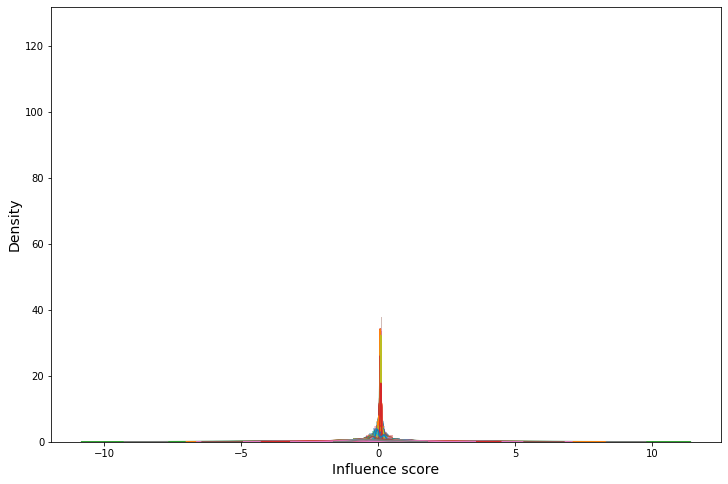

CPU times: user 21.4 s, sys: 206 ms, total: 21.6 s
Wall time: 21.6 s


In [26]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in range(influence_matrix.shape[1]):
    sns.distplot(influence_matrix[:,i], ax=ax)
# plt.title('Distributuion of influence per feature dim')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/feat_influence_dist_all_baseline.png', bbox_inches='tight')
plt.show()

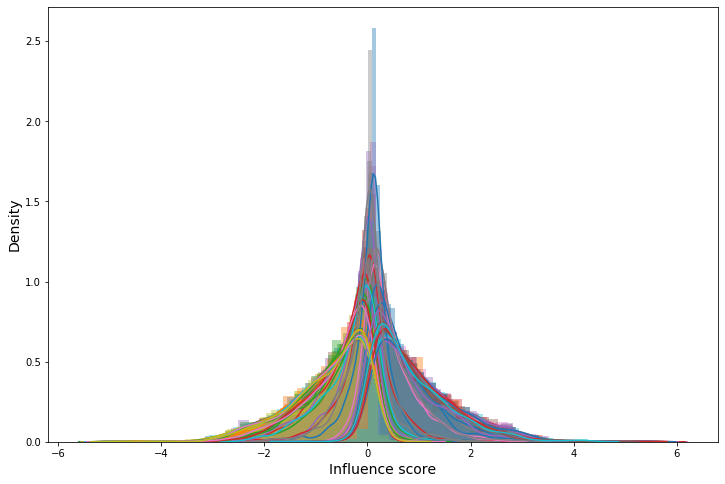

CPU times: user 7.44 s, sys: 39.2 ms, total: 7.47 s
Wall time: 7.46 s


In [27]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in range(influence_matrix.shape[0]):
    sns.distplot(influence_matrix[i,:], ax=ax)
# plt.title('Distributuion of influence per validation sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/valid_influence_dist_al_baselinel.png', bbox_inches='tight')
plt.show()

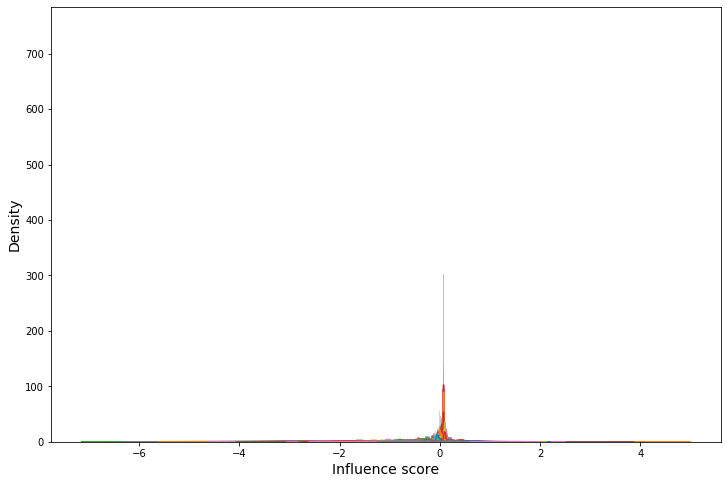

CPU times: user 33.5 s, sys: 152 ms, total: 33.6 s
Wall time: 33.6 s


In [28]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in range(influence_matrix.shape[1]):
    sns.distplot(influence_matrix[list(map(lambda x: id2idx[x], incorrect_list)),i], ax=ax)
# plt.title('Distributuion of influence per training sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/incorrect_feat_influence_dist_all_baseline.png', bbox_inches='tight')
plt.show()

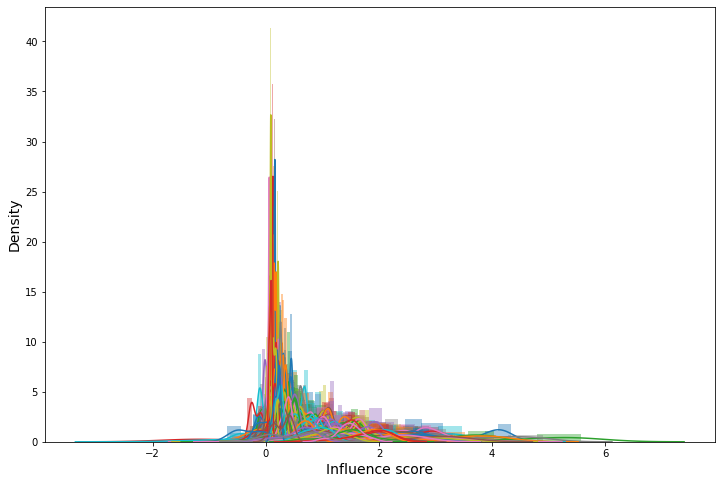

CPU times: user 24 s, sys: 81.5 ms, total: 24 s
Wall time: 24 s


In [29]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in range(influence_matrix.shape[1]):
    sns.distplot(influence_matrix[list(map(lambda x: id2idx[x], correct_list)),i], ax=ax)
# plt.title('Distributuion of influence per training sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/correct_feat_influence_dist_all_baseline.png', bbox_inches='tight')
plt.show()

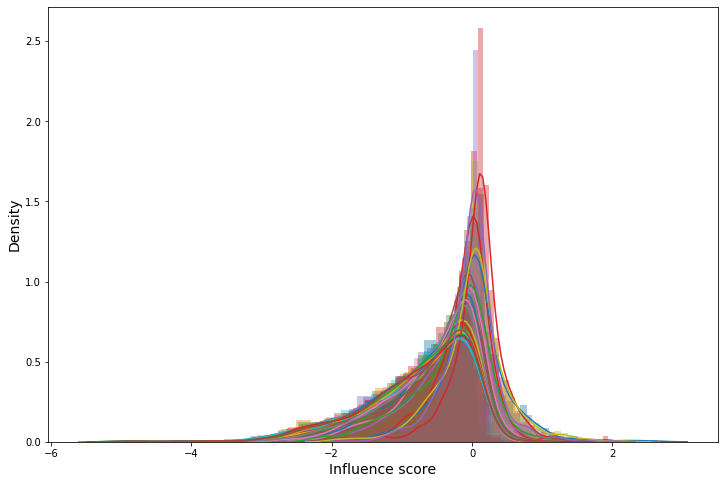

CPU times: user 4.7 s, sys: 35.4 ms, total: 4.74 s
Wall time: 4.73 s


In [30]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in list(map(lambda x: id2idx[x], incorrect_list)):
    sns.distplot(influence_matrix[i,:], ax=ax)
# plt.title('Distributuion of influence per validation sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/incorrect_valid_influence_dist_all_baseline.png', bbox_inches='tight')
plt.show()

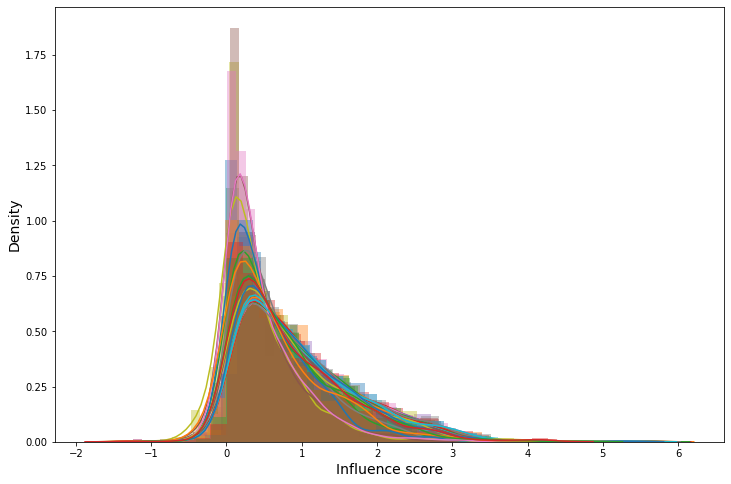

CPU times: user 3.06 s, sys: 23.5 ms, total: 3.09 s
Wall time: 3.08 s


In [31]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in list(map(lambda x: id2idx[x], correct_list)):
    sns.distplot(influence_matrix[i,:], ax=ax)
# plt.title('Distributuion of influence per validation sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/correct_valid_influence_dist_all_baseline.png', bbox_inches='tight')
plt.show()

## Test Reevaluate Baseline

In [32]:
pd.DataFrame(influence_matrix.mean(axis=0)).describe(np.arange(0.0, 1.0, 0.05))

,0
count,768.000000
mean,0.000003
std,0.134081
min,-0.581435
0%,-0.581435
5%,-0.257779
10%,-0.179872
15%,-0.132294
20%,-0.103379
25%,-0.072941


In [33]:
df = pd.DataFrame(influence_matrix.mean(axis=0)).sort_values(0)

In [34]:
def forward_with_feat_mask(model, feat_mask, batch_data, i2w, device='cpu'):
    # Unpack batch data
    if len(batch_data) == 4:
        (ids, subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 5:
        (ids, subword_batch, mask_batch, token_type_batch, label_batch) = batch_data
    
    # Prepare input & label
    subword = torch.LongTensor(subword_batch)
    attn_mask = torch.FloatTensor(mask_batch)
    label = torch.LongTensor(label_batch)

    if device == "cuda":
        subword = subword.cuda()
        attn_mask = attn_mask.cuda()
        label = label.cuda()

    if isinstance(model, RobertaForSequenceClassification):
        # Calculate latents
        latents = model.roberta(subword, attention_mask=attn_mask)[0][:,0,:]
        latents = model.classifier.dense(latents)
        
        # Compute prediction with feat_mask
        mask = torch.ones_like(latents, device=device)
        mask[:,feat_mask] = 0

        filt_latents = torch.tanh(latents) * mask
        logits = model.classifier.out_proj(filt_latents)
        loss = CrossEntropyLoss()(logits.view(-1, model.num_labels), label.view(-1))            
    else:
        raise NotImplementedError(f'Model class `{type(model)}` is not implemented yet')

    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])
        
    return loss, list_hyp, list_label, logits, label_batch

In [35]:
# Selective masking
model.eval()
torch.set_grad_enabled(False)
for k in range(0, 764, 50):
    print(f'== top-k : {k} ==')
    feat_mask = list(df.head(k).index)
    
    # Test on Indian
    total_loss = 0
    list_hyp, list_label = [], []
    for i, batch_data in enumerate(test_loader):
        batch_seq = batch_data[-1]
        outputs = forward_with_feat_mask(model, feat_mask, batch_data[:-1], i2w=i2w, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Calculate total loss
        total_loss += loss.item()

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label

    eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
    fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
    for key in fake_metrics.keys():
        eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
    real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
    for key in real_metrics.keys():
        eval_metrics[f'REAL_{key}'] = real_metrics[key]

    print(f'INDIAN TEST RESULT: {metrics_to_string(eval_metrics)}')
    
    # Test on YEJIN
    total_loss = 0
    list_hyp, list_label = [], []
    for i, batch_data in enumerate(test_zero_loader):
        batch_seq = batch_data[-1]
        outputs = forward_with_feat_mask(model, feat_mask, batch_data[:-1], i2w=i2w, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Calculate total loss
        total_loss += loss.item()

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label

    eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
    fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
    for key in fake_metrics.keys():
        eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
    real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
    for key in real_metrics.keys():
        eval_metrics[f'REAL_{key}'] = real_metrics[key]

    print(f'YEJIN TEST RESULT: {metrics_to_string(eval_metrics)}')

== top-k : 0 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9729 F1:0.9728 REC:0.9722 PRE:0.9737 FAKE_ACC:0.9729 FAKE_F1:0.9712 FAKE_REC:0.9578 FAKE_PRE:0.9849 REAL_ACC:0.9729 REAL_F1:0.9744 REAL_REC:0.9866 REAL_PRE:0.9625


/home/samuel/anaconda2/envs/env_py3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'fake') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


YEJIN TEST RESULT: ACC:0.4346 F1:0.4329 REC:0.6179 PRE:0.6410 FAKE_ACC:0.4346 FAKE_F1:0.4640 FAKE_REC:0.9831 FAKE_PRE:0.3037 REAL_ACC:0.4346 REAL_F1:0.4018 REAL_REC:0.2528 REAL_PRE:0.9783
== top-k : 50 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9720 F1:0.9719 REC:0.9712 PRE:0.9730 FAKE_ACC:0.9720 FAKE_F1:0.9701 FAKE_REC:0.9539 FAKE_PRE:0.9868 REAL_ACC:0.9720 REAL_F1:0.9736 REAL_REC:0.9884 REAL_PRE:0.9593
YEJIN TEST RESULT: ACC:0.4515 F1:0.4507 REC:0.6292 PRE:0.6451 FAKE_ACC:0.4515 FAKE_F1:0.4715 FAKE_REC:0.9831 FAKE_PRE:0.3102 REAL_ACC:0.4515 REAL_F1:0.4298 REAL_REC:0.2753 REAL_PRE:0.9800
== top-k : 100 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9720 F1:0.9718 REC:0.9711 PRE:0.9731 FAKE_ACC:0.9720 FAKE_F1:0.9701 FAKE_REC:0.9529 FAKE_PRE:0.9878 REAL_ACC:0.9720 REAL_F1:0.9736 REAL_REC:0.9893 REAL_PRE:0.9585
YEJIN TEST RESULT: ACC:0.4599 F1:0.4594 REC:0.6348 PRE:0.6471 FAKE_ACC:0.4599 FAKE_F1:0.4754 FAKE_REC:0.9831 FAKE_PRE:0.3135 REAL_ACC:0.4599 REAL_F1:0.4435 REAL_REC:0.2865 REAL_PRE:0.9808
== top-k : 150 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9710 F1:0.9709 REC:0.9701 PRE:0.9724 FAKE_ACC:0.9710 FAKE_F1:0.9690 FAKE_REC:0.9500 FAKE_PRE:0.9888 REAL_ACC:0.9710 REAL_F1:0.9728 REAL_REC:0.9902 REAL_PRE:0.9560
YEJIN TEST RESULT: ACC:0.4641 F1:0.4638 REC:0.6376 PRE:0.6482 FAKE_ACC:0.4641 FAKE_F1:0.4774 FAKE_REC:0.9831 FAKE_PRE:0.3152 REAL_ACC:0.4641 REAL_F1:0.4502 REAL_REC:0.2921 REAL_PRE:0.9811
== top-k : 200 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9701 F1:0.9700 REC:0.9690 PRE:0.9718 FAKE_ACC:0.9701 FAKE_F1:0.9679 FAKE_REC:0.9461 FAKE_PRE:0.9908 REAL_ACC:0.9701 REAL_F1:0.9720 REAL_REC:0.9920 REAL_PRE:0.9528
YEJIN TEST RESULT: ACC:0.4768 F1:0.4767 REC:0.6460 PRE:0.6513 FAKE_ACC:0.4768 FAKE_F1:0.4833 FAKE_REC:0.9831 FAKE_PRE:0.3204 REAL_ACC:0.4768 REAL_F1:0.4701 REAL_REC:0.3090 REAL_PRE:0.9821
== top-k : 250 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9687 F1:0.9685 REC:0.9676 PRE:0.9706 FAKE_ACC:0.9687 FAKE_F1:0.9663 FAKE_REC:0.9431 FAKE_PRE:0.9907 REAL_ACC:0.9687 REAL_F1:0.9707 REAL_REC:0.9920 REAL_PRE:0.9504
YEJIN TEST RESULT: ACC:0.4768 F1:0.4767 REC:0.6460 PRE:0.6513 FAKE_ACC:0.4768 FAKE_F1:0.4833 FAKE_REC:0.9831 FAKE_PRE:0.3204 REAL_ACC:0.4768 REAL_F1:0.4701 REAL_REC:0.3090 REAL_PRE:0.9821
== top-k : 300 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9678 F1:0.9676 REC:0.9666 PRE:0.9697 FAKE_ACC:0.9678 FAKE_F1:0.9653 FAKE_REC:0.9412 FAKE_PRE:0.9907 REAL_ACC:0.9678 REAL_F1:0.9699 REAL_REC:0.9920 REAL_PRE:0.9488
YEJIN TEST RESULT: ACC:0.4852 F1:0.4852 REC:0.6516 PRE:0.6534 FAKE_ACC:0.4852 FAKE_F1:0.4874 FAKE_REC:0.9831 FAKE_PRE:0.3240 REAL_ACC:0.4852 REAL_F1:0.4831 REAL_REC:0.3202 REAL_PRE:0.9828
== top-k : 350 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9659 F1:0.9657 REC:0.9646 PRE:0.9681 FAKE_ACC:0.9659 FAKE_F1:0.9632 FAKE_REC:0.9373 FAKE_PRE:0.9907 REAL_ACC:0.9659 REAL_F1:0.9682 REAL_REC:0.9920 REAL_PRE:0.9455
YEJIN TEST RESULT: ACC:0.4937 F1:0.4937 REC:0.6573 PRE:0.6555 FAKE_ACC:0.4937 FAKE_F1:0.4915 FAKE_REC:0.9831 FAKE_PRE:0.3277 REAL_ACC:0.4937 REAL_F1:0.4958 REAL_REC:0.3315 REAL_PRE:0.9833
== top-k : 400 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9650 F1:0.9648 REC:0.9636 PRE:0.9674 FAKE_ACC:0.9650 FAKE_F1:0.9621 FAKE_REC:0.9343 FAKE_PRE:0.9917 REAL_ACC:0.9650 REAL_F1:0.9674 REAL_REC:0.9929 REAL_PRE:0.9432
YEJIN TEST RESULT: ACC:0.5021 F1:0.5020 REC:0.6629 PRE:0.6576 FAKE_ACC:0.5021 FAKE_F1:0.4957 FAKE_REC:0.9831 FAKE_PRE:0.3314 REAL_ACC:0.5021 REAL_F1:0.5083 REAL_REC:0.3427 REAL_PRE:0.9839
== top-k : 450 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9612 F1:0.9610 REC:0.9597 PRE:0.9642 FAKE_ACC:0.9612 FAKE_F1:0.9579 FAKE_REC:0.9265 FAKE_PRE:0.9916 REAL_ACC:0.9612 REAL_F1:0.9640 REAL_REC:0.9929 REAL_PRE:0.9368
YEJIN TEST RESULT: ACC:0.5021 F1:0.5020 REC:0.6629 PRE:0.6576 FAKE_ACC:0.5021 FAKE_F1:0.4957 FAKE_REC:0.9831 FAKE_PRE:0.3314 REAL_ACC:0.5021 REAL_F1:0.5083 REAL_REC:0.3427 REAL_PRE:0.9839
== top-k : 500 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9603 F1:0.9600 REC:0.9587 PRE:0.9634 FAKE_ACC:0.9603 FAKE_F1:0.9569 FAKE_REC:0.9245 FAKE_PRE:0.9916 REAL_ACC:0.9603 REAL_F1:0.9632 REAL_REC:0.9929 REAL_PRE:0.9352
YEJIN TEST RESULT: ACC:0.5063 F1:0.5062 REC:0.6657 PRE:0.6587 FAKE_ACC:0.5063 FAKE_F1:0.4979 FAKE_REC:0.9831 FAKE_PRE:0.3333 REAL_ACC:0.5063 REAL_F1:0.5145 REAL_REC:0.3483 REAL_PRE:0.9841
== top-k : 550 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9598 F1:0.9596 REC:0.9581 PRE:0.9632 FAKE_ACC:0.9598 FAKE_F1:0.9563 FAKE_REC:0.9225 FAKE_PRE:0.9926 REAL_ACC:0.9598 REAL_F1:0.9628 REAL_REC:0.9938 REAL_PRE:0.9337
YEJIN TEST RESULT: ACC:0.5105 F1:0.5103 REC:0.6685 PRE:0.6598 FAKE_ACC:0.5105 FAKE_F1:0.5000 FAKE_REC:0.9831 FAKE_PRE:0.3353 REAL_ACC:0.5105 REAL_F1:0.5207 REAL_REC:0.3539 REAL_PRE:0.9844
== top-k : 600 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9589 F1:0.9586 REC:0.9571 PRE:0.9627 FAKE_ACC:0.9589 FAKE_F1:0.9551 FAKE_REC:0.9186 FAKE_PRE:0.9947 REAL_ACC:0.9589 REAL_F1:0.9620 REAL_REC:0.9955 REAL_PRE:0.9307
YEJIN TEST RESULT: ACC:0.5148 F1:0.5145 REC:0.6713 PRE:0.6609 FAKE_ACC:0.5148 FAKE_F1:0.5022 FAKE_REC:0.9831 FAKE_PRE:0.3372 REAL_ACC:0.5148 REAL_F1:0.5267 REAL_REC:0.3596 REAL_PRE:0.9846
== top-k : 650 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9584 F1:0.9581 REC:0.9566 PRE:0.9623 FAKE_ACC:0.9584 FAKE_F1:0.9546 FAKE_REC:0.9176 FAKE_PRE:0.9947 REAL_ACC:0.9584 REAL_F1:0.9616 REAL_REC:0.9955 REAL_PRE:0.9299
YEJIN TEST RESULT: ACC:0.5232 F1:0.5227 REC:0.6769 PRE:0.6631 FAKE_ACC:0.5232 FAKE_F1:0.5066 FAKE_REC:0.9831 FAKE_PRE:0.3412 REAL_ACC:0.5232 REAL_F1:0.5388 REAL_REC:0.3708 REAL_PRE:0.9851
== top-k : 700 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9556 F1:0.9553 REC:0.9537 PRE:0.9600 FAKE_ACC:0.9556 FAKE_F1:0.9514 FAKE_REC:0.9118 FAKE_PRE:0.9947 REAL_ACC:0.9556 REAL_F1:0.9591 REAL_REC:0.9955 REAL_PRE:0.9253
YEJIN TEST RESULT: ACC:0.5401 F1:0.5389 REC:0.6882 PRE:0.6677 FAKE_ACC:0.5401 FAKE_F1:0.5156 FAKE_REC:0.9831 FAKE_PRE:0.3494 REAL_ACC:0.5401 REAL_F1:0.5622 REAL_REC:0.3933 REAL_PRE:0.9859
== top-k : 750 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9439 F1:0.9434 REC:0.9414 PRE:0.9507 FAKE_ACC:0.9439 FAKE_F1:0.9378 FAKE_REC:0.8863 FAKE_PRE:0.9956 REAL_ACC:0.9439 REAL_F1:0.9490 REAL_REC:0.9964 REAL_PRE:0.9058
YEJIN TEST RESULT: ACC:0.5949 F1:0.5904 REC:0.7247 PRE:0.6836 FAKE_ACC:0.5949 FAKE_F1:0.5472 FAKE_REC:0.9831 FAKE_PRE:0.3791 REAL_ACC:0.5949 REAL_F1:0.6336 REAL_REC:0.4663 REAL_PRE:0.9881


In [36]:
# Random masking
model.eval()
torch.set_grad_enabled(False)
for k in range(0, 764, 50):
    print(f'== top-k : {k} ==')
    feat_mask = np.random.choice(np.arange(0,764), k, replace=False)
    
    # Test on Indian
    total_loss = 0
    list_hyp, list_label = [], []
    for i, batch_data in enumerate(test_loader):
        batch_seq = batch_data[-1]
        outputs = forward_with_feat_mask(model, feat_mask, batch_data[:-1], i2w=i2w, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Calculate total loss
        total_loss += loss.item()

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label

    eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
    fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
    for key in fake_metrics.keys():
        eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
    real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
    for key in real_metrics.keys():
        eval_metrics[f'REAL_{key}'] = real_metrics[key]

    print(f'INDIAN TEST RESULT: {metrics_to_string(eval_metrics)}')
    
    # Test on YEJIN
    total_loss = 0
    list_hyp, list_label = [], []
    for i, batch_data in enumerate(test_zero_loader):
        batch_seq = batch_data[-1]
        outputs = forward_with_feat_mask(model, feat_mask, batch_data[:-1], i2w=i2w, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Calculate total loss
        total_loss += loss.item()

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label

    eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
    fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
    for key in fake_metrics.keys():
        eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
    real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
    for key in real_metrics.keys():
        eval_metrics[f'REAL_{key}'] = real_metrics[key]

    print(f'YEJIN TEST RESULT: {metrics_to_string(eval_metrics)}')

== top-k : 0 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9729 F1:0.9728 REC:0.9722 PRE:0.9737 FAKE_ACC:0.9729 FAKE_F1:0.9712 FAKE_REC:0.9578 FAKE_PRE:0.9849 REAL_ACC:0.9729 REAL_F1:0.9744 REAL_REC:0.9866 REAL_PRE:0.9625
YEJIN TEST RESULT: ACC:0.4346 F1:0.4329 REC:0.6179 PRE:0.6410 FAKE_ACC:0.4346 FAKE_F1:0.4640 FAKE_REC:0.9831 FAKE_PRE:0.3037 REAL_ACC:0.4346 REAL_F1:0.4018 REAL_REC:0.2528 REAL_PRE:0.9783
== top-k : 50 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9729 F1:0.9728 REC:0.9722 PRE:0.9737 FAKE_ACC:0.9729 FAKE_F1:0.9712 FAKE_REC:0.9578 FAKE_PRE:0.9849 REAL_ACC:0.9729 REAL_F1:0.9744 REAL_REC:0.9866 REAL_PRE:0.9625
YEJIN TEST RESULT: ACC:0.4346 F1:0.4329 REC:0.6179 PRE:0.6410 FAKE_ACC:0.4346 FAKE_F1:0.4640 FAKE_REC:0.9831 FAKE_PRE:0.3037 REAL_ACC:0.4346 REAL_F1:0.4018 REAL_REC:0.2528 REAL_PRE:0.9783
== top-k : 100 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9738 F1:0.9737 REC:0.9732 PRE:0.9746 FAKE_ACC:0.9738 FAKE_F1:0.9722 FAKE_REC:0.9598 FAKE_PRE:0.9849 REAL_ACC:0.9738 REAL_F1:0.9753 REAL_REC:0.9866 REAL_PRE:0.9642
YEJIN TEST RESULT: ACC:0.4346 F1:0.4329 REC:0.6179 PRE:0.6410 FAKE_ACC:0.4346 FAKE_F1:0.4640 FAKE_REC:0.9831 FAKE_PRE:0.3037 REAL_ACC:0.4346 REAL_F1:0.4018 REAL_REC:0.2528 REAL_PRE:0.9783
== top-k : 150 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9738 F1:0.9737 REC:0.9732 PRE:0.9747 FAKE_ACC:0.9738 FAKE_F1:0.9722 FAKE_REC:0.9588 FAKE_PRE:0.9859 REAL_ACC:0.9738 REAL_F1:0.9753 REAL_REC:0.9875 REAL_PRE:0.9634
YEJIN TEST RESULT: ACC:0.4346 F1:0.4329 REC:0.6179 PRE:0.6410 FAKE_ACC:0.4346 FAKE_F1:0.4640 FAKE_REC:0.9831 FAKE_PRE:0.3037 REAL_ACC:0.4346 REAL_F1:0.4018 REAL_REC:0.2528 REAL_PRE:0.9783
== top-k : 200 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9734 F1:0.9733 REC:0.9727 PRE:0.9741 FAKE_ACC:0.9734 FAKE_F1:0.9717 FAKE_REC:0.9588 FAKE_PRE:0.9849 REAL_ACC:0.9734 REAL_F1:0.9749 REAL_REC:0.9866 REAL_PRE:0.9634
YEJIN TEST RESULT: ACC:0.4346 F1:0.4329 REC:0.6179 PRE:0.6410 FAKE_ACC:0.4346 FAKE_F1:0.4640 FAKE_REC:0.9831 FAKE_PRE:0.3037 REAL_ACC:0.4346 REAL_F1:0.4018 REAL_REC:0.2528 REAL_PRE:0.9783
== top-k : 250 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9729 F1:0.9728 REC:0.9722 PRE:0.9737 FAKE_ACC:0.9729 FAKE_F1:0.9712 FAKE_REC:0.9578 FAKE_PRE:0.9849 REAL_ACC:0.9729 REAL_F1:0.9744 REAL_REC:0.9866 REAL_PRE:0.9625
YEJIN TEST RESULT: ACC:0.4346 F1:0.4329 REC:0.6179 PRE:0.6410 FAKE_ACC:0.4346 FAKE_F1:0.4640 FAKE_REC:0.9831 FAKE_PRE:0.3037 REAL_ACC:0.4346 REAL_F1:0.4018 REAL_REC:0.2528 REAL_PRE:0.9783
== top-k : 300 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9738 F1:0.9737 REC:0.9731 PRE:0.9747 FAKE_ACC:0.9738 FAKE_F1:0.9721 FAKE_REC:0.9578 FAKE_PRE:0.9869 REAL_ACC:0.9738 REAL_F1:0.9753 REAL_REC:0.9884 REAL_PRE:0.9626
YEJIN TEST RESULT: ACC:0.4346 F1:0.4329 REC:0.6179 PRE:0.6410 FAKE_ACC:0.4346 FAKE_F1:0.4640 FAKE_REC:0.9831 FAKE_PRE:0.3037 REAL_ACC:0.4346 REAL_F1:0.4018 REAL_REC:0.2528 REAL_PRE:0.9783
== top-k : 350 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9734 F1:0.9733 REC:0.9727 PRE:0.9741 FAKE_ACC:0.9734 FAKE_F1:0.9717 FAKE_REC:0.9588 FAKE_PRE:0.9849 REAL_ACC:0.9734 REAL_F1:0.9749 REAL_REC:0.9866 REAL_PRE:0.9634
YEJIN TEST RESULT: ACC:0.4346 F1:0.4329 REC:0.6179 PRE:0.6410 FAKE_ACC:0.4346 FAKE_F1:0.4640 FAKE_REC:0.9831 FAKE_PRE:0.3037 REAL_ACC:0.4346 REAL_F1:0.4018 REAL_REC:0.2528 REAL_PRE:0.9783
== top-k : 400 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9738 F1:0.9737 REC:0.9732 PRE:0.9746 FAKE_ACC:0.9738 FAKE_F1:0.9722 FAKE_REC:0.9598 FAKE_PRE:0.9849 REAL_ACC:0.9738 REAL_F1:0.9753 REAL_REC:0.9866 REAL_PRE:0.9642
YEJIN TEST RESULT: ACC:0.4346 F1:0.4329 REC:0.6179 PRE:0.6410 FAKE_ACC:0.4346 FAKE_F1:0.4640 FAKE_REC:0.9831 FAKE_PRE:0.3037 REAL_ACC:0.4346 REAL_F1:0.4018 REAL_REC:0.2528 REAL_PRE:0.9783
== top-k : 450 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9748 F1:0.9747 REC:0.9742 PRE:0.9753 FAKE_ACC:0.9748 FAKE_F1:0.9732 FAKE_REC:0.9627 FAKE_PRE:0.9840 REAL_ACC:0.9748 REAL_F1:0.9761 REAL_REC:0.9857 REAL_PRE:0.9667
YEJIN TEST RESULT: ACC:0.4346 F1:0.4329 REC:0.6179 PRE:0.6410 FAKE_ACC:0.4346 FAKE_F1:0.4640 FAKE_REC:0.9831 FAKE_PRE:0.3037 REAL_ACC:0.4346 REAL_F1:0.4018 REAL_REC:0.2528 REAL_PRE:0.9783
== top-k : 500 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9734 F1:0.9733 REC:0.9727 PRE:0.9742 FAKE_ACC:0.9734 FAKE_F1:0.9717 FAKE_REC:0.9578 FAKE_PRE:0.9859 REAL_ACC:0.9734 REAL_F1:0.9749 REAL_REC:0.9875 REAL_PRE:0.9626
YEJIN TEST RESULT: ACC:0.4346 F1:0.4329 REC:0.6179 PRE:0.6410 FAKE_ACC:0.4346 FAKE_F1:0.4640 FAKE_REC:0.9831 FAKE_PRE:0.3037 REAL_ACC:0.4346 REAL_F1:0.4018 REAL_REC:0.2528 REAL_PRE:0.9783
== top-k : 550 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9729 F1:0.9728 REC:0.9722 PRE:0.9738 FAKE_ACC:0.9729 FAKE_F1:0.9711 FAKE_REC:0.9569 FAKE_PRE:0.9859 REAL_ACC:0.9729 REAL_F1:0.9744 REAL_REC:0.9875 REAL_PRE:0.9617
YEJIN TEST RESULT: ACC:0.4346 F1:0.4329 REC:0.6179 PRE:0.6410 FAKE_ACC:0.4346 FAKE_F1:0.4640 FAKE_REC:0.9831 FAKE_PRE:0.3037 REAL_ACC:0.4346 REAL_F1:0.4018 REAL_REC:0.2528 REAL_PRE:0.9783
== top-k : 600 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9752 F1:0.9752 REC:0.9747 PRE:0.9759 FAKE_ACC:0.9752 FAKE_F1:0.9737 FAKE_REC:0.9627 FAKE_PRE:0.9850 REAL_ACC:0.9752 REAL_F1:0.9766 REAL_REC:0.9866 REAL_PRE:0.9668
YEJIN TEST RESULT: ACC:0.4346 F1:0.4329 REC:0.6179 PRE:0.6410 FAKE_ACC:0.4346 FAKE_F1:0.4640 FAKE_REC:0.9831 FAKE_PRE:0.3037 REAL_ACC:0.4346 REAL_F1:0.4018 REAL_REC:0.2528 REAL_PRE:0.9783
== top-k : 650 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9743 F1:0.9742 REC:0.9737 PRE:0.9749 FAKE_ACC:0.9743 FAKE_F1:0.9727 FAKE_REC:0.9618 FAKE_PRE:0.9840 REAL_ACC:0.9743 REAL_F1:0.9757 REAL_REC:0.9857 REAL_PRE:0.9659
YEJIN TEST RESULT: ACC:0.4346 F1:0.4329 REC:0.6179 PRE:0.6410 FAKE_ACC:0.4346 FAKE_F1:0.4640 FAKE_REC:0.9831 FAKE_PRE:0.3037 REAL_ACC:0.4346 REAL_F1:0.4018 REAL_REC:0.2528 REAL_PRE:0.9783
== top-k : 700 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9729 F1:0.9728 REC:0.9721 PRE:0.9739 FAKE_ACC:0.9729 FAKE_F1:0.9711 FAKE_REC:0.9559 FAKE_PRE:0.9868 REAL_ACC:0.9729 REAL_F1:0.9745 REAL_REC:0.9884 REAL_PRE:0.9609
YEJIN TEST RESULT: ACC:0.4515 F1:0.4507 REC:0.6292 PRE:0.6451 FAKE_ACC:0.4515 FAKE_F1:0.4715 FAKE_REC:0.9831 FAKE_PRE:0.3102 REAL_ACC:0.4515 REAL_F1:0.4298 REAL_REC:0.2753 REAL_PRE:0.9800
== top-k : 750 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9748 F1:0.9747 REC:0.9742 PRE:0.9754 FAKE_ACC:0.9748 FAKE_F1:0.9732 FAKE_REC:0.9618 FAKE_PRE:0.9849 REAL_ACC:0.9748 REAL_F1:0.9761 REAL_REC:0.9866 REAL_PRE:0.9659
YEJIN TEST RESULT: ACC:0.4388 F1:0.4374 REC:0.6207 PRE:0.6420 FAKE_ACC:0.4388 FAKE_F1:0.4659 FAKE_REC:0.9831 FAKE_PRE:0.3053 REAL_ACC:0.4388 REAL_F1:0.4089 REAL_REC:0.2584 REAL_PRE:0.9787


## Conclusion
- Baseline method with masking works better
- Disentanglement with hessian penalty doesn't help to solve the problem (Is the implementation correct?)
- Random approach failed to improve the performance on the target domain, but it keeps the performance on the source domain

# Influence score with direct finetuning baseline model

In [37]:
%%time
model = model.cuda().eval()
model.load_state_dict(torch.load('./tmp_hessian/model_direct_addi_ft.pt'))

CPU times: user 112 ms, sys: 268 ms, total: 380 ms
Wall time: 375 ms


<All keys matched successfully>

In [38]:
%%time
influence_matrix = build_influence_matrix(model, valid_zero_loader, model.classifier.dense.weight.shape[0], device='cuda')

  1%|          | 4/768 [00:00<00:20, 36.91it/s]

Processing batch 1/8


  1%|          | 5/768 [00:00<00:17, 43.55it/s]

Processing batch 2/8


  1%|          | 5/768 [00:00<00:15, 48.79it/s]

Processing batch 3/8


  1%|          | 5/768 [00:00<00:18, 42.22it/s]

Processing batch 4/8


  1%|          | 5/768 [00:00<00:17, 43.33it/s]

Processing batch 5/8


  1%|          | 5/768 [00:00<00:17, 43.65it/s]

Processing batch 6/8


  1%|          | 5/768 [00:00<00:18, 42.25it/s]

Processing batch 7/8


  1%|          | 7/768 [00:00<00:11, 67.89it/s]

Processing batch 8/8


100%|██████████| 768/768 [00:10<00:00, 72.81it/s]

CPU times: user 2min 5s, sys: 12.9 s, total: 2min 18s
Wall time: 2min 17s


In [39]:
influence_matrix = influence_matrix.cpu().numpy()
np.save('./tmp_hessian/influence_matrix_baseline_direct.npy', influence_matrix)

## Analyse influence

In [40]:
%%time
model = model.cuda()
results = get_inference_result(model, valid_zero_loader, device='cuda') # Return map of ID -> status
correct_list = list(map(lambda kv: kv[0], filter(lambda kv: kv[1], results.items())))
incorrect_list = list(map(lambda kv: kv[0], filter(lambda kv: not kv[1], results.items())))

100%|██████████| 8/8 [00:00<00:00, 11.93it/s]

CPU times: user 193 ms, sys: 394 ms, total: 587 ms
Wall time: 680 ms


## Quantitative analysis influence

In [41]:
influence_matrix = np.load('./tmp_hessian/influence_matrix_baseline_direct.npy', allow_pickle=True)
influence_matrix = ((influence_matrix - influence_matrix.mean()) / influence_matrix.std())

In [42]:
idx2id = valid_zero_loader.dataset.data['id'].to_dict()
id2idx = {v:k for k,v in idx2id.items()}

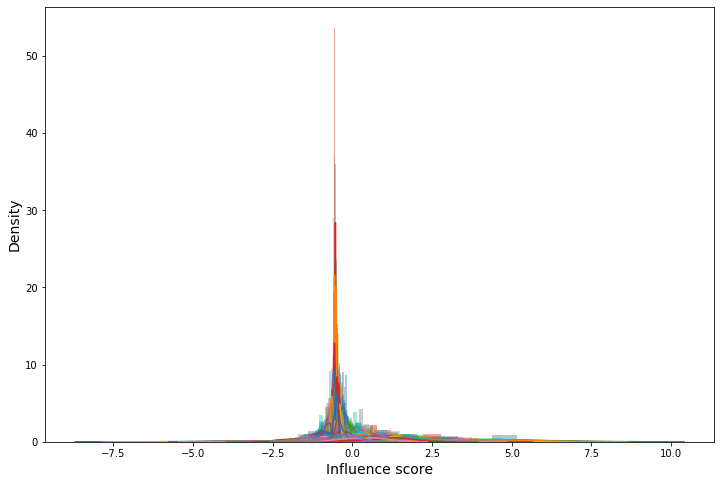

CPU times: user 33 s, sys: 442 ms, total: 33.4 s
Wall time: 33.4 s


In [43]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in range(influence_matrix.shape[1]):
    sns.distplot(influence_matrix[:,i], ax=ax)
# plt.title('Distributuion of influence per feature dim')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/feat_influence_dist_all_baseline_direct.png', bbox_inches='tight')
plt.show()

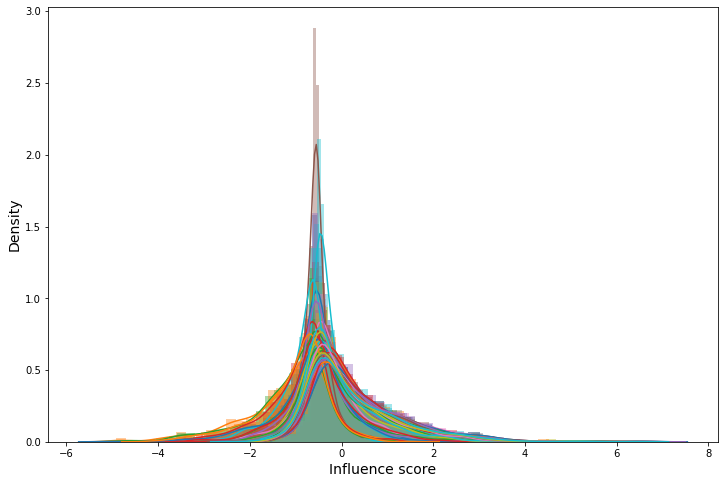

CPU times: user 7.75 s, sys: 46.7 ms, total: 7.8 s
Wall time: 7.78 s


In [44]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in range(influence_matrix.shape[0]):
    sns.distplot(influence_matrix[i,:], ax=ax)
# plt.title('Distributuion of influence per validation sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/valid_influence_dist_al_baseline_direct.png', bbox_inches='tight')
plt.show()

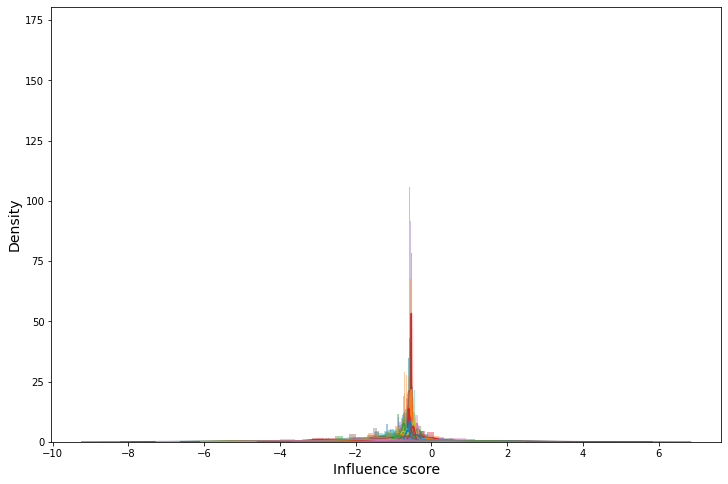

CPU times: user 21.2 s, sys: 82.7 ms, total: 21.3 s
Wall time: 21.3 s


In [45]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in range(influence_matrix.shape[1]):
    sns.distplot(influence_matrix[list(map(lambda x: id2idx[x], incorrect_list)),i], ax=ax)
# plt.title('Distributuion of influence per training sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/incorrect_feat_influence_dist_all_baseline_direct.png', bbox_inches='tight')
plt.show()

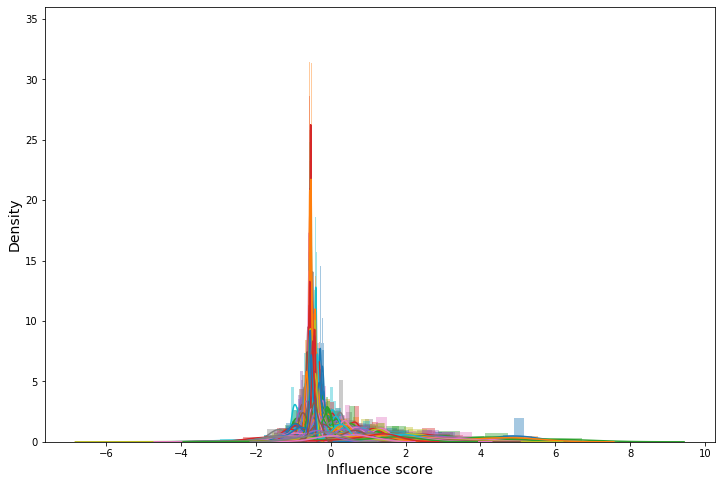

CPU times: user 32.9 s, sys: 158 ms, total: 33.1 s
Wall time: 33 s


In [46]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in range(influence_matrix.shape[1]):
    sns.distplot(influence_matrix[list(map(lambda x: id2idx[x], correct_list)),i], ax=ax)
# plt.title('Distributuion of influence per training sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/correct_feat_influence_dist_all_baseline_directe.png', bbox_inches='tight')
plt.show()

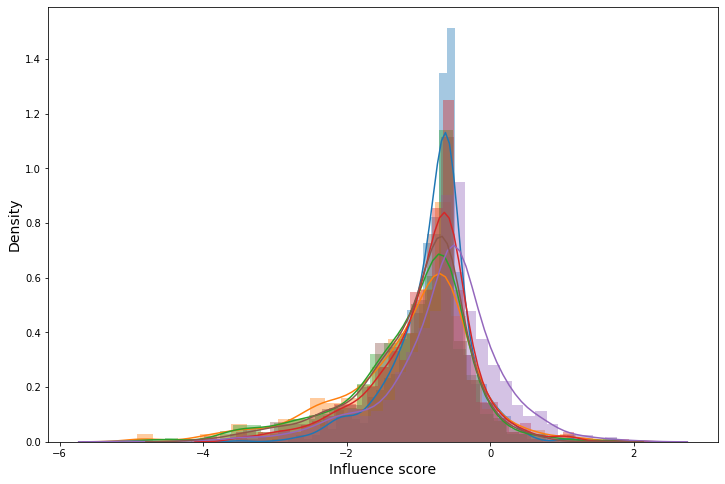

CPU times: user 1.82 s, sys: 31.6 ms, total: 1.85 s
Wall time: 1.85 s


In [47]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in list(map(lambda x: id2idx[x], incorrect_list)):
    sns.distplot(influence_matrix[i,:], ax=ax)
# plt.title('Distributuion of influence per validation sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/incorrect_valid_influence_dist_all_baseline_directe.png', bbox_inches='tight')
plt.show()

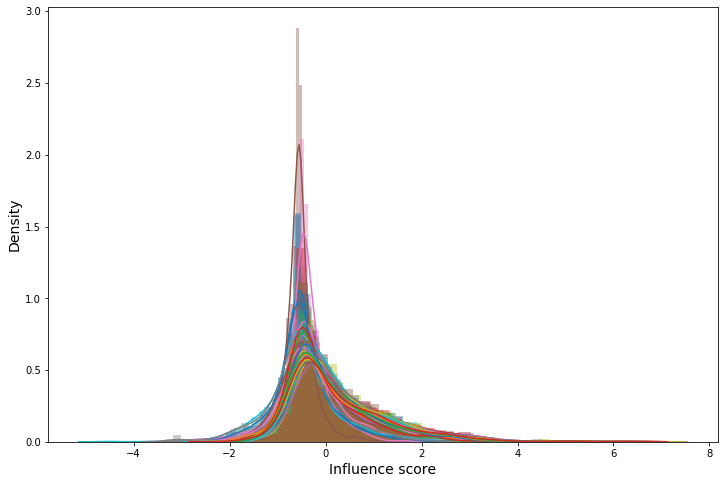

CPU times: user 6.86 s, sys: 3.68 ms, total: 6.86 s
Wall time: 6.84 s


In [48]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in list(map(lambda x: id2idx[x], correct_list)):
    sns.distplot(influence_matrix[i,:], ax=ax)
# plt.title('Distributuion of influence per validation sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/correct_valid_influence_dist_all_baseline_direct.png', bbox_inches='tight')
plt.show()

## Test Reevaluate Baseline

In [49]:
pd.DataFrame(influence_matrix.mean(axis=0)).describe(np.arange(0.0, 1.0, 0.05))

,0
count,768.000000
mean,-0.000006
std,0.646210
min,-1.058370
0%,-1.058370
5%,-0.646563
10%,-0.555005
15%,-0.523242
20%,-0.499924
25%,-0.465203


In [50]:
df = pd.DataFrame(influence_matrix.mean(axis=0)).sort_values(0)

In [51]:
def forward_with_feat_mask(model, feat_mask, batch_data, i2w, device='cpu'):
    # Unpack batch data
    if len(batch_data) == 4:
        (ids, subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 5:
        (ids, subword_batch, mask_batch, token_type_batch, label_batch) = batch_data
    
    # Prepare input & label
    subword = torch.LongTensor(subword_batch)
    attn_mask = torch.FloatTensor(mask_batch)
    label = torch.LongTensor(label_batch)

    if device == "cuda":
        subword = subword.cuda()
        attn_mask = attn_mask.cuda()
        label = label.cuda()

    if isinstance(model, RobertaForSequenceClassification):
        # Calculate latents
        latents = model.roberta(subword, attention_mask=attn_mask)[0][:,0,:]
        latents = model.classifier.dense(latents)
        
        # Compute prediction with feat_mask
        mask = torch.ones_like(latents, device=device)
        mask[:,feat_mask] = 0

        filt_latents = torch.tanh(latents) * mask
        logits = model.classifier.out_proj(filt_latents)
        loss = CrossEntropyLoss()(logits.view(-1, model.num_labels), label.view(-1))            
    else:
        raise NotImplementedError(f'Model class `{type(model)}` is not implemented yet')

    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])
        
    return loss, list_hyp, list_label, logits, label_batch

In [52]:
# Selective masking
model.eval()
torch.set_grad_enabled(False)
for k in range(0, 764, 50):
    print(f'== top-k : {k} ==')
    feat_mask = list(df.head(k).index)
    
    # Test on Indian
    total_loss = 0
    list_hyp, list_label = [], []
    for i, batch_data in enumerate(test_loader):
        batch_seq = batch_data[-1]
        outputs = forward_with_feat_mask(model, feat_mask, batch_data[:-1], i2w=i2w, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Calculate total loss
        total_loss += loss.item()

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label

    eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
    fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
    for key in fake_metrics.keys():
        eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
    real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
    for key in real_metrics.keys():
        eval_metrics[f'REAL_{key}'] = real_metrics[key]

    print(f'INDIAN TEST RESULT: {metrics_to_string(eval_metrics)}')
    
    # Test on YEJIN
    total_loss = 0
    list_hyp, list_label = [], []
    for i, batch_data in enumerate(test_zero_loader):
        batch_seq = batch_data[-1]
        outputs = forward_with_feat_mask(model, feat_mask, batch_data[:-1], i2w=i2w, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Calculate total loss
        total_loss += loss.item()

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label

    eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
    fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
    for key in fake_metrics.keys():
        eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
    real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
    for key in real_metrics.keys():
        eval_metrics[f'REAL_{key}'] = real_metrics[key]

    print(f'YEJIN TEST RESULT: {metrics_to_string(eval_metrics)}')

== top-k : 0 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9579 F1:0.9576 REC:0.9561 PRE:0.9619 FAKE_ACC:0.9579 FAKE_F1:0.9541 FAKE_REC:0.9167 FAKE_PRE:0.9947 REAL_ACC:0.9579 REAL_F1:0.9612 REAL_REC:0.9955 REAL_PRE:0.9292


/home/samuel/anaconda2/envs/env_py3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'fake') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


YEJIN TEST RESULT: ACC:0.6456 F1:0.6297 REC:0.7244 PRE:0.6691 FAKE_ACC:0.6456 FAKE_F1:0.5532 FAKE_REC:0.8814 FAKE_PRE:0.4031 REAL_ACC:0.6456 REAL_F1:0.7063 REAL_REC:0.5674 REAL_PRE:0.9352
== top-k : 50 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9551 F1:0.9548 REC:0.9531 PRE:0.9598 FAKE_ACC:0.9551 FAKE_F1:0.9508 FAKE_REC:0.9098 FAKE_PRE:0.9957 REAL_ACC:0.9551 REAL_F1:0.9588 REAL_REC:0.9964 REAL_PRE:0.9238
YEJIN TEST RESULT: ACC:0.6540 F1:0.6372 REC:0.7300 PRE:0.6729 FAKE_ACC:0.6540 FAKE_F1:0.5591 FAKE_REC:0.8814 FAKE_PRE:0.4094 REAL_ACC:0.6540 REAL_F1:0.7153 REAL_REC:0.5787 REAL_PRE:0.9364
== top-k : 100 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9547 F1:0.9543 REC:0.9526 PRE:0.9594 FAKE_ACC:0.9547 FAKE_F1:0.9503 FAKE_REC:0.9088 FAKE_PRE:0.9957 REAL_ACC:0.9547 REAL_F1:0.9584 REAL_REC:0.9964 REAL_PRE:0.9231
YEJIN TEST RESULT: ACC:0.6540 F1:0.6372 REC:0.7300 PRE:0.6729 FAKE_ACC:0.6540 FAKE_F1:0.5591 FAKE_REC:0.8814 FAKE_PRE:0.4094 REAL_ACC:0.6540 REAL_F1:0.7153 REAL_REC:0.5787 REAL_PRE:0.9364
== top-k : 150 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9547 F1:0.9543 REC:0.9526 PRE:0.9594 FAKE_ACC:0.9547 FAKE_F1:0.9503 FAKE_REC:0.9088 FAKE_PRE:0.9957 REAL_ACC:0.9547 REAL_F1:0.9584 REAL_REC:0.9964 REAL_PRE:0.9231
YEJIN TEST RESULT: ACC:0.6540 F1:0.6372 REC:0.7300 PRE:0.6729 FAKE_ACC:0.6540 FAKE_F1:0.5591 FAKE_REC:0.8814 FAKE_PRE:0.4094 REAL_ACC:0.6540 REAL_F1:0.7153 REAL_REC:0.5787 REAL_PRE:0.9364
== top-k : 200 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9542 F1:0.9538 REC:0.9521 PRE:0.9590 FAKE_ACC:0.9542 FAKE_F1:0.9497 FAKE_REC:0.9078 FAKE_PRE:0.9957 REAL_ACC:0.9542 REAL_F1:0.9579 REAL_REC:0.9964 REAL_PRE:0.9223
YEJIN TEST RESULT: ACC:0.6540 F1:0.6372 REC:0.7300 PRE:0.6729 FAKE_ACC:0.6540 FAKE_F1:0.5591 FAKE_REC:0.8814 FAKE_PRE:0.4094 REAL_ACC:0.6540 REAL_F1:0.7153 REAL_REC:0.5787 REAL_PRE:0.9364
== top-k : 250 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9528 F1:0.9524 REC:0.9507 PRE:0.9579 FAKE_ACC:0.9528 FAKE_F1:0.9481 FAKE_REC:0.9049 FAKE_PRE:0.9957 REAL_ACC:0.9528 REAL_F1:0.9567 REAL_REC:0.9964 REAL_PRE:0.9200
YEJIN TEST RESULT: ACC:0.6540 F1:0.6372 REC:0.7300 PRE:0.6729 FAKE_ACC:0.6540 FAKE_F1:0.5591 FAKE_REC:0.8814 FAKE_PRE:0.4094 REAL_ACC:0.6540 REAL_F1:0.7153 REAL_REC:0.5787 REAL_PRE:0.9364
== top-k : 300 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9509 F1:0.9505 REC:0.9487 PRE:0.9563 FAKE_ACC:0.9509 FAKE_F1:0.9460 FAKE_REC:0.9010 FAKE_PRE:0.9957 REAL_ACC:0.9509 REAL_F1:0.9551 REAL_REC:0.9964 REAL_PRE:0.9170
YEJIN TEST RESULT: ACC:0.6540 F1:0.6372 REC:0.7300 PRE:0.6729 FAKE_ACC:0.6540 FAKE_F1:0.5591 FAKE_REC:0.8814 FAKE_PRE:0.4094 REAL_ACC:0.6540 REAL_F1:0.7153 REAL_REC:0.5787 REAL_PRE:0.9364
== top-k : 350 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9509 F1:0.9505 REC:0.9487 PRE:0.9563 FAKE_ACC:0.9509 FAKE_F1:0.9460 FAKE_REC:0.9010 FAKE_PRE:0.9957 REAL_ACC:0.9509 REAL_F1:0.9551 REAL_REC:0.9964 REAL_PRE:0.9170
YEJIN TEST RESULT: ACC:0.6582 F1:0.6409 REC:0.7328 PRE:0.6748 FAKE_ACC:0.6582 FAKE_F1:0.5622 FAKE_REC:0.8814 FAKE_PRE:0.4127 REAL_ACC:0.6582 REAL_F1:0.7197 REAL_REC:0.5843 REAL_PRE:0.9369
== top-k : 400 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9509 F1:0.9505 REC:0.9487 PRE:0.9563 FAKE_ACC:0.9509 FAKE_F1:0.9460 FAKE_REC:0.9010 FAKE_PRE:0.9957 REAL_ACC:0.9509 REAL_F1:0.9551 REAL_REC:0.9964 REAL_PRE:0.9170
YEJIN TEST RESULT: ACC:0.6624 F1:0.6447 REC:0.7356 PRE:0.6767 FAKE_ACC:0.6624 FAKE_F1:0.5652 FAKE_REC:0.8814 FAKE_PRE:0.4160 REAL_ACC:0.6624 REAL_F1:0.7241 REAL_REC:0.5899 REAL_PRE:0.9375
== top-k : 450 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9500 F1:0.9496 REC:0.9477 PRE:0.9556 FAKE_ACC:0.9500 FAKE_F1:0.9449 FAKE_REC:0.8990 FAKE_PRE:0.9957 REAL_ACC:0.9500 REAL_F1:0.9543 REAL_REC:0.9964 REAL_PRE:0.9155
YEJIN TEST RESULT: ACC:0.6667 F1:0.6484 REC:0.7384 PRE:0.6787 FAKE_ACC:0.6667 FAKE_F1:0.5683 FAKE_REC:0.8814 FAKE_PRE:0.4194 REAL_ACC:0.6667 REAL_F1:0.7285 REAL_REC:0.5955 REAL_PRE:0.9381
== top-k : 500 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9500 F1:0.9496 REC:0.9477 PRE:0.9556 FAKE_ACC:0.9500 FAKE_F1:0.9449 FAKE_REC:0.8990 FAKE_PRE:0.9957 REAL_ACC:0.9500 REAL_F1:0.9543 REAL_REC:0.9964 REAL_PRE:0.9155
YEJIN TEST RESULT: ACC:0.6709 F1:0.6522 REC:0.7412 PRE:0.6807 FAKE_ACC:0.6709 FAKE_F1:0.5714 FAKE_REC:0.8814 FAKE_PRE:0.4228 REAL_ACC:0.6709 REAL_F1:0.7329 REAL_REC:0.6011 REAL_PRE:0.9386
== top-k : 550 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9500 F1:0.9496 REC:0.9477 PRE:0.9556 FAKE_ACC:0.9500 FAKE_F1:0.9449 FAKE_REC:0.8990 FAKE_PRE:0.9957 REAL_ACC:0.9500 REAL_F1:0.9543 REAL_REC:0.9964 REAL_PRE:0.9155
YEJIN TEST RESULT: ACC:0.6709 F1:0.6522 REC:0.7412 PRE:0.6807 FAKE_ACC:0.6709 FAKE_F1:0.5714 FAKE_REC:0.8814 FAKE_PRE:0.4228 REAL_ACC:0.6709 REAL_F1:0.7329 REAL_REC:0.6011 REAL_PRE:0.9386
== top-k : 600 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9505 F1:0.9500 REC:0.9482 PRE:0.9560 FAKE_ACC:0.9505 FAKE_F1:0.9454 FAKE_REC:0.9000 FAKE_PRE:0.9957 REAL_ACC:0.9505 REAL_F1:0.9547 REAL_REC:0.9964 REAL_PRE:0.9163
YEJIN TEST RESULT: ACC:0.6709 F1:0.6522 REC:0.7412 PRE:0.6807 FAKE_ACC:0.6709 FAKE_F1:0.5714 FAKE_REC:0.8814 FAKE_PRE:0.4228 REAL_ACC:0.6709 REAL_F1:0.7329 REAL_REC:0.6011 REAL_PRE:0.9386
== top-k : 650 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9509 F1:0.9505 REC:0.9487 PRE:0.9563 FAKE_ACC:0.9509 FAKE_F1:0.9460 FAKE_REC:0.9010 FAKE_PRE:0.9957 REAL_ACC:0.9509 REAL_F1:0.9551 REAL_REC:0.9964 REAL_PRE:0.9170
YEJIN TEST RESULT: ACC:0.6667 F1:0.6484 REC:0.7384 PRE:0.6787 FAKE_ACC:0.6667 FAKE_F1:0.5683 FAKE_REC:0.8814 FAKE_PRE:0.4194 REAL_ACC:0.6667 REAL_F1:0.7285 REAL_REC:0.5955 REAL_PRE:0.9381
== top-k : 700 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9495 F1:0.9491 REC:0.9472 PRE:0.9552 FAKE_ACC:0.9495 FAKE_F1:0.9443 FAKE_REC:0.8980 FAKE_PRE:0.9957 REAL_ACC:0.9495 REAL_F1:0.9538 REAL_REC:0.9964 REAL_PRE:0.9148
YEJIN TEST RESULT: ACC:0.6667 F1:0.6484 REC:0.7384 PRE:0.6787 FAKE_ACC:0.6667 FAKE_F1:0.5683 FAKE_REC:0.8814 FAKE_PRE:0.4194 REAL_ACC:0.6667 REAL_F1:0.7285 REAL_REC:0.5955 REAL_PRE:0.9381
== top-k : 750 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9411 F1:0.9405 REC:0.9384 PRE:0.9485 FAKE_ACC:0.9411 FAKE_F1:0.9344 FAKE_REC:0.8804 FAKE_PRE:0.9956 REAL_ACC:0.9411 REAL_F1:0.9466 REAL_REC:0.9964 REAL_PRE:0.9015
YEJIN TEST RESULT: ACC:0.6582 F1:0.6365 REC:0.7158 PRE:0.6614 FAKE_ACC:0.6582 FAKE_F1:0.5475 FAKE_REC:0.8305 FAKE_PRE:0.4083 REAL_ACC:0.6582 REAL_F1:0.7254 REAL_REC:0.6011 REAL_PRE:0.9145


In [53]:
# Random masking
model.eval()
torch.set_grad_enabled(False)
for k in range(0, 764, 50):
    print(f'== top-k : {k} ==')
    feat_mask = np.random.choice(np.arange(0,764), k, replace=False)
    
    # Test on Indian
    total_loss = 0
    list_hyp, list_label = [], []
    for i, batch_data in enumerate(test_loader):
        batch_seq = batch_data[-1]
        outputs = forward_with_feat_mask(model, feat_mask, batch_data[:-1], i2w=i2w, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Calculate total loss
        total_loss += loss.item()

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label

    eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
    fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
    for key in fake_metrics.keys():
        eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
    real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
    for key in real_metrics.keys():
        eval_metrics[f'REAL_{key}'] = real_metrics[key]

    print(f'INDIAN TEST RESULT: {metrics_to_string(eval_metrics)}')
    
    # Test on YEJIN
    total_loss = 0
    list_hyp, list_label = [], []
    for i, batch_data in enumerate(test_zero_loader):
        batch_seq = batch_data[-1]
        outputs = forward_with_feat_mask(model, feat_mask, batch_data[:-1], i2w=i2w, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Calculate total loss
        total_loss += loss.item()

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label

    eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
    fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
    for key in fake_metrics.keys():
        eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
    real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
    for key in real_metrics.keys():
        eval_metrics[f'REAL_{key}'] = real_metrics[key]

    print(f'YEJIN TEST RESULT: {metrics_to_string(eval_metrics)}')

== top-k : 0 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9579 F1:0.9576 REC:0.9561 PRE:0.9619 FAKE_ACC:0.9579 FAKE_F1:0.9541 FAKE_REC:0.9167 FAKE_PRE:0.9947 REAL_ACC:0.9579 REAL_F1:0.9612 REAL_REC:0.9955 REAL_PRE:0.9292
YEJIN TEST RESULT: ACC:0.6456 F1:0.6297 REC:0.7244 PRE:0.6691 FAKE_ACC:0.6456 FAKE_F1:0.5532 FAKE_REC:0.8814 FAKE_PRE:0.4031 REAL_ACC:0.6456 REAL_F1:0.7063 REAL_REC:0.5674 REAL_PRE:0.9352
== top-k : 50 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9593 F1:0.9591 REC:0.9576 PRE:0.9631 FAKE_ACC:0.9593 FAKE_F1:0.9557 FAKE_REC:0.9196 FAKE_PRE:0.9947 REAL_ACC:0.9593 REAL_F1:0.9625 REAL_REC:0.9955 REAL_PRE:0.9315
YEJIN TEST RESULT: ACC:0.6456 F1:0.6297 REC:0.7244 PRE:0.6691 FAKE_ACC:0.6456 FAKE_F1:0.5532 FAKE_REC:0.8814 FAKE_PRE:0.4031 REAL_ACC:0.6456 REAL_F1:0.7063 REAL_REC:0.5674 REAL_PRE:0.9352
== top-k : 100 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9593 F1:0.9591 REC:0.9576 PRE:0.9631 FAKE_ACC:0.9593 FAKE_F1:0.9557 FAKE_REC:0.9196 FAKE_PRE:0.9947 REAL_ACC:0.9593 REAL_F1:0.9625 REAL_REC:0.9955 REAL_PRE:0.9315
YEJIN TEST RESULT: ACC:0.6456 F1:0.6297 REC:0.7244 PRE:0.6691 FAKE_ACC:0.6456 FAKE_F1:0.5532 FAKE_REC:0.8814 FAKE_PRE:0.4031 REAL_ACC:0.6456 REAL_F1:0.7063 REAL_REC:0.5674 REAL_PRE:0.9352
== top-k : 150 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9584 F1:0.9581 REC:0.9566 PRE:0.9623 FAKE_ACC:0.9584 FAKE_F1:0.9546 FAKE_REC:0.9176 FAKE_PRE:0.9947 REAL_ACC:0.9584 REAL_F1:0.9616 REAL_REC:0.9955 REAL_PRE:0.9299
YEJIN TEST RESULT: ACC:0.6456 F1:0.6297 REC:0.7244 PRE:0.6691 FAKE_ACC:0.6456 FAKE_F1:0.5532 FAKE_REC:0.8814 FAKE_PRE:0.4031 REAL_ACC:0.6456 REAL_F1:0.7063 REAL_REC:0.5674 REAL_PRE:0.9352
== top-k : 200 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9584 F1:0.9581 REC:0.9566 PRE:0.9623 FAKE_ACC:0.9584 FAKE_F1:0.9546 FAKE_REC:0.9176 FAKE_PRE:0.9947 REAL_ACC:0.9584 REAL_F1:0.9616 REAL_REC:0.9955 REAL_PRE:0.9299
YEJIN TEST RESULT: ACC:0.6456 F1:0.6297 REC:0.7244 PRE:0.6691 FAKE_ACC:0.6456 FAKE_F1:0.5532 FAKE_REC:0.8814 FAKE_PRE:0.4031 REAL_ACC:0.6456 REAL_F1:0.7063 REAL_REC:0.5674 REAL_PRE:0.9352
== top-k : 250 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9589 F1:0.9586 REC:0.9571 PRE:0.9625 FAKE_ACC:0.9589 FAKE_F1:0.9552 FAKE_REC:0.9196 FAKE_PRE:0.9936 REAL_ACC:0.9589 REAL_F1:0.9620 REAL_REC:0.9946 REAL_PRE:0.9314
YEJIN TEST RESULT: ACC:0.6456 F1:0.6297 REC:0.7244 PRE:0.6691 FAKE_ACC:0.6456 FAKE_F1:0.5532 FAKE_REC:0.8814 FAKE_PRE:0.4031 REAL_ACC:0.6456 REAL_F1:0.7063 REAL_REC:0.5674 REAL_PRE:0.9352
== top-k : 300 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9593 F1:0.9591 REC:0.9576 PRE:0.9631 FAKE_ACC:0.9593 FAKE_F1:0.9557 FAKE_REC:0.9196 FAKE_PRE:0.9947 REAL_ACC:0.9593 REAL_F1:0.9625 REAL_REC:0.9955 REAL_PRE:0.9315
YEJIN TEST RESULT: ACC:0.6456 F1:0.6297 REC:0.7244 PRE:0.6691 FAKE_ACC:0.6456 FAKE_F1:0.5532 FAKE_REC:0.8814 FAKE_PRE:0.4031 REAL_ACC:0.6456 REAL_F1:0.7063 REAL_REC:0.5674 REAL_PRE:0.9352
== top-k : 350 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9584 F1:0.9581 REC:0.9566 PRE:0.9621 FAKE_ACC:0.9584 FAKE_F1:0.9547 FAKE_REC:0.9186 FAKE_PRE:0.9936 REAL_ACC:0.9584 REAL_F1:0.9616 REAL_REC:0.9946 REAL_PRE:0.9307
YEJIN TEST RESULT: ACC:0.6456 F1:0.6297 REC:0.7244 PRE:0.6691 FAKE_ACC:0.6456 FAKE_F1:0.5532 FAKE_REC:0.8814 FAKE_PRE:0.4031 REAL_ACC:0.6456 REAL_F1:0.7063 REAL_REC:0.5674 REAL_PRE:0.9352
== top-k : 400 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9603 F1:0.9600 REC:0.9586 PRE:0.9637 FAKE_ACC:0.9603 FAKE_F1:0.9568 FAKE_REC:0.9225 FAKE_PRE:0.9937 REAL_ACC:0.9603 REAL_F1:0.9633 REAL_REC:0.9946 REAL_PRE:0.9338
YEJIN TEST RESULT: ACC:0.6329 F1:0.6185 REC:0.7160 PRE:0.6636 FAKE_ACC:0.6329 FAKE_F1:0.5445 FAKE_REC:0.8814 FAKE_PRE:0.3939 REAL_ACC:0.6329 REAL_F1:0.6926 REAL_REC:0.5506 REAL_PRE:0.9333
== top-k : 450 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9584 F1:0.9581 REC:0.9566 PRE:0.9621 FAKE_ACC:0.9584 FAKE_F1:0.9547 FAKE_REC:0.9186 FAKE_PRE:0.9936 REAL_ACC:0.9584 REAL_F1:0.9616 REAL_REC:0.9946 REAL_PRE:0.9307
YEJIN TEST RESULT: ACC:0.6456 F1:0.6297 REC:0.7244 PRE:0.6691 FAKE_ACC:0.6456 FAKE_F1:0.5532 FAKE_REC:0.8814 FAKE_PRE:0.4031 REAL_ACC:0.6456 REAL_F1:0.7063 REAL_REC:0.5674 REAL_PRE:0.9352
== top-k : 500 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9547 F1:0.9543 REC:0.9526 PRE:0.9594 FAKE_ACC:0.9547 FAKE_F1:0.9503 FAKE_REC:0.9088 FAKE_PRE:0.9957 REAL_ACC:0.9547 REAL_F1:0.9584 REAL_REC:0.9964 REAL_PRE:0.9231
YEJIN TEST RESULT: ACC:0.6498 F1:0.6335 REC:0.7272 PRE:0.6710 FAKE_ACC:0.6498 FAKE_F1:0.5561 FAKE_REC:0.8814 FAKE_PRE:0.4062 REAL_ACC:0.6498 REAL_F1:0.7108 REAL_REC:0.5730 REAL_PRE:0.9358
== top-k : 550 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9514 F1:0.9510 REC:0.9492 PRE:0.9567 FAKE_ACC:0.9514 FAKE_F1:0.9465 FAKE_REC:0.9020 FAKE_PRE:0.9957 REAL_ACC:0.9514 REAL_F1:0.9555 REAL_REC:0.9964 REAL_PRE:0.9178
YEJIN TEST RESULT: ACC:0.6624 F1:0.6447 REC:0.7356 PRE:0.6767 FAKE_ACC:0.6624 FAKE_F1:0.5652 FAKE_REC:0.8814 FAKE_PRE:0.4160 REAL_ACC:0.6624 REAL_F1:0.7241 REAL_REC:0.5899 REAL_PRE:0.9375
== top-k : 600 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9584 F1:0.9581 REC:0.9565 PRE:0.9625 FAKE_ACC:0.9584 FAKE_F1:0.9546 FAKE_REC:0.9167 FAKE_PRE:0.9957 REAL_ACC:0.9584 REAL_F1:0.9617 REAL_REC:0.9964 REAL_PRE:0.9292
YEJIN TEST RESULT: ACC:0.6498 F1:0.6335 REC:0.7272 PRE:0.6710 FAKE_ACC:0.6498 FAKE_F1:0.5561 FAKE_REC:0.8814 FAKE_PRE:0.4062 REAL_ACC:0.6498 REAL_F1:0.7108 REAL_REC:0.5730 REAL_PRE:0.9358
== top-k : 650 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9519 F1:0.9515 REC:0.9497 PRE:0.9571 FAKE_ACC:0.9519 FAKE_F1:0.9470 FAKE_REC:0.9029 FAKE_PRE:0.9957 REAL_ACC:0.9519 REAL_F1:0.9559 REAL_REC:0.9964 REAL_PRE:0.9185
YEJIN TEST RESULT: ACC:0.6582 F1:0.6409 REC:0.7328 PRE:0.6748 FAKE_ACC:0.6582 FAKE_F1:0.5622 FAKE_REC:0.8814 FAKE_PRE:0.4127 REAL_ACC:0.6582 REAL_F1:0.7197 REAL_REC:0.5843 REAL_PRE:0.9369
== top-k : 700 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9514 F1:0.9510 REC:0.9492 PRE:0.9565 FAKE_ACC:0.9514 FAKE_F1:0.9466 FAKE_REC:0.9029 FAKE_PRE:0.9946 REAL_ACC:0.9514 REAL_F1:0.9554 REAL_REC:0.9955 REAL_PRE:0.9185
YEJIN TEST RESULT: ACC:0.6624 F1:0.6447 REC:0.7356 PRE:0.6767 FAKE_ACC:0.6624 FAKE_F1:0.5652 FAKE_REC:0.8814 FAKE_PRE:0.4160 REAL_ACC:0.6624 REAL_F1:0.7241 REAL_REC:0.5899 REAL_PRE:0.9375
== top-k : 750 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9607 F1:0.9605 REC:0.9591 PRE:0.9640 FAKE_ACC:0.9607 FAKE_F1:0.9574 FAKE_REC:0.9245 FAKE_PRE:0.9926 REAL_ACC:0.9607 REAL_F1:0.9636 REAL_REC:0.9938 REAL_PRE:0.9353
YEJIN TEST RESULT: ACC:0.6371 F1:0.6223 REC:0.7188 PRE:0.6655 FAKE_ACC:0.6371 FAKE_F1:0.5474 FAKE_REC:0.8814 FAKE_PRE:0.3969 REAL_ACC:0.6371 REAL_F1:0.6972 REAL_REC:0.5562 REAL_PRE:0.9340


# Ensemble Baseline

In [54]:
%%time
model = model.cuda().eval()
model.load_state_dict(torch.load('./tmp_hessian/model_direct_addi_ft.pt'))

CPU times: user 123 ms, sys: 245 ms, total: 367 ms
Wall time: 360 ms


<All keys matched successfully>

In [55]:
def forward_with_ensemble_feat_mask(model, feat_masks, batch_data, i2w, device='cpu'):
    # Unpack batch data
    if len(batch_data) == 4:
        (ids, subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 5:
        (ids, subword_batch, mask_batch, token_type_batch, label_batch) = batch_data
    
    # Prepare input & label
    subword = torch.LongTensor(subword_batch)
    attn_mask = torch.FloatTensor(mask_batch)
    label = torch.LongTensor(label_batch)

    if device == "cuda":
        subword = subword.cuda()
        attn_mask = attn_mask.cuda()
        label = label.cuda()

    if isinstance(model, RobertaForSequenceClassification):
        # Calculate latents
        latents = model.roberta(subword, attention_mask=attn_mask)[0][:,0,:]
        latents = model.classifier.dense(latents)
        
        # Compute prediction with feat_mask
        logits = None
        for feat_mask in feat_masks:
            mask = torch.ones_like(latents, device=device)
            mask[:,feat_mask] = 0

            filt_latents = torch.tanh(latents) * mask
            if logits is None:
                logits = model.classifier.out_proj(filt_latents)
            else:
                logits += model.classifier.out_proj(filt_latents)
        logits /= len(feat_masks)
        
        loss = CrossEntropyLoss()(logits.view(-1, model.num_labels), label.view(-1))            
    else:
        raise NotImplementedError(f'Model class `{type(model)}` is not implemented yet')

    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])
        
    return loss, list_hyp, list_label, logits, label_batch

In [58]:
# Selective masking
model.eval()
torch.set_grad_enabled(False)

feat_masks = []
for k in range(0, 764, 50):
    feat_masks.append(list(df.head(k).index))
    
# Test on Indian
total_loss = 0
list_hyp, list_label = [], []
for i, batch_data in enumerate(test_loader):
    batch_seq = batch_data[-1]
    outputs = forward_with_ensemble_feat_mask(model, feat_masks, batch_data[:-1], i2w=i2w, device='cuda')
    loss, batch_hyp, batch_label, logits, label_batch = outputs

    # Calculate total loss
    total_loss += loss.item()

    # Calculate evaluation metrics
    list_hyp += batch_hyp
    list_label += batch_label

eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
for key in fake_metrics.keys():
    eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
for key in real_metrics.keys():
    eval_metrics[f'REAL_{key}'] = real_metrics[key]

print(f'INDIAN TEST RESULT: {metrics_to_string(eval_metrics)}')
    
# Test on YEJIN
total_loss = 0
list_hyp, list_label = [], []
for i, batch_data in enumerate(test_zero_loader):
    batch_seq = batch_data[-1]
    outputs = forward_with_ensemble_feat_mask(model, feat_masks, batch_data[:-1], i2w=i2w, device='cuda')
    loss, batch_hyp, batch_label, logits, label_batch = outputs

    # Calculate total loss
    total_loss += loss.item()

    # Calculate evaluation metrics
    list_hyp += batch_hyp
    list_label += batch_label

eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
for key in fake_metrics.keys():
    eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
for key in real_metrics.keys():
    eval_metrics[f'REAL_{key}'] = real_metrics[key]

print(f'YEJIN TEST RESULT: {metrics_to_string(eval_metrics)}')

Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9509 F1:0.9505 REC:0.9487 PRE:0.9563 FAKE_ACC:0.9509 FAKE_F1:0.9460 FAKE_REC:0.9010 FAKE_PRE:0.9957 REAL_ACC:0.9509 REAL_F1:0.9551 REAL_REC:0.9964 REAL_PRE:0.9170
YEJIN TEST RESULT: ACC:0.6540 F1:0.6372 REC:0.7300 PRE:0.6729 FAKE_ACC:0.6540 FAKE_F1:0.5591 FAKE_REC:0.8814 FAKE_PRE:0.4094 REAL_ACC:0.6540 REAL_F1:0.7153 REAL_REC:0.5787 REAL_PRE:0.9364


In [59]:
# Random masking
model.eval()
torch.set_grad_enabled(False)

feat_masks = []
for k in range(0, 764, 50):
    feat_masks = np.random.choice(np.arange(0,764), k, replace=False)
    
# Test on Indian
total_loss = 0
list_hyp, list_label = [], []
for i, batch_data in enumerate(test_loader):
    batch_seq = batch_data[-1]
    outputs = forward_with_ensemble_feat_mask(model, feat_masks, batch_data[:-1], i2w=i2w, device='cuda')
    loss, batch_hyp, batch_label, logits, label_batch = outputs

    # Calculate total loss
    total_loss += loss.item()

    # Calculate evaluation metrics
    list_hyp += batch_hyp
    list_label += batch_label

eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
for key in fake_metrics.keys():
    eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
for key in real_metrics.keys():
    eval_metrics[f'REAL_{key}'] = real_metrics[key]

print(f'INDIAN TEST RESULT: {metrics_to_string(eval_metrics)}')
    
# Test on YEJIN
total_loss = 0
list_hyp, list_label = [], []
for i, batch_data in enumerate(test_zero_loader):
    batch_seq = batch_data[-1]
    outputs = forward_with_ensemble_feat_mask(model, feat_masks, batch_data[:-1], i2w=i2w, device='cuda')
    loss, batch_hyp, batch_label, logits, label_batch = outputs

    # Calculate total loss
    total_loss += loss.item()

    # Calculate evaluation metrics
    list_hyp += batch_hyp
    list_label += batch_label

eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
for key in fake_metrics.keys():
    eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
for key in real_metrics.keys():
    eval_metrics[f'REAL_{key}'] = real_metrics[key]

print(f'YEJIN TEST RESULT: {metrics_to_string(eval_metrics)}')

Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9579 F1:0.9576 REC:0.9561 PRE:0.9619 FAKE_ACC:0.9579 FAKE_F1:0.9541 FAKE_REC:0.9167 FAKE_PRE:0.9947 REAL_ACC:0.9579 REAL_F1:0.9612 REAL_REC:0.9955 REAL_PRE:0.9292
YEJIN TEST RESULT: ACC:0.6456 F1:0.6297 REC:0.7244 PRE:0.6691 FAKE_ACC:0.6456 FAKE_F1:0.5532 FAKE_REC:0.8814 FAKE_PRE:0.4031 REAL_ACC:0.6456 REAL_F1:0.7063 REAL_REC:0.5674 REAL_PRE:0.9352


# Influence score with second direct finetuning baseline model

In [60]:
%%time
model = model.cuda().eval()
model.load_state_dict(torch.load('./tmp_hessian/model_direct_addi_ft_2.pt'))

CPU times: user 98.3 ms, sys: 265 ms, total: 363 ms
Wall time: 356 ms


<All keys matched successfully>

In [61]:
%%time
influence_matrix = build_influence_matrix(model, valid_zero_loader, model.classifier.dense.weight.shape[0], device='cuda')

  1%|          | 4/768 [00:00<00:20, 37.00it/s]

Processing batch 1/8


  1%|          | 5/768 [00:00<00:18, 42.16it/s]

Processing batch 2/8


  1%|          | 5/768 [00:00<00:15, 48.00it/s]

Processing batch 3/8


  1%|          | 5/768 [00:00<00:17, 42.88it/s]

Processing batch 4/8


  1%|          | 5/768 [00:00<00:17, 43.04it/s]

Processing batch 5/8


  1%|          | 5/768 [00:00<00:17, 43.81it/s]

Processing batch 6/8


  1%|          | 5/768 [00:00<00:16, 44.91it/s]

Processing batch 7/8


  1%|          | 7/768 [00:00<00:11, 67.41it/s]

Processing batch 8/8


100%|██████████| 768/768 [00:10<00:00, 70.46it/s]

CPU times: user 2min 6s, sys: 13 s, total: 2min 19s
Wall time: 2min 18s


In [62]:
influence_matrix = influence_matrix.cpu().numpy()
np.save('./tmp_hessian/influence_matrix_baseline_direct_2.npy', influence_matrix)

## Analyse influence

In [63]:
%%time
model = model.cuda()
results = get_inference_result(model, valid_zero_loader, device='cuda') # Return map of ID -> status
correct_list = list(map(lambda kv: kv[0], filter(lambda kv: kv[1], results.items())))
incorrect_list = list(map(lambda kv: kv[0], filter(lambda kv: not kv[1], results.items())))

100%|██████████| 8/8 [00:00<00:00, 12.05it/s]

CPU times: user 209 ms, sys: 372 ms, total: 580 ms
Wall time: 671 ms


## Quantitative analysis influence

In [64]:
influence_matrix = np.load('./tmp_hessian/influence_matrix_baseline_direct_2.npy', allow_pickle=True)
influence_matrix = ((influence_matrix - influence_matrix.mean()) / influence_matrix.std())

In [65]:
idx2id = valid_zero_loader.dataset.data['id'].to_dict()
id2idx = {v:k for k,v in idx2id.items()}

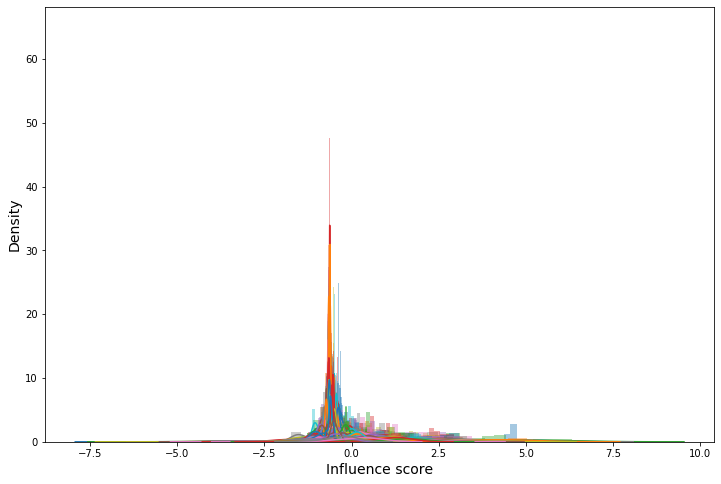

CPU times: user 41.5 s, sys: 447 ms, total: 42 s
Wall time: 41.9 s


In [66]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in range(influence_matrix.shape[1]):
    sns.distplot(influence_matrix[:,i], ax=ax)
# plt.title('Distributuion of influence per feature dim')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/feat_influence_dist_all_baseline_direct_2.png', bbox_inches='tight')
plt.show()

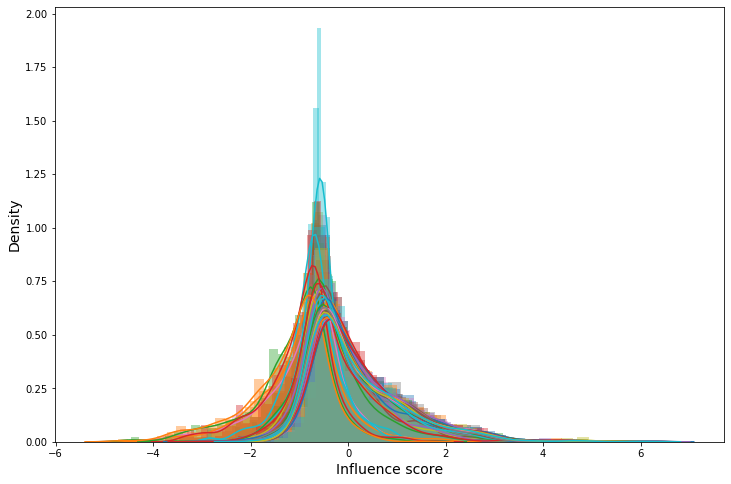

CPU times: user 7.78 s, sys: 67.6 ms, total: 7.85 s
Wall time: 7.84 s


In [67]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in range(influence_matrix.shape[0]):
    sns.distplot(influence_matrix[i,:], ax=ax)
# plt.title('Distributuion of influence per validation sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/valid_influence_dist_al_baseline_direct_2.png', bbox_inches='tight')
plt.show()

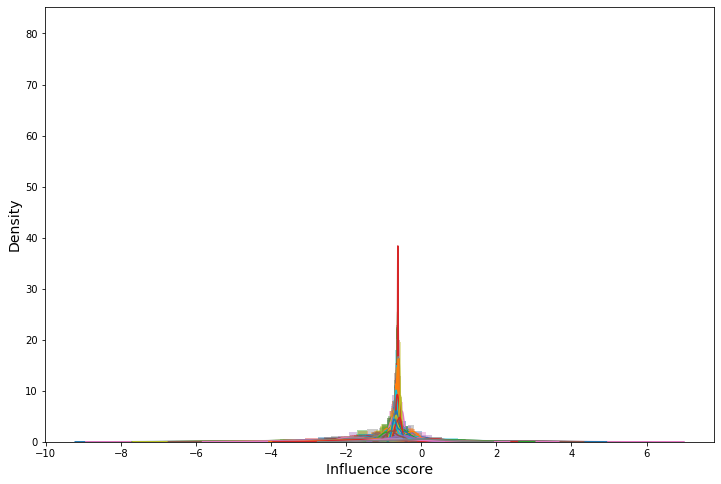

CPU times: user 17.4 s, sys: 81.9 ms, total: 17.5 s
Wall time: 17.4 s


In [68]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in range(influence_matrix.shape[1]):
    sns.distplot(influence_matrix[list(map(lambda x: id2idx[x], incorrect_list)),i], ax=ax)
# plt.title('Distributuion of influence per training sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/incorrect_feat_influence_dist_all_baseline_direct_2.png', bbox_inches='tight')
plt.show()

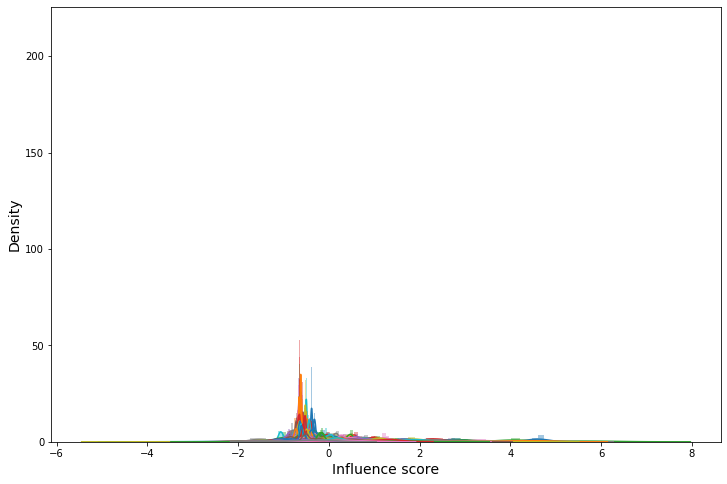

CPU times: user 36.5 s, sys: 71.6 ms, total: 36.5 s
Wall time: 36.5 s


In [69]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in range(influence_matrix.shape[1]):
    sns.distplot(influence_matrix[list(map(lambda x: id2idx[x], correct_list)),i], ax=ax)
# plt.title('Distributuion of influence per training sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/correct_feat_influence_dist_all_baseline_direct_2.png', bbox_inches='tight')
plt.show()

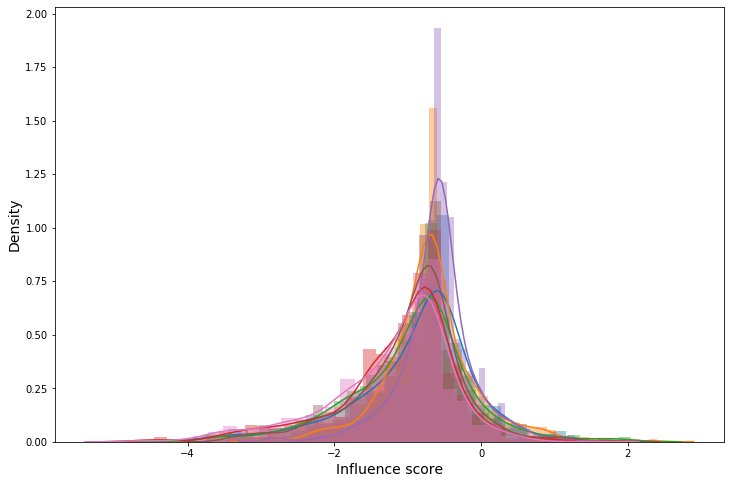

CPU times: user 2.02 s, sys: 44.3 ms, total: 2.07 s
Wall time: 2.05 s


In [70]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in list(map(lambda x: id2idx[x], incorrect_list)):
    sns.distplot(influence_matrix[i,:], ax=ax)
# plt.title('Distributuion of influence per validation sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/incorrect_valid_influence_dist_all_baseline_direct_2.png', bbox_inches='tight')
plt.show()

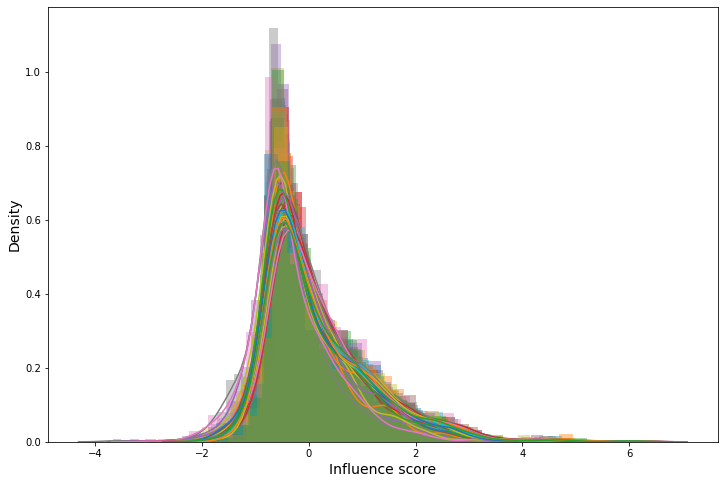

CPU times: user 6.08 s, sys: 16 ms, total: 6.09 s
Wall time: 6.08 s


In [71]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in list(map(lambda x: id2idx[x], correct_list)):
    sns.distplot(influence_matrix[i,:], ax=ax)
# plt.title('Distributuion of influence per validation sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_hessian/correct_valid_influence_dist_all_baseline_direct_2.png', bbox_inches='tight')
plt.show()

## Test Reevaluate Baseline

In [72]:
pd.DataFrame(influence_matrix.mean(axis=0)).describe(np.arange(0.0, 1.0, 0.05))

,0
count,768.000000
mean,-0.000001
std,0.719368
min,-1.215264
0%,-1.215264
5%,-0.729952
10%,-0.636962
15%,-0.607076
20%,-0.575263
25%,-0.534713


In [73]:
df = pd.DataFrame(influence_matrix.mean(axis=0)).sort_values(0)

In [74]:
def forward_with_feat_mask(model, feat_mask, batch_data, i2w, device='cpu'):
    # Unpack batch data
    if len(batch_data) == 4:
        (ids, subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 5:
        (ids, subword_batch, mask_batch, token_type_batch, label_batch) = batch_data
    
    # Prepare input & label
    subword = torch.LongTensor(subword_batch)
    attn_mask = torch.FloatTensor(mask_batch)
    label = torch.LongTensor(label_batch)

    if device == "cuda":
        subword = subword.cuda()
        attn_mask = attn_mask.cuda()
        label = label.cuda()

    if isinstance(model, RobertaForSequenceClassification):
        # Calculate latents
        latents = model.roberta(subword, attention_mask=attn_mask)[0][:,0,:]
        latents = model.classifier.dense(latents)
        
        # Compute prediction with feat_mask
        mask = torch.ones_like(latents, device=device)
        mask[:,feat_mask] = 0

        filt_latents = torch.tanh(latents) * mask
        logits = model.classifier.out_proj(filt_latents)
        loss = CrossEntropyLoss()(logits.view(-1, model.num_labels), label.view(-1))            
    else:
        raise NotImplementedError(f'Model class `{type(model)}` is not implemented yet')

    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])
        
    return loss, list_hyp, list_label, logits, label_batch

In [75]:
# Selective masking
model.eval()
torch.set_grad_enabled(False)
for k in range(0, 764, 50):
    print(f'== top-k : {k} ==')
    feat_mask = list(df.head(k).index)
    
    # Test on Indian
    total_loss = 0
    list_hyp, list_label = [], []
    for i, batch_data in enumerate(test_loader):
        batch_seq = batch_data[-1]
        outputs = forward_with_feat_mask(model, feat_mask, batch_data[:-1], i2w=i2w, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Calculate total loss
        total_loss += loss.item()

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label

    eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
    fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
    for key in fake_metrics.keys():
        eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
    real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
    for key in real_metrics.keys():
        eval_metrics[f'REAL_{key}'] = real_metrics[key]

    print(f'INDIAN TEST RESULT: {metrics_to_string(eval_metrics)}')
    
    # Test on YEJIN
    total_loss = 0
    list_hyp, list_label = [], []
    for i, batch_data in enumerate(test_zero_loader):
        batch_seq = batch_data[-1]
        outputs = forward_with_feat_mask(model, feat_mask, batch_data[:-1], i2w=i2w, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Calculate total loss
        total_loss += loss.item()

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label

    eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
    fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
    for key in fake_metrics.keys():
        eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
    real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
    for key in real_metrics.keys():
        eval_metrics[f'REAL_{key}'] = real_metrics[key]

    print(f'YEJIN TEST RESULT: {metrics_to_string(eval_metrics)}')

== top-k : 0 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9364 F1:0.9357 REC:0.9336 PRE:0.9444 FAKE_ACC:0.9364 FAKE_F1:0.9290 FAKE_REC:0.8725 FAKE_PRE:0.9933 REAL_ACC:0.9364 REAL_F1:0.9425 REAL_REC:0.9946 REAL_PRE:0.8955


/home/samuel/anaconda2/envs/env_py3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'fake') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


YEJIN TEST RESULT: ACC:0.7004 F1:0.6769 REC:0.7552 PRE:0.6912 FAKE_ACC:0.7004 FAKE_F1:0.5896 FAKE_REC:0.8644 FAKE_PRE:0.4474 REAL_ACC:0.7004 REAL_F1:0.7641 REAL_REC:0.6461 REAL_PRE:0.9350
== top-k : 50 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9350 F1:0.9343 REC:0.9321 PRE:0.9436 FAKE_ACC:0.9350 FAKE_F1:0.9273 FAKE_REC:0.8686 FAKE_PRE:0.9944 REAL_ACC:0.9350 REAL_F1:0.9413 REAL_REC:0.9955 REAL_PRE:0.8927
YEJIN TEST RESULT: ACC:0.7004 F1:0.6769 REC:0.7552 PRE:0.6912 FAKE_ACC:0.7004 FAKE_F1:0.5896 FAKE_REC:0.8644 FAKE_PRE:0.4474 REAL_ACC:0.7004 REAL_F1:0.7641 REAL_REC:0.6461 REAL_PRE:0.9350
== top-k : 100 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9346 F1:0.9338 REC:0.9316 PRE:0.9432 FAKE_ACC:0.9346 FAKE_F1:0.9267 FAKE_REC:0.8676 FAKE_PRE:0.9944 REAL_ACC:0.9346 REAL_F1:0.9409 REAL_REC:0.9955 REAL_PRE:0.8920
YEJIN TEST RESULT: ACC:0.7004 F1:0.6769 REC:0.7552 PRE:0.6912 FAKE_ACC:0.7004 FAKE_F1:0.5896 FAKE_REC:0.8644 FAKE_PRE:0.4474 REAL_ACC:0.7004 REAL_F1:0.7641 REAL_REC:0.6461 REAL_PRE:0.9350
== top-k : 150 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9346 F1:0.9338 REC:0.9316 PRE:0.9432 FAKE_ACC:0.9346 FAKE_F1:0.9267 FAKE_REC:0.8676 FAKE_PRE:0.9944 REAL_ACC:0.9346 REAL_F1:0.9409 REAL_REC:0.9955 REAL_PRE:0.8920
YEJIN TEST RESULT: ACC:0.7004 F1:0.6769 REC:0.7552 PRE:0.6912 FAKE_ACC:0.7004 FAKE_F1:0.5896 FAKE_REC:0.8644 FAKE_PRE:0.4474 REAL_ACC:0.7004 REAL_F1:0.7641 REAL_REC:0.6461 REAL_PRE:0.9350
== top-k : 200 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9332 F1:0.9324 REC:0.9301 PRE:0.9424 FAKE_ACC:0.9332 FAKE_F1:0.9249 FAKE_REC:0.8637 FAKE_PRE:0.9955 REAL_ACC:0.9332 REAL_F1:0.9398 REAL_REC:0.9964 REAL_PRE:0.8892
YEJIN TEST RESULT: ACC:0.7089 F1:0.6844 REC:0.7609 PRE:0.6957 FAKE_ACC:0.7089 FAKE_F1:0.5965 FAKE_REC:0.8644 FAKE_PRE:0.4554 REAL_ACC:0.7089 REAL_F1:0.7723 REAL_REC:0.6573 REAL_PRE:0.9360
== top-k : 250 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9332 F1:0.9324 REC:0.9301 PRE:0.9424 FAKE_ACC:0.9332 FAKE_F1:0.9249 FAKE_REC:0.8637 FAKE_PRE:0.9955 REAL_ACC:0.9332 REAL_F1:0.9398 REAL_REC:0.9964 REAL_PRE:0.8892
YEJIN TEST RESULT: ACC:0.7089 F1:0.6844 REC:0.7609 PRE:0.6957 FAKE_ACC:0.7089 FAKE_F1:0.5965 FAKE_REC:0.8644 FAKE_PRE:0.4554 REAL_ACC:0.7089 REAL_F1:0.7723 REAL_REC:0.6573 REAL_PRE:0.9360
== top-k : 300 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9327 F1:0.9319 REC:0.9296 PRE:0.9420 FAKE_ACC:0.9327 FAKE_F1:0.9244 FAKE_REC:0.8627 FAKE_PRE:0.9955 REAL_ACC:0.9327 REAL_F1:0.9394 REAL_REC:0.9964 REAL_PRE:0.8885
YEJIN TEST RESULT: ACC:0.7131 F1:0.6882 REC:0.7637 PRE:0.6980 FAKE_ACC:0.7131 FAKE_F1:0.6000 FAKE_REC:0.8644 FAKE_PRE:0.4595 REAL_ACC:0.7131 REAL_F1:0.7763 REAL_REC:0.6629 REAL_PRE:0.9365
== top-k : 350 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9322 F1:0.9314 REC:0.9291 PRE:0.9416 FAKE_ACC:0.9322 FAKE_F1:0.9238 FAKE_REC:0.8618 FAKE_PRE:0.9955 REAL_ACC:0.9322 REAL_F1:0.9390 REAL_REC:0.9964 REAL_PRE:0.8878
YEJIN TEST RESULT: ACC:0.7131 F1:0.6882 REC:0.7637 PRE:0.6980 FAKE_ACC:0.7131 FAKE_F1:0.6000 FAKE_REC:0.8644 FAKE_PRE:0.4595 REAL_ACC:0.7131 REAL_F1:0.7763 REAL_REC:0.6629 REAL_PRE:0.9365
== top-k : 400 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9299 F1:0.9290 REC:0.9266 PRE:0.9399 FAKE_ACC:0.9299 FAKE_F1:0.9210 FAKE_REC:0.8569 FAKE_PRE:0.9954 REAL_ACC:0.9299 REAL_F1:0.9370 REAL_REC:0.9964 REAL_PRE:0.8843
YEJIN TEST RESULT: ACC:0.7131 F1:0.6882 REC:0.7637 PRE:0.6980 FAKE_ACC:0.7131 FAKE_F1:0.6000 FAKE_REC:0.8644 FAKE_PRE:0.4595 REAL_ACC:0.7131 REAL_F1:0.7763 REAL_REC:0.6629 REAL_PRE:0.9365
== top-k : 450 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9304 F1:0.9295 REC:0.9271 PRE:0.9402 FAKE_ACC:0.9304 FAKE_F1:0.9215 FAKE_REC:0.8578 FAKE_PRE:0.9954 REAL_ACC:0.9304 REAL_F1:0.9374 REAL_REC:0.9964 REAL_PRE:0.8850
YEJIN TEST RESULT: ACC:0.7131 F1:0.6882 REC:0.7637 PRE:0.6980 FAKE_ACC:0.7131 FAKE_F1:0.6000 FAKE_REC:0.8644 FAKE_PRE:0.4595 REAL_ACC:0.7131 REAL_F1:0.7763 REAL_REC:0.6629 REAL_PRE:0.9365
== top-k : 500 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9299 F1:0.9290 REC:0.9266 PRE:0.9399 FAKE_ACC:0.9299 FAKE_F1:0.9210 FAKE_REC:0.8569 FAKE_PRE:0.9954 REAL_ACC:0.9299 REAL_F1:0.9370 REAL_REC:0.9964 REAL_PRE:0.8843
YEJIN TEST RESULT: ACC:0.7131 F1:0.6882 REC:0.7637 PRE:0.6980 FAKE_ACC:0.7131 FAKE_F1:0.6000 FAKE_REC:0.8644 FAKE_PRE:0.4595 REAL_ACC:0.7131 REAL_F1:0.7763 REAL_REC:0.6629 REAL_PRE:0.9365
== top-k : 550 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9299 F1:0.9290 REC:0.9266 PRE:0.9399 FAKE_ACC:0.9299 FAKE_F1:0.9210 FAKE_REC:0.8569 FAKE_PRE:0.9954 REAL_ACC:0.9299 REAL_F1:0.9370 REAL_REC:0.9964 REAL_PRE:0.8843
YEJIN TEST RESULT: ACC:0.7131 F1:0.6882 REC:0.7637 PRE:0.6980 FAKE_ACC:0.7131 FAKE_F1:0.6000 FAKE_REC:0.8644 FAKE_PRE:0.4595 REAL_ACC:0.7131 REAL_F1:0.7763 REAL_REC:0.6629 REAL_PRE:0.9365
== top-k : 600 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9299 F1:0.9290 REC:0.9266 PRE:0.9399 FAKE_ACC:0.9299 FAKE_F1:0.9210 FAKE_REC:0.8569 FAKE_PRE:0.9954 REAL_ACC:0.9299 REAL_F1:0.9370 REAL_REC:0.9964 REAL_PRE:0.8843
YEJIN TEST RESULT: ACC:0.7131 F1:0.6882 REC:0.7637 PRE:0.6980 FAKE_ACC:0.7131 FAKE_F1:0.6000 FAKE_REC:0.8644 FAKE_PRE:0.4595 REAL_ACC:0.7131 REAL_F1:0.7763 REAL_REC:0.6629 REAL_PRE:0.9365
== top-k : 650 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9313 F1:0.9304 REC:0.9281 PRE:0.9409 FAKE_ACC:0.9313 FAKE_F1:0.9227 FAKE_REC:0.8598 FAKE_PRE:0.9955 REAL_ACC:0.9313 REAL_F1:0.9382 REAL_REC:0.9964 REAL_PRE:0.8864
YEJIN TEST RESULT: ACC:0.7131 F1:0.6882 REC:0.7637 PRE:0.6980 FAKE_ACC:0.7131 FAKE_F1:0.6000 FAKE_REC:0.8644 FAKE_PRE:0.4595 REAL_ACC:0.7131 REAL_F1:0.7763 REAL_REC:0.6629 REAL_PRE:0.9365
== top-k : 700 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9304 F1:0.9295 REC:0.9272 PRE:0.9397 FAKE_ACC:0.9304 FAKE_F1:0.9217 FAKE_REC:0.8598 FAKE_PRE:0.9932 REAL_ACC:0.9304 REAL_F1:0.9373 REAL_REC:0.9946 REAL_PRE:0.8862
YEJIN TEST RESULT: ACC:0.7089 F1:0.6844 REC:0.7609 PRE:0.6957 FAKE_ACC:0.7089 FAKE_F1:0.5965 FAKE_REC:0.8644 FAKE_PRE:0.4554 REAL_ACC:0.7089 REAL_F1:0.7723 REAL_REC:0.6573 REAL_PRE:0.9360
== top-k : 750 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9234 F1:0.9223 REC:0.9198 PRE:0.9350 FAKE_ACC:0.9234 FAKE_F1:0.9130 FAKE_REC:0.8431 FAKE_PRE:0.9954 REAL_ACC:0.9234 REAL_F1:0.9316 REAL_REC:0.9964 REAL_PRE:0.8746
YEJIN TEST RESULT: ACC:0.6920 F1:0.6546 REC:0.7043 PRE:0.6566 FAKE_ACC:0.6920 FAKE_F1:0.5409 FAKE_REC:0.7288 FAKE_PRE:0.4300 REAL_ACC:0.6920 REAL_F1:0.7683 REAL_REC:0.6798 REAL_PRE:0.8832


In [76]:
# Random masking
model.eval()
torch.set_grad_enabled(False)
for k in range(0, 764, 50):
    print(f'== top-k : {k} ==')
    feat_mask = np.random.choice(np.arange(0,764), k, replace=False)
    
    # Test on Indian
    total_loss = 0
    list_hyp, list_label = [], []
    for i, batch_data in enumerate(test_loader):
        batch_seq = batch_data[-1]
        outputs = forward_with_feat_mask(model, feat_mask, batch_data[:-1], i2w=i2w, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Calculate total loss
        total_loss += loss.item()

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label

    eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
    fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
    for key in fake_metrics.keys():
        eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
    real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
    for key in real_metrics.keys():
        eval_metrics[f'REAL_{key}'] = real_metrics[key]

    print(f'INDIAN TEST RESULT: {metrics_to_string(eval_metrics)}')
    
    # Test on YEJIN
    total_loss = 0
    list_hyp, list_label = [], []
    for i, batch_data in enumerate(test_zero_loader):
        batch_seq = batch_data[-1]
        outputs = forward_with_feat_mask(model, feat_mask, batch_data[:-1], i2w=i2w, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Calculate total loss
        total_loss += loss.item()

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label

    eval_metrics = classification_metrics_fn(list_hyp, list_label, average='macro', pos_label='fake')
    fake_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='fake')
    for key in fake_metrics.keys():
        eval_metrics[f'FAKE_{key}'] = fake_metrics[key]
    real_metrics = classification_metrics_fn(list_hyp, list_label, average='binary', pos_label='real')
    for key in real_metrics.keys():
        eval_metrics[f'REAL_{key}'] = real_metrics[key]

    print(f'YEJIN TEST RESULT: {metrics_to_string(eval_metrics)}')

== top-k : 0 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9364 F1:0.9357 REC:0.9336 PRE:0.9444 FAKE_ACC:0.9364 FAKE_F1:0.9290 FAKE_REC:0.8725 FAKE_PRE:0.9933 REAL_ACC:0.9364 REAL_F1:0.9425 REAL_REC:0.9946 REAL_PRE:0.8955
YEJIN TEST RESULT: ACC:0.7004 F1:0.6769 REC:0.7552 PRE:0.6912 FAKE_ACC:0.7004 FAKE_F1:0.5896 FAKE_REC:0.8644 FAKE_PRE:0.4474 REAL_ACC:0.7004 REAL_F1:0.7641 REAL_REC:0.6461 REAL_PRE:0.9350
== top-k : 50 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9364 F1:0.9357 REC:0.9336 PRE:0.9444 FAKE_ACC:0.9364 FAKE_F1:0.9290 FAKE_REC:0.8725 FAKE_PRE:0.9933 REAL_ACC:0.9364 REAL_F1:0.9425 REAL_REC:0.9946 REAL_PRE:0.8955
YEJIN TEST RESULT: ACC:0.7004 F1:0.6769 REC:0.7552 PRE:0.6912 FAKE_ACC:0.7004 FAKE_F1:0.5896 FAKE_REC:0.8644 FAKE_PRE:0.4474 REAL_ACC:0.7004 REAL_F1:0.7641 REAL_REC:0.6461 REAL_PRE:0.9350
== top-k : 100 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9369 F1:0.9362 REC:0.9341 PRE:0.9448 FAKE_ACC:0.9369 FAKE_F1:0.9296 FAKE_REC:0.8735 FAKE_PRE:0.9933 REAL_ACC:0.9369 REAL_F1:0.9429 REAL_REC:0.9946 REAL_PRE:0.8962
YEJIN TEST RESULT: ACC:0.7004 F1:0.6769 REC:0.7552 PRE:0.6912 FAKE_ACC:0.7004 FAKE_F1:0.5896 FAKE_REC:0.8644 FAKE_PRE:0.4474 REAL_ACC:0.7004 REAL_F1:0.7641 REAL_REC:0.6461 REAL_PRE:0.9350
== top-k : 150 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9364 F1:0.9357 REC:0.9336 PRE:0.9444 FAKE_ACC:0.9364 FAKE_F1:0.9290 FAKE_REC:0.8725 FAKE_PRE:0.9933 REAL_ACC:0.9364 REAL_F1:0.9425 REAL_REC:0.9946 REAL_PRE:0.8955
YEJIN TEST RESULT: ACC:0.7004 F1:0.6769 REC:0.7552 PRE:0.6912 FAKE_ACC:0.7004 FAKE_F1:0.5896 FAKE_REC:0.8644 FAKE_PRE:0.4474 REAL_ACC:0.7004 REAL_F1:0.7641 REAL_REC:0.6461 REAL_PRE:0.9350
== top-k : 200 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9355 F1:0.9348 REC:0.9326 PRE:0.9437 FAKE_ACC:0.9355 FAKE_F1:0.9279 FAKE_REC:0.8706 FAKE_PRE:0.9933 REAL_ACC:0.9355 REAL_F1:0.9417 REAL_REC:0.9946 REAL_PRE:0.8941
YEJIN TEST RESULT: ACC:0.7004 F1:0.6769 REC:0.7552 PRE:0.6912 FAKE_ACC:0.7004 FAKE_F1:0.5896 FAKE_REC:0.8644 FAKE_PRE:0.4474 REAL_ACC:0.7004 REAL_F1:0.7641 REAL_REC:0.6461 REAL_PRE:0.9350
== top-k : 250 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9364 F1:0.9357 REC:0.9336 PRE:0.9446 FAKE_ACC:0.9364 FAKE_F1:0.9289 FAKE_REC:0.8716 FAKE_PRE:0.9944 REAL_ACC:0.9364 REAL_F1:0.9425 REAL_REC:0.9955 REAL_PRE:0.8949
YEJIN TEST RESULT: ACC:0.7004 F1:0.6769 REC:0.7552 PRE:0.6912 FAKE_ACC:0.7004 FAKE_F1:0.5896 FAKE_REC:0.8644 FAKE_PRE:0.4474 REAL_ACC:0.7004 REAL_F1:0.7641 REAL_REC:0.6461 REAL_PRE:0.9350
== top-k : 300 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9355 F1:0.9348 REC:0.9326 PRE:0.9439 FAKE_ACC:0.9355 FAKE_F1:0.9278 FAKE_REC:0.8696 FAKE_PRE:0.9944 REAL_ACC:0.9355 REAL_F1:0.9417 REAL_REC:0.9955 REAL_PRE:0.8934
YEJIN TEST RESULT: ACC:0.7004 F1:0.6769 REC:0.7552 PRE:0.6912 FAKE_ACC:0.7004 FAKE_F1:0.5896 FAKE_REC:0.8644 FAKE_PRE:0.4474 REAL_ACC:0.7004 REAL_F1:0.7641 REAL_REC:0.6461 REAL_PRE:0.9350
== top-k : 350 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9336 F1:0.9328 REC:0.9306 PRE:0.9427 FAKE_ACC:0.9336 FAKE_F1:0.9255 FAKE_REC:0.8647 FAKE_PRE:0.9955 REAL_ACC:0.9336 REAL_F1:0.9402 REAL_REC:0.9964 REAL_PRE:0.8900
YEJIN TEST RESULT: ACC:0.7131 F1:0.6882 REC:0.7637 PRE:0.6980 FAKE_ACC:0.7131 FAKE_F1:0.6000 FAKE_REC:0.8644 FAKE_PRE:0.4595 REAL_ACC:0.7131 REAL_F1:0.7763 REAL_REC:0.6629 REAL_PRE:0.9365
== top-k : 400 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9327 F1:0.9319 REC:0.9296 PRE:0.9418 FAKE_ACC:0.9327 FAKE_F1:0.9244 FAKE_REC:0.8637 FAKE_PRE:0.9944 REAL_ACC:0.9327 REAL_F1:0.9393 REAL_REC:0.9955 REAL_PRE:0.8892
YEJIN TEST RESULT: ACC:0.7089 F1:0.6844 REC:0.7609 PRE:0.6957 FAKE_ACC:0.7089 FAKE_F1:0.5965 FAKE_REC:0.8644 FAKE_PRE:0.4554 REAL_ACC:0.7089 REAL_F1:0.7723 REAL_REC:0.6573 REAL_PRE:0.9360
== top-k : 450 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9364 F1:0.9357 REC:0.9336 PRE:0.9444 FAKE_ACC:0.9364 FAKE_F1:0.9290 FAKE_REC:0.8725 FAKE_PRE:0.9933 REAL_ACC:0.9364 REAL_F1:0.9425 REAL_REC:0.9946 REAL_PRE:0.8955
YEJIN TEST RESULT: ACC:0.6920 F1:0.6694 REC:0.7496 PRE:0.6868 FAKE_ACC:0.6920 FAKE_F1:0.5829 FAKE_REC:0.8644 FAKE_PRE:0.4397 REAL_ACC:0.6920 REAL_F1:0.7559 REAL_REC:0.6348 REAL_PRE:0.9339
== top-k : 500 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9336 F1:0.9329 REC:0.9306 PRE:0.9425 FAKE_ACC:0.9336 FAKE_F1:0.9256 FAKE_REC:0.8657 FAKE_PRE:0.9944 REAL_ACC:0.9336 REAL_F1:0.9401 REAL_REC:0.9955 REAL_PRE:0.8906
YEJIN TEST RESULT: ACC:0.7004 F1:0.6769 REC:0.7552 PRE:0.6912 FAKE_ACC:0.7004 FAKE_F1:0.5896 FAKE_REC:0.8644 FAKE_PRE:0.4474 REAL_ACC:0.7004 REAL_F1:0.7641 REAL_REC:0.6461 REAL_PRE:0.9350
== top-k : 550 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9360 F1:0.9353 REC:0.9331 PRE:0.9440 FAKE_ACC:0.9360 FAKE_F1:0.9285 FAKE_REC:0.8716 FAKE_PRE:0.9933 REAL_ACC:0.9360 REAL_F1:0.9421 REAL_REC:0.9946 REAL_PRE:0.8948
YEJIN TEST RESULT: ACC:0.7004 F1:0.6769 REC:0.7552 PRE:0.6912 FAKE_ACC:0.7004 FAKE_F1:0.5896 FAKE_REC:0.8644 FAKE_PRE:0.4474 REAL_ACC:0.7004 REAL_F1:0.7641 REAL_REC:0.6461 REAL_PRE:0.9350
== top-k : 600 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9374 F1:0.9367 REC:0.9345 PRE:0.9454 FAKE_ACC:0.9374 FAKE_F1:0.9301 FAKE_REC:0.8735 FAKE_PRE:0.9944 REAL_ACC:0.9374 REAL_F1:0.9433 REAL_REC:0.9955 REAL_PRE:0.8963
YEJIN TEST RESULT: ACC:0.7004 F1:0.6784 REC:0.7609 PRE:0.6952 FAKE_ACC:0.7004 FAKE_F1:0.5943 FAKE_REC:0.8814 FAKE_PRE:0.4483 REAL_ACC:0.7004 REAL_F1:0.7625 REAL_REC:0.6404 REAL_PRE:0.9421
== top-k : 650 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9374 F1:0.9367 REC:0.9346 PRE:0.9451 FAKE_ACC:0.9374 FAKE_F1:0.9301 FAKE_REC:0.8745 FAKE_PRE:0.9933 REAL_ACC:0.9374 REAL_F1:0.9433 REAL_REC:0.9946 REAL_PRE:0.8969
YEJIN TEST RESULT: ACC:0.7004 F1:0.6784 REC:0.7609 PRE:0.6952 FAKE_ACC:0.7004 FAKE_F1:0.5943 FAKE_REC:0.8814 FAKE_PRE:0.4483 REAL_ACC:0.7004 REAL_F1:0.7625 REAL_REC:0.6404 REAL_PRE:0.9421
== top-k : 700 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9285 F1:0.9276 REC:0.9252 PRE:0.9388 FAKE_ACC:0.9285 FAKE_F1:0.9193 FAKE_REC:0.8539 FAKE_PRE:0.9954 REAL_ACC:0.9285 REAL_F1:0.9358 REAL_REC:0.9964 REAL_PRE:0.8822
YEJIN TEST RESULT: ACC:0.6962 F1:0.6662 REC:0.7298 PRE:0.6735 FAKE_ACC:0.6962 FAKE_F1:0.5663 FAKE_REC:0.7966 FAKE_PRE:0.4393 REAL_ACC:0.6962 REAL_F1:0.7662 REAL_REC:0.6629 REAL_PRE:0.9077
== top-k : 750 ==


Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


INDIAN TEST RESULT: ACC:0.9238 F1:0.9227 REC:0.9203 PRE:0.9353 FAKE_ACC:0.9238 FAKE_F1:0.9135 FAKE_REC:0.8441 FAKE_PRE:0.9954 REAL_ACC:0.9238 REAL_F1:0.9319 REAL_REC:0.9964 REAL_PRE:0.8753
YEJIN TEST RESULT: ACC:0.7046 F1:0.6773 REC:0.7467 PRE:0.6857 FAKE_ACC:0.7046 FAKE_F1:0.5833 FAKE_REC:0.8305 FAKE_PRE:0.4495 REAL_ACC:0.7046 REAL_F1:0.7712 REAL_REC:0.6629 REAL_PRE:0.9219
